# Time Series Analysis of Spring 2024 HS DDM
Notebook by Jack Swenson

# Imports

In [ ]:
#any necessary imports
import pandas as pd
import numpy as np
import json
import requests
from tqdm import tqdm
import os
import io
import errno
import re
import random
import numpy as np
import sys
import copy
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import datetime

pd.set_option('display.max_columns', None)

# Full DDM HS Administration Data -- Import and Exploration

Pulling high school DDM response data from the [BASS website](https://cr4cradmin.bear-apps.com/scheduled_activities/6376/download_files):

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Spring 2024 HS DDM Administration respondent actions.csv to Spring 2024 HS DDM Administration respondent actions.csv


In [ ]:
print(uploaded.keys())

dict_keys(['Spring 2024 HS DDM Administration respondent actions.csv'])


In [ ]:
ddm_df = pd.read_csv(io.BytesIO(uploaded['Spring 2024 HS DDM Administration respondent actions.csv']))
ddm_df

,Assignment,Activities,Date,Time,Action
0,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:21:49.642,Begin activity Spring 2024 HS DDM Administration
1,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:21:50.014,Page 1 Loaded
2,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:21:54.940,Page next clicked on page 1
3,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:21:55.570,Page 2 Loaded
4,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:22:03.887,Page next clicked on page 2
...,...,...,...,...,...
327064,113718,Spr 24 DDM HS Form A1r,05/14/2024,11:34:49.190,Page 34 Loaded
327065,113718,Spr 24 DDM HS Form A1r,05/14/2024,11:34:53.521,Page next clicked on page 34
327066,113718,Spr 24 DDM HS Form A1r,05/14/2024,11:34:56.172,Page 35 Loaded
327067,113718,Spr 24 DDM HS Form A1r,05/14/2024,11:35:01.128,Page next clicked on page 35


In [ ]:
print('Number of students in full dataset:', len(ddm_df['Assignment'].unique()))
print('Number of activities in full dataset:', len(ddm_df['Activities'].unique()))

Number of students in full dataset: 4788
Number of activities in full dataset: 6


In [ ]:
ddm_df['Activities'].unique()

array(['Spr 24 DDM HS Form A2r', 'Spr 24 DDM HS Form Cr',
       'Spr 24 DDM HS Form Dr', 'Spr 24 DDM HS Form A1r',
       'Spr 24 DDM HS Form Br', nan], dtype=object)

In [ ]:
ddm_df['Action'].unique()

array(['Begin activity Spring 2024 HS DDM Administration',
       'Page 1 Loaded', 'Page next clicked on page 1', 'Page 2 Loaded',
       'Page next clicked on page 2', 'Page 3 Loaded',
       'Page next clicked on page 3', 'Page 4 Loaded',
       'Page next clicked on page 4', 'Page 5 Loaded',
       'Page next clicked on page 5', 'Page 6 Loaded',
       'Page next clicked on page 6', 'Page 7 Loaded',
       'Page next clicked on page 7', 'Page 8 Loaded',
       'Page next clicked on page 8', 'Page 9 Loaded',
       'Page next clicked on page 9', 'Page 10 Loaded',
       'Page next clicked on page 10', 'Page 11 Loaded',
       'Page next clicked on page 11', 'Page 12 Loaded',
       'Page next clicked on page 12', 'Page 13 Loaded',
       'Page next clicked on page 13', 'Page 14 Loaded',
       'Page next clicked on page 14', 'Page 15 Loaded',
       'Page next clicked on page 15', 'Page 16 Loaded',
       'Page next clicked on page 16', 'Page 17 Loaded',
       'Page next clicked on 

In [ ]:
ddm_df['Action'].unique()
['Begin activity Spring 2024 HS DDM Administration', 'End activity Spring 2024 HS DDM Administration','Pause activity Spring 2024 HS DDM Administration', 'Continue activity Spring 2024 HS DDM Administration']

['Begin activity Spring 2024 HS DDM Administration',
 'End activity Spring 2024 HS DDM Administration',
 'Pause activity Spring 2024 HS DDM Administration',
 'Continue activity Spring 2024 HS DDM Administration']

# Time Analysis (Including Removing Pause Data)

Steps to do:

1.   get a subset of students who completed the activity (with and without pauses)
2.   calculate how long it took for them to pause + continue (continue time - pause time)
3. get the subset of students who completed the activity in less than a day
4. plot in *boxplots*

## Major Summary For Pause Data

Number of forms/activities (overall): 6

*Before looking at only Pause Data*
Initial number of students: 4788

* missing the End time: 569
* Unique End dates: 43

Analytic sample (number of students remained after dropping a. & b. ): 4176

Number of students “paused”: 524

Average Completion Time (overall): 18:55:44

## Pause Subset

In [ ]:
def check_end_activity(group):
    return 'End activity Spring 2024 HS DDM Administration' in group['Action'].values

# Group by 'Assignment', apply the function, and count False values which indicate missing 'End activity'
missing_end_activity_count = ddm_df.groupby('Assignment').apply(check_end_activity).value_counts()[False]

print(f"Number of students missing 'End activity Spring 2024 HS DDM Administration': {missing_end_activity_count}")

Number of students missing 'End activity Spring 2024 HS DDM Administration': 569


In [ ]:
#Number of students who paused
pause_activities = ddm_df[ddm_df['Action'] == 'Pause activity Spring 2024 HS DDM Administration']
unique_assignment = pause_activities["Assignment"].unique()
len(unique_assignment)

524

In [ ]:
end_activities = ddm_df[ddm_df['Action'] == 'End activity Spring 2024 HS DDM Administration']
unique_date = end_activities["Date"].unique()
len(unique_date)

43

In [ ]:
ddm_df['Datetime'] = pd.to_datetime(ddm_df['Date'] + ' ' + ddm_df['Time'])

In [ ]:
# Filter start and end times into separate DataFrames
start_times = ddm_df[ddm_df['Action'] == 'Begin activity Spring 2024 HS DDM Administration']
end_times = ddm_df[ddm_df['Action'] == 'End activity Spring 2024 HS DDM Administration']

In [ ]:
start_times = start_times.set_index('Assignment')
end_times = end_times.set_index('Assignment')

durations = end_times['Datetime'] - start_times['Datetime']
durations = durations[durations > pd.Timedelta(0)]
average_completion_time = durations.mean()
print(f"Average Completion Time: {average_completion_time}")

Average Completion Time: 0 days 18:55:44.430432227


In [ ]:
completed = ddm_df[ddm_df["Action"].isin(['End activity Spring 2024 HS DDM Administration'])]
completed.head(5)

,Assignment,Activities,Date,Time,Action,Datetime
71,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:48:46.847,End activity Spring 2024 HS DDM Administration,2024-05-09 16:48:46.847
149,114141,Spr 24 DDM HS Form Cr,05/17/2024,10:40:31.054,End activity Spring 2024 HS DDM Administration,2024-05-17 10:40:31.054
221,101122,Spr 24 DDM HS Form Dr,04/23/2024,20:29:00.605,End activity Spring 2024 HS DDM Administration,2024-04-23 20:29:00.605
295,100177,Spr 24 DDM HS Form A1r,04/17/2024,11:42:52.288,End activity Spring 2024 HS DDM Administration,2024-04-17 11:42:52.288
365,100189,Spr 24 DDM HS Form Cr,04/17/2024,11:14:09.454,End activity Spring 2024 HS DDM Administration,2024-04-17 11:14:09.454


In [ ]:
#get the unique id's for the subet of students who finished the activities
completed_assignments = completed['Assignment'].unique()
completed_assignments

array([110349, 114141, 101122, ...,  97181,  97590, 113718])

In [ ]:
completed_subset = ddm_df[ddm_df['Assignment'].isin(completed_assignments)]
completed_subset

,Assignment,Activities,Date,Time,Action,Datetime
0,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:21:49.642,Begin activity Spring 2024 HS DDM Administration,2024-05-09 16:21:49.642
1,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:21:50.014,Page 1 Loaded,2024-05-09 16:21:50.014
2,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:21:54.940,Page next clicked on page 1,2024-05-09 16:21:54.940
3,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:21:55.570,Page 2 Loaded,2024-05-09 16:21:55.570
4,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:22:03.887,Page next clicked on page 2,2024-05-09 16:22:03.887
...,...,...,...,...,...,...
327064,113718,Spr 24 DDM HS Form A1r,05/14/2024,11:34:49.190,Page 34 Loaded,2024-05-14 11:34:49.190
327065,113718,Spr 24 DDM HS Form A1r,05/14/2024,11:34:53.521,Page next clicked on page 34,2024-05-14 11:34:53.521
327066,113718,Spr 24 DDM HS Form A1r,05/14/2024,11:34:56.172,Page 35 Loaded,2024-05-14 11:34:56.172
327067,113718,Spr 24 DDM HS Form A1r,05/14/2024,11:35:01.128,Page next clicked on page 35,2024-05-14 11:35:01.128


In [ ]:
completed_subset["Assignment"]

,Assignment
0,110349
1,110349
2,110349
3,110349
4,110349
...,...
327064,113718
327065,113718
327066,113718
327067,113718


# Completion Time for all completers (incl. those who paused)

In [ ]:
completed_subset

,Assignment,Activities,Date,Time,Action,Datetime
0,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:21:49.642,Begin activity Spring 2024 HS DDM Administration,2024-05-09 16:21:49.642
1,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:21:50.014,Page 1 Loaded,2024-05-09 16:21:50.014
2,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:21:54.940,Page next clicked on page 1,2024-05-09 16:21:54.940
3,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:21:55.570,Page 2 Loaded,2024-05-09 16:21:55.570
4,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:22:03.887,Page next clicked on page 2,2024-05-09 16:22:03.887
...,...,...,...,...,...,...
327064,113718,Spr 24 DDM HS Form A1r,05/14/2024,11:34:49.190,Page 34 Loaded,2024-05-14 11:34:49.190
327065,113718,Spr 24 DDM HS Form A1r,05/14/2024,11:34:53.521,Page next clicked on page 34,2024-05-14 11:34:53.521
327066,113718,Spr 24 DDM HS Form A1r,05/14/2024,11:34:56.172,Page 35 Loaded,2024-05-14 11:34:56.172
327067,113718,Spr 24 DDM HS Form A1r,05/14/2024,11:35:01.128,Page next clicked on page 35,2024-05-14 11:35:01.128


In [ ]:
completed_subset['Datetime'] = pd.to_datetime(completed_subset['Datetime'])

# Filter to get rows where the action is 'Begin activity Spring 2024 HS DDM Administration'
begin_activities = completed_subset[completed_subset['Action'] == 'Begin activity Spring 2024 HS DDM Administration']

# Filter to get rows where the action is 'End activity Spring 2024 HS DDM Administration'
end_activities = completed_subset[completed_subset['Action'] == 'End activity Spring 2024 HS DDM Administration']

# Merge begin and end activities on 'Assignment'
activity_times = pd.merge(begin_activities, end_activities, on='Assignment', suffixes=('_begin', '_end'))

# Calculate the difference in minutes
activity_times['Duration_Minutes'] = (activity_times['Datetime_end'] - activity_times['Datetime_begin']).dt.total_seconds() / 60

# Create a result DataFrame with relevant information
result = activity_times[['Assignment','Datetime_begin', 'Datetime_end', 'Duration_Minutes']]
result

<ipython-input-21-ccac6876e9aa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completed_subset['Datetime'] = pd.to_datetime(completed_subset['Datetime'])


,Assignment,Datetime_begin,Datetime_end,Duration_Minutes
0,110349,2024-05-09 16:21:49.642,2024-05-09 16:48:46.847,26.953417
1,114141,2024-05-17 10:35:38.233,2024-05-17 10:40:31.054,4.880350
2,101122,2024-04-23 20:02:23.761,2024-04-23 20:29:00.605,26.614067
3,100177,2024-04-17 11:07:56.272,2024-04-17 11:42:52.288,34.933600
4,100189,2024-04-17 11:05:57.978,2024-04-17 11:14:09.454,8.191267
...,...,...,...,...
4215,97593,2024-05-07 12:35:16.315,2024-05-07 16:38:21.933,243.093633
4216,97043,2024-05-08 04:41:55.161,2024-05-08 05:10:58.167,29.050100
4217,97181,2024-05-08 05:46:54.789,2024-05-08 06:06:48.746,19.899283
4218,97590,2024-05-08 06:26:36.666,2024-05-08 07:26:47.500,60.180567


In [ ]:
combined_results_df = pd.merge(result, completed_subset[['Assignment', 'Activities']], on='Assignment', how='inner')

# Display the result
combined_result_df = combined_results_df.drop_duplicates()
combined_result_df

,Assignment,Datetime_begin,Datetime_end,Duration_Minutes,Activities
0,110349,2024-05-09 16:21:49.642,2024-05-09 16:48:46.847,26.953417,Spr 24 DDM HS Form A2r
72,114141,2024-05-17 10:35:38.233,2024-05-17 10:40:31.054,4.880350,Spr 24 DDM HS Form Cr
150,101122,2024-04-23 20:02:23.761,2024-04-23 20:29:00.605,26.614067,Spr 24 DDM HS Form Dr
222,100177,2024-04-17 11:07:56.272,2024-04-17 11:42:52.288,34.933600,Spr 24 DDM HS Form A1r
296,100189,2024-04-17 11:05:57.978,2024-04-17 11:14:09.454,8.191267,Spr 24 DDM HS Form Cr
...,...,...,...,...,...
310804,97593,2024-05-07 12:35:16.315,2024-05-07 16:38:21.933,243.093633,Spr 24 DDM HS Form Cr
310876,97043,2024-05-08 04:41:55.161,2024-05-08 05:10:58.167,29.050100,Spr 24 DDM HS Form Cr
310946,97181,2024-05-08 05:46:54.789,2024-05-08 06:06:48.746,19.899283,Spr 24 DDM HS Form Br
311014,97590,2024-05-08 06:26:36.666,2024-05-08 07:26:47.500,60.180567,Spr 24 DDM HS Form Dr


In [ ]:
results_df = combined_result_df.drop_duplicates()
modified_results_df = results_df[["Assignment", "Activities", "Duration_Minutes"]]
modified_results_df['Duration_Minutes'] = pd.to_timedelta(modified_results_df['Duration_Minutes'], unit='m')
modified_results_df

<ipython-input-23-f7a24f8d0c89>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_results_df['Duration_Minutes'] = pd.to_timedelta(modified_results_df['Duration_Minutes'], unit='m')


,Assignment,Activities,Duration_Minutes
0,110349,Spr 24 DDM HS Form A2r,0 days 00:26:57.205000002
72,114141,Spr 24 DDM HS Form Cr,0 days 00:04:52.821000
150,101122,Spr 24 DDM HS Form Dr,0 days 00:26:36.844000002
222,100177,Spr 24 DDM HS Form A1r,0 days 00:34:56.016000
296,100189,Spr 24 DDM HS Form Cr,0 days 00:08:11.476000002
...,...,...,...
310804,97593,Spr 24 DDM HS Form Cr,0 days 04:03:05.617999998
310876,97043,Spr 24 DDM HS Form Cr,0 days 00:29:03.006000
310946,97181,Spr 24 DDM HS Form Br,0 days 00:19:53.956999998
311014,97590,Spr 24 DDM HS Form Dr,0 days 01:00:10.834000002


In [ ]:
modified_day_limit = modified_results_df[modified_results_df['Duration_Minutes'] <= pd.Timedelta(days=1)]
modified_day_limit

,Assignment,Activities,Duration_Minutes
0,110349,Spr 24 DDM HS Form A2r,0 days 00:26:57.205000002
72,114141,Spr 24 DDM HS Form Cr,0 days 00:04:52.821000
150,101122,Spr 24 DDM HS Form Dr,0 days 00:26:36.844000002
222,100177,Spr 24 DDM HS Form A1r,0 days 00:34:56.016000
296,100189,Spr 24 DDM HS Form Cr,0 days 00:08:11.476000002
...,...,...,...
310804,97593,Spr 24 DDM HS Form Cr,0 days 04:03:05.617999998
310876,97043,Spr 24 DDM HS Form Cr,0 days 00:29:03.006000
310946,97181,Spr 24 DDM HS Form Br,0 days 00:19:53.956999998
311014,97590,Spr 24 DDM HS Form Dr,0 days 01:00:10.834000002


In [ ]:
modified_ave_per_act = modified_day_limit.groupby('Activities')[['Duration_Minutes']].describe()
modified_ave_per_act = modified_ave_per_act.astype(str)
modified_ave_per_act[('Duration_Minutes','mean')] = [x[7:-7] for x in modified_ave_per_act[('Duration_Minutes','mean')]]
modified_ave_per_act[('Duration_Minutes','std')] = [x[7:-10] for x in modified_ave_per_act[('Duration_Minutes','std')]]
modified_ave_per_act[('Duration_Minutes','min')] = [x[7:-7] for x in modified_ave_per_act[('Duration_Minutes','min')]]
modified_ave_per_act[('Duration_Minutes','25%')] = [x[7:-7] for x in modified_ave_per_act[('Duration_Minutes','25%')]]
modified_ave_per_act[('Duration_Minutes','50%')] = [x[7:-7] for x in modified_ave_per_act[('Duration_Minutes','50%')]]
modified_ave_per_act[('Duration_Minutes','75%')] = [x[7:-7] for x in modified_ave_per_act[('Duration_Minutes','75%')]]
modified_ave_per_act[('Duration_Minutes','max')] = [x[7:-7] for x in modified_ave_per_act[('Duration_Minutes','max')]]

modified_ave_per_act

Duration_Minutes                                      \
                                  count         mean       std          min   
Activities                                                                    
Spr 24 DDM HS Form A1r              452  01:03:16.35  03:03:06  00:04:00.97   
Spr 24 DDM HS Form A2r              428  01:12:39.05  03:22:19     00:04:33   
Spr 24 DDM HS Form Br               878  01:29:33.59  04:05:51  00:04:13.99   
Spr 24 DDM HS Form Cr               899  01:10:45.57  03:24:51  00:04:02.91   
Spr 24 DDM HS Form Dr               879  01:16:56.12  03:38:01     00:03:34   

                                                                            
                                25%          50%          75%          max  
Activities                                                                  
Spr 24 DDM HS Form A1r  00:16:26.00  00:25:45.83  00:36:25.70  23:55:40.52  
Spr 24 DDM HS Form A2r  00:14:37.17  00:24:20.88  00:37:16.77     23:57:19  
Spr 24 DDM HS Form Br   00:14:39.07     00:24:52  00:39:38.91  23:59:24.50  
Spr 24 DDM HS Form Cr   00:14:50.43  00:24:28.95     00:36:16  23:56:16.88  
Spr 24 DDM HS Form Dr      00:14:45  00:23:38.51  00:37:48.22  23:59:30.83

In [ ]:
just_act_and_ct = modified_day_limit[['Assignment','Activities', 'Duration_Minutes']].reset_index(drop=True)
just_act_and_ct['Completion_Time'] = [td.total_seconds() / 3600 if isinstance(td, pd.Timedelta) else td for td in just_act_and_ct['Duration_Minutes']]
just_act_and_ct['Activities'] = just_act_and_ct['Activities'].astype(str)
just_act_and_ct['Activities'] = [x[11:] for x in just_act_and_ct['Activities']]

just_act_and_ct

,Assignment,Activities,Duration_Minutes,Completion_Time
0,110349,HS Form A2r,0 days 00:26:57.205000002,0.449224
1,114141,HS Form Cr,0 days 00:04:52.821000,0.081339
2,101122,HS Form Dr,0 days 00:26:36.844000002,0.443568
3,100177,HS Form A1r,0 days 00:34:56.016000,0.582227
4,100189,HS Form Cr,0 days 00:08:11.476000002,0.136521
...,...,...,...,...
3723,97593,HS Form Cr,0 days 04:03:05.617999998,4.051561
3724,97043,HS Form Cr,0 days 00:29:03.006000,0.484168
3725,97181,HS Form Br,0 days 00:19:53.956999998,0.331655
3726,97590,HS Form Dr,0 days 01:00:10.834000002,1.003009


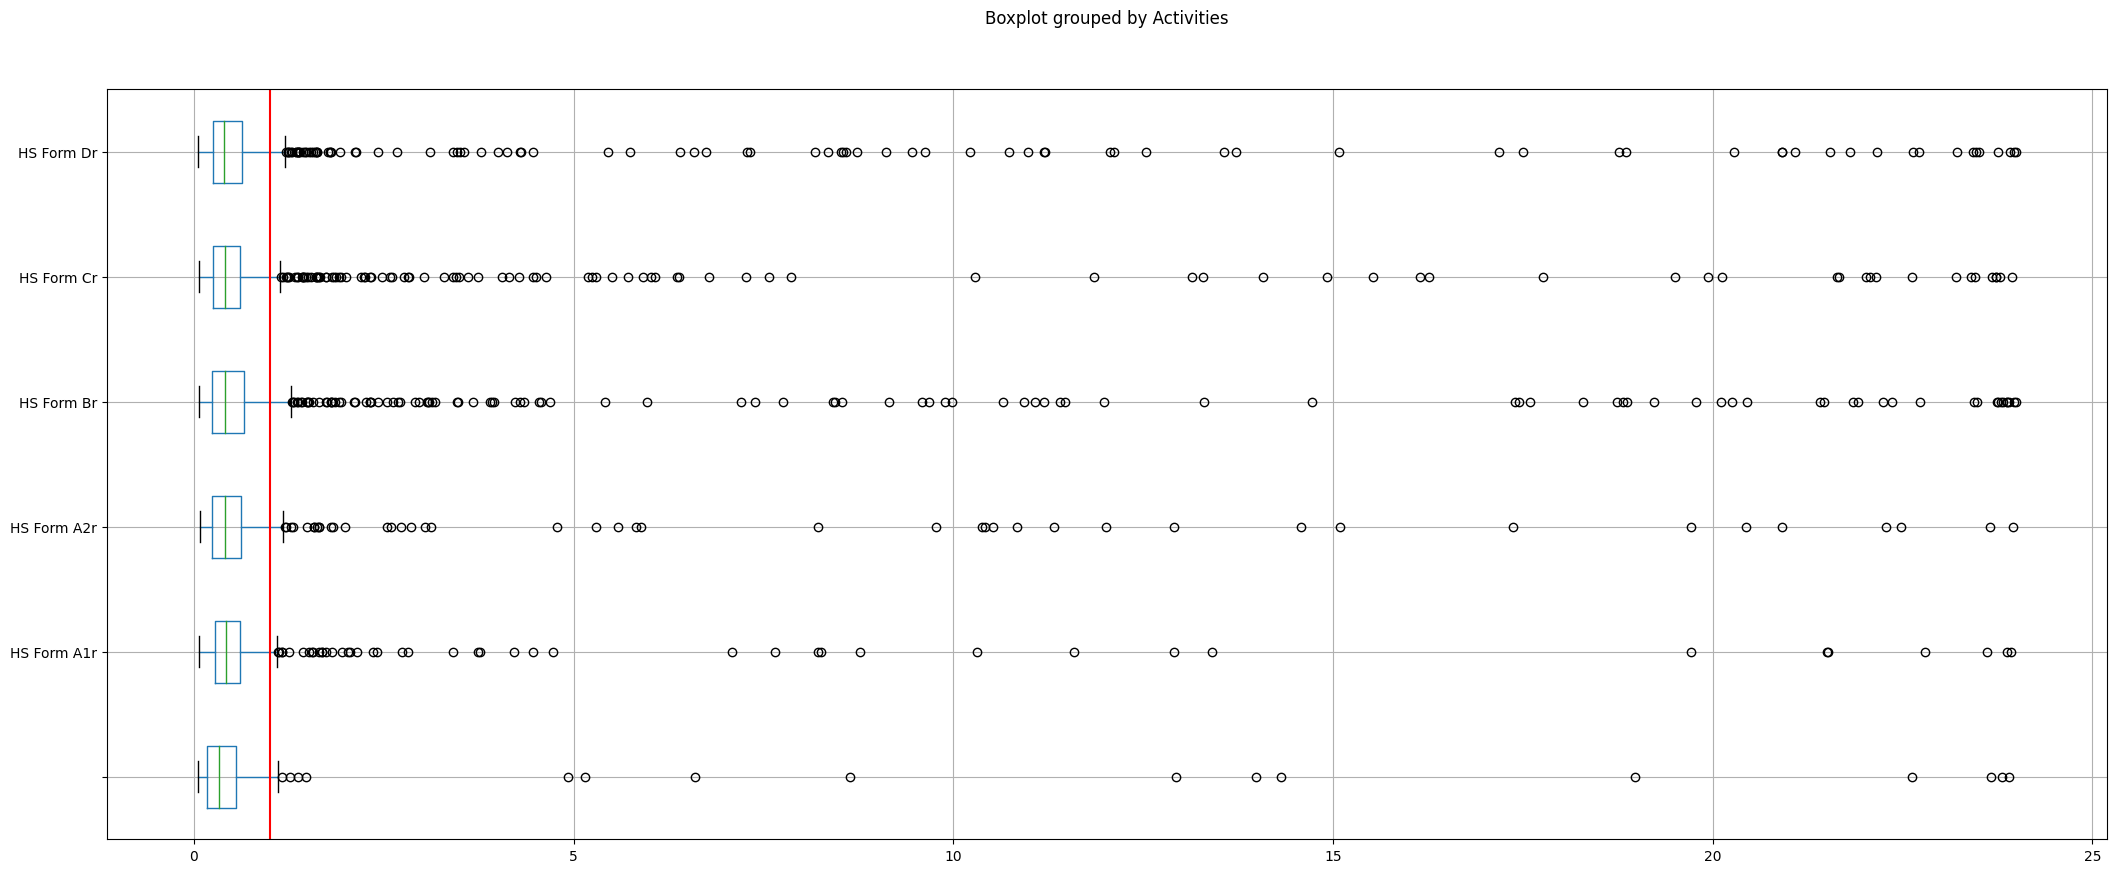

In [ ]:
just_act_and_ct.boxplot(column = 'Completion_Time', by = 'Activities', figsize=(25,10), vert=False)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.axvline(1, color = 'r')
plt.rcParams.update({'font.size': 15})
plt.show()

In [ ]:
paused_subset = completed_subset[completed_subset['Action'].isin(['Begin activity Spring 2024 HS DDM Administration',
                                                                  'Pause activity Spring 2024 HS DDM Administration',
                                                                  'Continue activity Spring 2024 HS DDM Administration',
                                                                  'End activity Spring 2024 HS DDM Administration'])].reset_index(drop = True)
paused_subset.head(10)

,Assignment,Activities,Date,Time,Action,Datetime
0,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:21:49.642,Begin activity Spring 2024 HS DDM Administration,2024-05-09 16:21:49.642
1,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:48:46.847,End activity Spring 2024 HS DDM Administration,2024-05-09 16:48:46.847
2,114141,Spr 24 DDM HS Form Cr,05/17/2024,10:35:38.233,Begin activity Spring 2024 HS DDM Administration,2024-05-17 10:35:38.233
3,114141,Spr 24 DDM HS Form Cr,05/17/2024,10:40:31.054,End activity Spring 2024 HS DDM Administration,2024-05-17 10:40:31.054
4,101122,Spr 24 DDM HS Form Dr,04/23/2024,20:02:23.761,Begin activity Spring 2024 HS DDM Administration,2024-04-23 20:02:23.761
5,101122,Spr 24 DDM HS Form Dr,04/23/2024,20:29:00.605,End activity Spring 2024 HS DDM Administration,2024-04-23 20:29:00.605
6,100177,Spr 24 DDM HS Form A1r,04/17/2024,11:07:56.272,Begin activity Spring 2024 HS DDM Administration,2024-04-17 11:07:56.272
7,100177,Spr 24 DDM HS Form A1r,04/17/2024,11:42:52.288,End activity Spring 2024 HS DDM Administration,2024-04-17 11:42:52.288
8,100189,Spr 24 DDM HS Form Cr,04/17/2024,11:05:57.978,Begin activity Spring 2024 HS DDM Administration,2024-04-17 11:05:57.978
9,100189,Spr 24 DDM HS Form Cr,04/17/2024,11:14:09.454,End activity Spring 2024 HS DDM Administration,2024-04-17 11:14:09.454


## Calculatin Completion Time: Number of Students Who Paused

In [ ]:
# of students who paused but still completed activity
paused_students = completed_subset[completed_subset["Action"] == "Pause activity Spring 2024 HS DDM Administration"]
paused_students

,Assignment,Activities,Date,Time,Action,Datetime
507,97017,Spr 24 DDM HS Form Dr,04/24/2024,06:58:10.231,Pause activity Spring 2024 HS DDM Administration,2024-04-24 06:58:10.231
1283,110361,Spr 24 DDM HS Form Dr,04/17/2024,12:11:46.592,Pause activity Spring 2024 HS DDM Administration,2024-04-17 12:11:46.592
1290,110361,Spr 24 DDM HS Form Dr,04/17/2024,12:14:51.259,Pause activity Spring 2024 HS DDM Administration,2024-04-17 12:14:51.259
2033,112175,Spr 24 DDM HS Form A2r,04/17/2024,12:37:57.080,Pause activity Spring 2024 HS DDM Administration,2024-04-17 12:37:57.080
2359,96503,Spr 24 DDM HS Form Br,04/23/2024,08:14:51.568,Pause activity Spring 2024 HS DDM Administration,2024-04-23 08:14:51.568
...,...,...,...,...,...,...
325650,112366,Spr 24 DDM HS Form Dr,05/08/2024,05:17:32.681,Pause activity Spring 2024 HS DDM Administration,2024-05-08 05:17:32.681
326160,99856,Spr 24 DDM HS Form Dr,04/18/2024,06:55:48.494,Pause activity Spring 2024 HS DDM Administration,2024-04-18 06:55:48.494
326164,99856,Spr 24 DDM HS Form Dr,04/24/2024,08:27:21.042,Pause activity Spring 2024 HS DDM Administration,2024-04-24 08:27:21.042
326171,99856,Spr 24 DDM HS Form Dr,05/01/2024,08:26:55.385,Pause activity Spring 2024 HS DDM Administration,2024-05-01 08:26:55.385


In [ ]:
#Assignment IDs for people who paused but still completed assignment
unique_pause = paused_students["Assignment"].unique()
unique_pause

array([ 97017, 110361, 112175,  96503,  97042,  97293, 112476,  99683,
       112247, 112255,  98128, 100672, 101104,  99936,  97902, 114173,
       100428,  97543, 100445, 110344, 100828,  97419,  96837,  97947,
        98133,  97311,  97314,  97301,  96651,  97307,  97749, 101247,
       109744, 109747,  99526, 112725,  98369, 112452, 101843, 112724,
       114198,  99049,  98964,  99412,  99416, 114210,  99164, 109787,
        99314,  98401,  98496, 113013, 100507,  98852, 100761, 101123,
       101950, 100715,  97925,  98040,  99612, 100716, 110466, 110516,
       101279, 101282, 113029, 101638, 109817, 101399,  99878,  99295,
       100694,  97645, 109837,  99929, 100740,  98517, 114228, 114227,
        99982,  98788,  96757, 112774,  99854,  98036,  99427, 100699,
       100251,  97888,  98879,  97657,  99762,  97652, 112777,  96576,
       110135, 101347, 110126,  99712,  98626, 101260, 112283,  99256,
        98604,  98605,  97158,  98146, 110122,  98243, 101829, 112541,
      

# Completion Time for students who did NOT pause

In [ ]:
ddm_df

,Assignment,Activities,Date,Time,Action,Datetime
0,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:21:49.642,Begin activity Spring 2024 HS DDM Administration,2024-05-09 16:21:49.642
1,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:21:50.014,Page 1 Loaded,2024-05-09 16:21:50.014
2,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:21:54.940,Page next clicked on page 1,2024-05-09 16:21:54.940
3,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:21:55.570,Page 2 Loaded,2024-05-09 16:21:55.570
4,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:22:03.887,Page next clicked on page 2,2024-05-09 16:22:03.887
...,...,...,...,...,...,...
327064,113718,Spr 24 DDM HS Form A1r,05/14/2024,11:34:49.190,Page 34 Loaded,2024-05-14 11:34:49.190
327065,113718,Spr 24 DDM HS Form A1r,05/14/2024,11:34:53.521,Page next clicked on page 34,2024-05-14 11:34:53.521
327066,113718,Spr 24 DDM HS Form A1r,05/14/2024,11:34:56.172,Page 35 Loaded,2024-05-14 11:34:56.172
327067,113718,Spr 24 DDM HS Form A1r,05/14/2024,11:35:01.128,Page next clicked on page 35,2024-05-14 11:35:01.128


In [ ]:
no_pause_ddm_df = ddm_df[~ddm_df["Assignment"].isin(unique_pause)].sort_values("Datetime", ascending = True)
no_pause_ddm_df

,Assignment,Activities,Date,Time,Action,Datetime
123469,101765,NaN,04/10/2024,09:15:19.673,Begin activity Spring 2024 HS DDM Administration,2024-04-10 09:15:19.673
123470,101765,NaN,04/10/2024,09:15:21.094,Page 1 Loaded,2024-04-10 09:15:21.094
123471,101765,NaN,04/10/2024,09:16:52.853,Page next clicked on page 1,2024-04-10 09:16:52.853
123472,101765,NaN,04/10/2024,09:16:55.054,Missing answers,2024-04-10 09:16:55.054
123473,101765,NaN,04/10/2024,09:19:03.244,Page next clicked on page 1,2024-04-10 09:19:03.244
...,...,...,...,...,...,...
109806,99287,Spr 24 DDM HS Form Cr,05/23/2024,13:20:44.176,Page 9 Loaded,2024-05-23 13:20:44.176
109807,99287,Spr 24 DDM HS Form Cr,05/23/2024,13:20:45.934,Page next clicked on page 9,2024-05-23 13:20:45.934
109808,99287,Spr 24 DDM HS Form Cr,05/23/2024,13:20:47.073,Missing answers,2024-05-23 13:20:47.073
109809,99287,Spr 24 DDM HS Form Cr,05/23/2024,13:21:04.439,Page next clicked on page 9,2024-05-23 13:21:04.439


In [ ]:
no_pause_ddm_df['Datetime'] = pd.to_datetime(no_pause_ddm_df['Datetime'])

# Filter to get rows where the action is 'Begin activity Spring 2024 HS DDM Administration'
begin_activities = no_pause_ddm_df[no_pause_ddm_df['Action'] == 'Begin activity Spring 2024 HS DDM Administration']

# Filter to get rows where the action is 'End activity Spring 2024 HS DDM Administration'
end_activities = no_pause_ddm_df[no_pause_ddm_df['Action'] == 'End activity Spring 2024 HS DDM Administration']

# Merge begin and end activities on 'Assignment'
activity_times = pd.merge(begin_activities, end_activities, on='Assignment', suffixes=('_begin', '_end'))

# Calculate the difference in minutes
activity_times['Duration_Minutes'] = (activity_times['Datetime_end'] - activity_times['Datetime_begin']).dt.total_seconds() / 60

# Create a result DataFrame with relevant information
no_result = activity_times[['Assignment','Datetime_begin', 'Datetime_end', 'Duration_Minutes']]
no_result

,Assignment,Datetime_begin,Datetime_end,Duration_Minutes
0,101765,2024-04-10 09:15:19.673,2024-04-11 09:25:26.817,1450.119067
1,98123,2024-04-10 11:09:25.922,2024-04-15 08:13:55.821,7024.498317
2,98136,2024-04-10 11:26:56.379,2024-04-22 10:15:13.367,17208.283133
3,98134,2024-04-10 11:34:46.349,2024-04-10 12:15:35.892,40.825717
4,98491,2024-04-10 12:08:42.550,2024-04-10 12:45:47.734,37.086400
...,...,...,...,...
3826,114513,2024-05-23 12:13:24.573,2024-05-23 12:21:53.462,8.481483
3827,110687,2024-05-23 12:13:28.202,2024-05-23 12:50:18.653,36.840850
3828,110682,2024-05-23 12:13:52.470,2024-05-23 12:29:56.616,16.069100
3829,110684,2024-05-23 12:16:28.563,2024-05-23 12:27:19.982,10.856983


In [ ]:
combined_results_df = pd.merge(no_result, no_pause_ddm_df[['Assignment', 'Activities']], on='Assignment', how='inner')

# Display the result
no_combined_result_df = combined_results_df.drop_duplicates()
no_combined_result_df

,Assignment,Datetime_begin,Datetime_end,Duration_Minutes,Activities
0,101765,2024-04-10 09:15:19.673,2024-04-11 09:25:26.817,1450.119067,NaN
58,98123,2024-04-10 11:09:25.922,2024-04-15 08:13:55.821,7024.498317,NaN
124,98136,2024-04-10 11:26:56.379,2024-04-22 10:15:13.367,17208.283133,NaN
193,98134,2024-04-10 11:34:46.349,2024-04-10 12:15:35.892,40.825717,NaN
251,98491,2024-04-10 12:08:42.550,2024-04-10 12:45:47.734,37.086400,NaN
...,...,...,...,...,...
280825,114513,2024-05-23 12:13:24.573,2024-05-23 12:21:53.462,8.481483,Spr 24 DDM HS Form A1r
280901,110687,2024-05-23 12:13:28.202,2024-05-23 12:50:18.653,36.840850,Spr 24 DDM HS Form A1r
280984,110682,2024-05-23 12:13:52.470,2024-05-23 12:29:56.616,16.069100,Spr 24 DDM HS Form A1r
281077,110684,2024-05-23 12:16:28.563,2024-05-23 12:27:19.982,10.856983,Spr 24 DDM HS Form Cr


In [ ]:
results_df = no_combined_result_df.drop_duplicates()
modified_results_df = results_df[["Assignment", "Activities", "Duration_Minutes"]]
modified_results_df['Duration_Minutes'] = pd.to_timedelta(modified_results_df['Duration_Minutes'], unit='m')
modified_results_df

<ipython-input-35-2db1ef05d72e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_results_df['Duration_Minutes'] = pd.to_timedelta(modified_results_df['Duration_Minutes'], unit='m')


,Assignment,Activities,Duration_Minutes
0,101765,NaN,1 days 00:10:07.144000002
58,98123,NaN,4 days 21:04:29.899000002
124,98136,NaN,11 days 22:48:16.987999998
193,98134,NaN,0 days 00:40:49.543000002
251,98491,NaN,0 days 00:37:05.184000
...,...,...,...
280825,114513,Spr 24 DDM HS Form A1r,0 days 00:08:28.888999998
280901,110687,Spr 24 DDM HS Form A1r,0 days 00:36:50.451000
280984,110682,Spr 24 DDM HS Form A1r,0 days 00:16:04.145999999
281077,110684,Spr 24 DDM HS Form Cr,0 days 00:10:51.418999998


In [ ]:
modified_day_limit = modified_results_df[modified_results_df['Duration_Minutes'] <= pd.Timedelta(days=1)]
modified_day_limit

,Assignment,Activities,Duration_Minutes
193,98134,NaN,0 days 00:40:49.543000002
251,98491,NaN,0 days 00:37:05.184000
307,98492,NaN,0 days 00:26:50.359000002
365,98482,NaN,0 days 00:55:09.003000
423,98483,NaN,0 days 00:27:11.241000
...,...,...,...
280825,114513,Spr 24 DDM HS Form A1r,0 days 00:08:28.888999998
280901,110687,Spr 24 DDM HS Form A1r,0 days 00:36:50.451000
280984,110682,Spr 24 DDM HS Form A1r,0 days 00:16:04.145999999
281077,110684,Spr 24 DDM HS Form Cr,0 days 00:10:51.418999998


In [ ]:
def format_duration(td):
    total_minutes = td.total_seconds() / 60
    hours = int(total_minutes // 60)
    minutes = int(total_minutes % 60)
    return f"{hours}h {minutes}m"

# Apply the formatting function to the Duration_Minutes column
modified_day_limit['Formatted_Duration'] = modified_day_limit['Duration_Minutes'].apply(format_duration)

modified_day_limit[['Assignment', 'Activities', 'Formatted_Duration']]

<ipython-input-37-350f122f2445>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_day_limit['Formatted_Duration'] = modified_day_limit['Duration_Minutes'].apply(format_duration)


,Assignment,Activities,Formatted_Duration
193,98134,NaN,0h 40m
251,98491,NaN,0h 37m
307,98492,NaN,0h 26m
365,98482,NaN,0h 55m
423,98483,NaN,0h 27m
...,...,...,...
280825,114513,Spr 24 DDM HS Form A1r,0h 8m
280901,110687,Spr 24 DDM HS Form A1r,0h 36m
280984,110682,Spr 24 DDM HS Form A1r,0h 16m
281077,110684,Spr 24 DDM HS Form Cr,0h 10m


## Completion Time DF FOR NO PAUSE STUDENTS

In [ ]:
sorted_modified_day_limit = modified_day_limit.sort_values('Formatted_Duration', ascending = False)
sorted_modified_day_limit

,Assignment,Activities,Duration_Minutes,Formatted_Duration
62695,100454,Spr 24 DDM HS Form Dr,0 days 09:06:52.656000,9h 6m
166725,113553,Spr 24 DDM HS Form Br,0 days 09:58:57.681000,9h 58m
164064,99986,Spr 24 DDM HS Form Br,0 days 09:41:09.606000,9h 41m
72073,97856,Spr 24 DDM HS Form Br,0 days 09:35:21.118000002,9h 35m
75137,97854,Spr 24 DDM HS Form Dr,0 days 09:27:43.990000002,9h 27m
...,...,...,...,...
122933,113261,Spr 24 DDM HS Form Br,0 days 00:10:02.413999998,0h 10m
120795,99825,Spr 24 DDM HS Form Br,0 days 00:10:25.560000,0h 10m
274002,101902,Spr 24 DDM HS Form A1r,0 days 00:10:49.557000,0h 10m
118100,100158,Spr 24 DDM HS Form Cr,0 days 00:10:35.200999998,0h 10m


In [ ]:
pause_ddm_df = ddm_df[ddm_df["Assignment"].isin(unique_pause)].sort_values("Datetime", ascending = True)
pause_ddm_df

,Assignment,Activities,Date,Time,Action,Datetime
101091,98146,NaN,04/10/2024,11:20:22.908,Begin activity Spring 2024 HS DDM Administration,2024-04-10 11:20:22.908
101092,98146,NaN,04/10/2024,11:20:23.157,Page 1 Loaded,2024-04-10 11:20:23.157
101093,98146,NaN,04/10/2024,11:21:21.399,Page next clicked on page 1,2024-04-10 11:21:21.399
101094,98146,NaN,04/10/2024,11:21:22.220,Page 2 Loaded,2024-04-10 11:21:22.220
101095,98146,NaN,04/10/2024,11:21:29.304,Pause activity Spring 2024 HS DDM Administration,2024-04-10 11:21:29.304
...,...,...,...,...,...,...
249305,98804,Spr 24 DDM HS Form A1r,05/23/2024,09:46:51.138,Page 34 Loaded,2024-05-23 09:46:51.138
249306,98804,Spr 24 DDM HS Form A1r,05/23/2024,09:46:58.086,Page next clicked on page 34,2024-05-23 09:46:58.086
249307,98804,Spr 24 DDM HS Form A1r,05/23/2024,09:46:59.943,Page 35 Loaded,2024-05-23 09:46:59.943
249308,98804,Spr 24 DDM HS Form A1r,05/23/2024,09:47:05.271,Page next clicked on page 35,2024-05-23 09:47:05.271


In [ ]:
pause_actions = pause_ddm_df[pause_ddm_df['Action'] == "Pause activity Spring 2024 HS DDM Administration"]

# Step 2: Group by 'Assignment' and count the occurrences
pause_counts = pause_actions.groupby('Assignment').size()

assignments_with_multiple_pauses = pause_counts[pause_counts >= 2].index.tolist()
assignments_with_multiple_pauses

[96576,
 96695,
 96789,
 96833,
 96885,
 96923,
 97020,
 97042,
 97262,
 97314,
 97331,
 97419,
 97539,
 97861,
 97919,
 97947,
 97948,
 98112,
 98113,
 98127,
 98133,
 98228,
 98369,
 98449,
 98526,
 98563,
 98598,
 98613,
 98804,
 99336,
 99402,
 99427,
 99680,
 99856,
 99878,
 99936,
 100012,
 100057,
 100286,
 100428,
 100438,
 100458,
 100504,
 100520,
 100681,
 100858,
 101123,
 101154,
 101185,
 101222,
 101247,
 101279,
 101282,
 101416,
 101950,
 110361,
 112306,
 112366,
 112563,
 112777,
 112890,
 112973,
 113029,
 113120,
 113223,
 113295,
 113548,
 113555,
 113656,
 113836,
 114173,
 114275]

In [ ]:
one_pause_ddm_df = pause_ddm_df[~pause_ddm_df['Assignment'].isin(assignments_with_multiple_pauses)]
one_pause_ddm_df

,Assignment,Activities,Date,Time,Action,Datetime
101091,98146,NaN,04/10/2024,11:20:22.908,Begin activity Spring 2024 HS DDM Administration,2024-04-10 11:20:22.908
101092,98146,NaN,04/10/2024,11:20:23.157,Page 1 Loaded,2024-04-10 11:20:23.157
101093,98146,NaN,04/10/2024,11:21:21.399,Page next clicked on page 1,2024-04-10 11:21:21.399
101094,98146,NaN,04/10/2024,11:21:22.220,Page 2 Loaded,2024-04-10 11:21:22.220
101095,98146,NaN,04/10/2024,11:21:29.304,Pause activity Spring 2024 HS DDM Administration,2024-04-10 11:21:29.304
...,...,...,...,...,...,...
199886,98832,Spr 24 DDM HS Form Br,05/23/2024,09:38:04.760,Page 32 Loaded,2024-05-23 09:38:04.760
199887,98832,Spr 24 DDM HS Form Br,05/23/2024,09:38:41.205,Page next clicked on page 32,2024-05-23 09:38:41.205
199888,98832,Spr 24 DDM HS Form Br,05/23/2024,09:38:44.454,Page 33 Loaded,2024-05-23 09:38:44.454
199889,98832,Spr 24 DDM HS Form Br,05/23/2024,09:39:08.519,Page next clicked on page 33,2024-05-23 09:39:08.519


# REFINED WAY TO CALCULATE DIFFERENCE BETWEEN PAUSE AND CONTINUE

In [ ]:
import pandas as pd
from datetime import timedelta

# Assuming 'one_pause_ddm_df' is already defined and sorted by 'Assignment' and 'Datetime'

# Step 1: Sort the DataFrame by 'Assignment' and 'Datetime'
one_pause_ddm_df.sort_values(by=['Assignment', 'Datetime'], inplace=True)

# Step 2: Initialize an empty DataFrame to store results
results = pd.DataFrame(columns=['Assignment', 'Pause_Datetime', 'Continue_Datetime', 'Time_Difference'])

# Step 3: Iterate through each assignment group
for assignment, group in one_pause_ddm_df.groupby('Assignment'):
    # Iterate through each row in the group
    iter_group = iter(group.iterrows())
    for idx, row in iter_group:
        if row['Action'].startswith('Pause'):
            # Capture pause datetime
            pause_datetime = row['Datetime']

            # Look for the next continue activity
            try:
                next_idx, next_row = next(iter_group)
                if next_row['Action'].startswith('Continue'):
                    continue_datetime = next_row['Datetime']

                    # Calculate time difference
                    time_difference = continue_datetime - pause_datetime

                    # Append to results DataFrame
                    results = pd.concat([results, pd.DataFrame({
                        'Assignment': [assignment],
                        'Pause_Datetime': [pause_datetime],
                        'Continue_Datetime': [continue_datetime],
                        'Time_Difference': [time_difference]
                    })], ignore_index=True)
            except StopIteration:
                # No more rows in group
                pass

# Step 4: Display or use the results DataFrame as needed
results



<ipython-input-42-84ead8b00e24>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_pause_ddm_df.sort_values(by=['Assignment', 'Datetime'], inplace=True)
<ipython-input-42-84ead8b00e24>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({


,Assignment,Pause_Datetime,Continue_Datetime,Time_Difference
0,96503,2024-04-23 08:14:51.568,2024-04-24 07:14:02.309,0 days 22:59:10.741000
1,96504,2024-04-17 20:37:13.474,2024-04-18 12:20:08.005,0 days 15:42:54.531000
2,96512,2024-05-07 10:46:36.914,2024-05-07 10:47:22.916,0 days 00:00:46.002000
3,96597,2024-05-21 07:33:51.571,2024-05-21 07:33:58.537,0 days 00:00:06.966000
4,96704,2024-05-08 11:37:08.249,2024-05-08 11:38:26.782,0 days 00:01:18.533000
...,...,...,...,...
282,114269,2024-05-20 11:50:24.117,2024-05-20 11:50:31.562,0 days 00:00:07.445000
283,114295,2024-05-20 13:53:55.813,2024-05-20 20:46:06.581,0 days 06:52:10.768000
284,114334,2024-05-21 07:16:46.827,2024-05-21 07:16:50.539,0 days 00:00:03.712000
285,114360,2024-05-21 10:07:11.823,2024-05-21 11:55:50.334,0 days 01:48:38.511000


In [ ]:
results['Pause_Datetime'] = pd.to_datetime(results['Pause_Datetime'])
results['Continue_Datetime'] = pd.to_datetime(results['Continue_Datetime'])

# Calculate time difference in minutes
results['Time_Difference_minutes'] = (results['Continue_Datetime'] - results['Pause_Datetime']).dt.total_seconds() / 60.0

# Display the results
one_pause_new_df = results[['Assignment', 'Pause_Datetime', 'Continue_Datetime', 'Time_Difference_minutes']]
one_pause_new_df

,Assignment,Pause_Datetime,Continue_Datetime,Time_Difference_minutes
0,96503,2024-04-23 08:14:51.568,2024-04-24 07:14:02.309,1379.179017
1,96504,2024-04-17 20:37:13.474,2024-04-18 12:20:08.005,942.908850
2,96512,2024-05-07 10:46:36.914,2024-05-07 10:47:22.916,0.766700
3,96597,2024-05-21 07:33:51.571,2024-05-21 07:33:58.537,0.116100
4,96704,2024-05-08 11:37:08.249,2024-05-08 11:38:26.782,1.308883
...,...,...,...,...
282,114269,2024-05-20 11:50:24.117,2024-05-20 11:50:31.562,0.124083
283,114295,2024-05-20 13:53:55.813,2024-05-20 20:46:06.581,412.179467
284,114334,2024-05-21 07:16:46.827,2024-05-21 07:16:50.539,0.061867
285,114360,2024-05-21 10:07:11.823,2024-05-21 11:55:50.334,108.641850


In [ ]:
one_pause_ddm_df['Datetime'] = pd.to_datetime(one_pause_ddm_df['Datetime'])

# Filter to get rows where the action is 'Begin activity Spring 2024 HS DDM Administration'
begin_activities = one_pause_ddm_df[one_pause_ddm_df['Action'] == 'Begin activity Spring 2024 HS DDM Administration']

# Filter to get rows where the action is 'End activity Spring 2024 HS DDM Administration'
end_activities = one_pause_ddm_df[one_pause_ddm_df['Action'] == 'End activity Spring 2024 HS DDM Administration']

# Merge begin and end activities on 'Assignment'
activity_times = pd.merge(begin_activities, end_activities, on='Assignment', suffixes=('_begin', '_end'))

# Calculate the difference in minutes
activity_times['Duration_Minutes'] = (activity_times['Datetime_end'] - activity_times['Datetime_begin']).dt.total_seconds() / 60

# Create a result DataFrame with relevant information
result = activity_times[['Assignment','Datetime_begin', 'Datetime_end', 'Duration_Minutes']]
result

<ipython-input-44-4391b44b169d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_pause_ddm_df['Datetime'] = pd.to_datetime(one_pause_ddm_df['Datetime'])


,Assignment,Datetime_begin,Datetime_end,Duration_Minutes
0,96503,2024-04-23 08:12:58.222,2024-04-24 07:39:28.283,1406.501017
1,96504,2024-04-17 20:29:21.536,2024-04-18 12:45:21.834,976.004967
2,96512,2024-05-07 10:34:46.841,2024-05-08 08:25:42.257,1310.923600
3,96597,2024-05-21 07:12:52.652,2024-05-21 08:06:35.373,53.712017
4,96651,2024-05-16 06:05:19.001,2024-05-20 07:57:46.372,5872.456183
...,...,...,...,...
312,114295,2024-05-20 13:53:29.470,2024-05-20 21:10:23.128,436.894300
313,114301,2024-05-20 14:45:42.834,2024-05-20 15:19:00.258,33.290400
314,114334,2024-05-21 06:52:15.206,2024-05-21 07:23:01.233,30.767117
315,114360,2024-05-21 08:15:37.584,2024-05-21 12:12:38.705,237.018683


In [ ]:
#CORRECTED COMPLETION TIME DATAFRAME HERE: ONE PAUSE
one_merged_df = pd.merge(one_pause_new_df, result, on="Assignment")
one_merged_df

,Assignment,Pause_Datetime,Continue_Datetime,Time_Difference_minutes,Datetime_begin,Datetime_end,Duration_Minutes
0,96503,2024-04-23 08:14:51.568,2024-04-24 07:14:02.309,1379.179017,2024-04-23 08:12:58.222,2024-04-24 07:39:28.283,1406.501017
1,96504,2024-04-17 20:37:13.474,2024-04-18 12:20:08.005,942.908850,2024-04-17 20:29:21.536,2024-04-18 12:45:21.834,976.004967
2,96512,2024-05-07 10:46:36.914,2024-05-07 10:47:22.916,0.766700,2024-05-07 10:34:46.841,2024-05-08 08:25:42.257,1310.923600
3,96597,2024-05-21 07:33:51.571,2024-05-21 07:33:58.537,0.116100,2024-05-21 07:12:52.652,2024-05-21 08:06:35.373,53.712017
4,96704,2024-05-08 11:37:08.249,2024-05-08 11:38:26.782,1.308883,2024-05-08 11:11:59.908,2024-05-08 12:17:57.304,65.956600
...,...,...,...,...,...,...,...
282,114269,2024-05-20 11:50:24.117,2024-05-20 11:50:31.562,0.124083,2024-05-20 11:44:24.784,2024-05-20 12:01:59.740,17.582600
283,114295,2024-05-20 13:53:55.813,2024-05-20 20:46:06.581,412.179467,2024-05-20 13:53:29.470,2024-05-20 21:10:23.128,436.894300
284,114334,2024-05-21 07:16:46.827,2024-05-21 07:16:50.539,0.061867,2024-05-21 06:52:15.206,2024-05-21 07:23:01.233,30.767117
285,114360,2024-05-21 10:07:11.823,2024-05-21 11:55:50.334,108.641850,2024-05-21 08:15:37.584,2024-05-21 12:12:38.705,237.018683


## DATAFRAME FOR COMPLETION TIME OF STUDENTS WHO PAUSED ONCE

In [ ]:
#CORRECTED COMPLETION TIME DATAFRAME HERE: ONE PAUSE
one_merged_df["Corrected_Completion_Time"] = one_merged_df["Duration_Minutes"] - one_merged_df["Time_Difference_minutes"]
sorted_one_merged_df = one_merged_df.sort_values("Corrected_Completion_Time", ascending = False)
sorted_one_merged_df

,Assignment,Pause_Datetime,Continue_Datetime,Time_Difference_minutes,Datetime_begin,Datetime_end,Duration_Minutes,Corrected_Completion_Time
209,109817,2024-04-12 07:26:17.517,2024-04-12 07:26:38.062,0.342417,2024-04-12 07:26:10.907,2024-05-15 08:01:05.095,47554.903133,47554.560717
163,100602,2024-04-26 10:11:22.869,2024-04-26 10:11:27.717,0.080800,2024-04-19 09:56:47.031,2024-05-15 10:10:35.532,37453.808350,37453.727550
245,112560,2024-05-20 08:01:46.228,2024-05-20 09:39:19.247,97.550317,2024-04-24 10:03:33.425,2024-05-20 09:45:10.393,37421.616133,37324.065817
246,112570,2024-05-17 07:55:54.826,2024-05-17 07:55:57.002,0.036267,2024-04-24 16:30:11.780,2024-05-17 08:10:00.644,32619.814400,32619.778133
68,98132,2024-04-23 07:03:19.533,2024-04-23 07:49:13.733,45.903333,2024-04-23 06:42:13.997,2024-05-07 08:01:45.130,20239.518883,20193.615550
...,...,...,...,...,...,...,...,...
23,97028,2024-04-17 18:42:18.532,2024-04-17 18:42:24.935,0.106717,2024-04-17 18:41:42.250,2024-04-17 18:49:23.046,7.679933,7.573217
127,99762,2024-05-21 09:44:18.620,2024-05-21 09:44:36.115,0.291583,2024-05-21 09:43:50.692,2024-05-21 09:51:17.861,7.452817,7.161233
87,98614,2024-05-14 07:30:39.258,2024-05-14 07:30:52.508,0.220833,2024-05-14 07:27:19.442,2024-05-14 07:34:37.908,7.307767,7.086933
274,113903,2024-05-15 13:15:12.134,2024-05-15 13:15:14.680,0.042433,2024-05-15 13:12:59.802,2024-05-15 13:19:00.245,6.007383,5.964950


In [ ]:
one_filtered_df = sorted_one_merged_df[sorted_one_merged_df['Corrected_Completion_Time'] < 1000]
one_filtered_df

,Assignment,Pause_Datetime,Continue_Datetime,Time_Difference_minutes,Datetime_begin,Datetime_end,Duration_Minutes,Corrected_Completion_Time
57,97925,2024-04-22 18:22:46.970,2024-04-23 19:50:35.762,1527.813200,2024-04-22 18:06:43.245,2024-04-24 06:50:42.251,2203.983433,676.170233
20,97017,2024-04-24 06:58:10.231,2024-04-24 07:01:26.382,3.269183,2024-04-23 20:49:42.538,2024-04-24 07:02:52.926,613.173133,609.903950
227,110505,2024-05-16 11:09:39.094,2024-05-16 11:09:49.270,0.169600,2024-05-16 11:09:35.445,2024-05-16 20:56:14.269,586.647067,586.477467
55,97902,2024-04-22 12:53:44.784,2024-04-23 11:54:46.172,1381.023133,2024-04-22 12:18:36.836,2024-04-23 19:49:24.883,1890.800783,509.777650
185,101187,2024-04-24 14:23:22.347,2024-04-24 14:23:30.849,0.141700,2024-04-24 06:37:03.607,2024-04-24 14:50:23.740,493.335550,493.193850
...,...,...,...,...,...,...,...,...
23,97028,2024-04-17 18:42:18.532,2024-04-17 18:42:24.935,0.106717,2024-04-17 18:41:42.250,2024-04-17 18:49:23.046,7.679933,7.573217
127,99762,2024-05-21 09:44:18.620,2024-05-21 09:44:36.115,0.291583,2024-05-21 09:43:50.692,2024-05-21 09:51:17.861,7.452817,7.161233
87,98614,2024-05-14 07:30:39.258,2024-05-14 07:30:52.508,0.220833,2024-05-14 07:27:19.442,2024-05-14 07:34:37.908,7.307767,7.086933
274,113903,2024-05-15 13:15:12.134,2024-05-15 13:15:14.680,0.042433,2024-05-15 13:12:59.802,2024-05-15 13:19:00.245,6.007383,5.964950


In [ ]:
combined_result_df = pd.merge(one_filtered_df, one_pause_ddm_df[['Assignment', 'Activities']], on='Assignment', how='inner')

# Display the result
combined_result_df = combined_result_df.drop_duplicates()
modified_combined_result_df = combined_result_df[["Assignment", "Activities", "Corrected_Completion_Time"]]
modified_combined_result_df['Corrected_Completion_Time'] = pd.to_timedelta(modified_combined_result_df['Corrected_Completion_Time'], unit='m')
modified_combined_result_df

<ipython-input-48-87f17e404c72>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_combined_result_df['Corrected_Completion_Time'] = pd.to_timedelta(modified_combined_result_df['Corrected_Completion_Time'], unit='m')


,Assignment,Activities,Corrected_Completion_Time
0,97925,Spr 24 DDM HS Form Dr,0 days 11:16:10.213999998
77,97017,Spr 24 DDM HS Form Dr,0 days 10:09:54.237000
154,110505,Spr 24 DDM HS Form A2r,0 days 09:46:28.648000002
230,97902,Spr 24 DDM HS Form Dr,0 days 08:29:46.659000
307,101187,Spr 24 DDM HS Form A2r,0 days 08:13:11.631000
...,...,...,...
18344,97028,Spr 24 DDM HS Form Dr,0 days 00:07:34.393000002
18417,99762,Spr 24 DDM HS Form Br,0 days 00:07:09.673999998
18488,98614,Spr 24 DDM HS Form Dr,0 days 00:07:05.215999998
18559,113903,Spr 24 DDM HS Form Cr,0 days 00:05:57.897000


In [ ]:
def format_duration(td):
    total_minutes = td.total_seconds() / 60
    hours = int(total_minutes // 60)
    minutes = int(total_minutes % 60)
    return f"{hours}h {minutes}m"

# Apply the formatting function to the Corrected_Completion_Time column
modified_combined_result_df['Formatted_Completion_Time'] = modified_combined_result_df['Corrected_Completion_Time'].apply(format_duration)

# Display the DataFrame with the formatted completion time
modified_combined_result_df[['Assignment', 'Activities', 'Formatted_Completion_Time']]

<ipython-input-49-793f4c386d70>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_combined_result_df['Formatted_Completion_Time'] = modified_combined_result_df['Corrected_Completion_Time'].apply(format_duration)


,Assignment,Activities,Formatted_Completion_Time
0,97925,Spr 24 DDM HS Form Dr,11h 16m
77,97017,Spr 24 DDM HS Form Dr,10h 9m
154,110505,Spr 24 DDM HS Form A2r,9h 46m
230,97902,Spr 24 DDM HS Form Dr,8h 29m
307,101187,Spr 24 DDM HS Form A2r,8h 13m
...,...,...,...
18344,97028,Spr 24 DDM HS Form Dr,0h 7m
18417,99762,Spr 24 DDM HS Form Br,0h 7m
18488,98614,Spr 24 DDM HS Form Dr,0h 7m
18559,113903,Spr 24 DDM HS Form Cr,0h 5m


## SUMMARY TABLE FOR ONE PAUSE DF

In [ ]:
modified_ave_per_act = modified_combined_result_df.groupby('Activities')[['Corrected_Completion_Time']].describe()
modified_ave_per_act = modified_ave_per_act.astype(str)
modified_ave_per_act[('Corrected_Completion_Time','mean')] = [x[7:-7] for x in modified_ave_per_act[('Corrected_Completion_Time','mean')]]
modified_ave_per_act[('Corrected_Completion_Time','std')] = [x[7:-10] for x in modified_ave_per_act[('Corrected_Completion_Time','std')]]
modified_ave_per_act[('Corrected_Completion_Time','min')] = [x[7:-7] for x in modified_ave_per_act[('Corrected_Completion_Time','min')]]
modified_ave_per_act[('Corrected_Completion_Time','25%')] = [x[7:-7] for x in modified_ave_per_act[('Corrected_Completion_Time','25%')]]
modified_ave_per_act[('Corrected_Completion_Time','50%')] = [x[7:-7] for x in modified_ave_per_act[('Corrected_Completion_Time','50%')]]
modified_ave_per_act[('Corrected_Completion_Time','75%')] = [x[7:-7] for x in modified_ave_per_act[('Corrected_Completion_Time','75%')]]
modified_ave_per_act[('Corrected_Completion_Time','max')] = [x[7:-7] for x in modified_ave_per_act[('Corrected_Completion_Time','max')]]

modified_ave_per_act

Corrected_Completion_Time                         \
                                           count         mean       std   
Activities                                                                
Spr 24 DDM HS Form A1r                        28  00:45:19.04  00:25:56   
Spr 24 DDM HS Form A2r                        33  01:19:17.66  02:07:59   
Spr 24 DDM HS Form Br                         58  00:51:44.22  01:08:55   
Spr 24 DDM HS Form Cr                         66  00:52:45.90  01:10:57   
Spr 24 DDM HS Form Dr                         55  01:07:40.40  02:11:40   

                                                                            \
                                min          25%          50%          75%   
Activities                                                                   
Spr 24 DDM HS Form A1r     00:13:55  00:28:07.41     00:38:38     00:53:06   
Spr 24 DDM HS Form A2r     00:08:40  00:28:32.88     00:38:56  00:55:30.61   
Spr 24 DDM HS Form Br   00:05:55.06  00:24:45.71  00:35:35.02  00:46:52.08   
Spr 24 DDM HS Form Cr      00:05:57  00:22:08.76  00:33:02.00  00:50:40.68   
Spr 24 DDM HS Form Dr   00:07:05.21  00:21:54.35     00:32:54  00:49:23.58   

                                     
                                max  
Activities                           
Spr 24 DDM HS Form A1r  01:51:07.93  
Spr 24 DDM HS Form A2r  09:46:28.64  
Spr 24 DDM HS Form Br      08:11:11  
Spr 24 DDM HS Form Cr   06:52:57.96  
Spr 24 DDM HS Form Dr   11:16:10.21

# Two Pauses or More Completion Time Calculation

In [ ]:
two_pause_ddm_df = pause_ddm_df[pause_ddm_df['Assignment'].isin(assignments_with_multiple_pauses)]
two_pause_ddm_df

,Assignment,Activities,Date,Time,Action,Datetime
154279,100858,NaN,04/10/2024,17:39:58.604,Begin activity Spring 2024 HS DDM Administration,2024-04-10 17:39:58.604
154280,100858,NaN,04/10/2024,17:39:59.798,Page 1 Loaded,2024-04-10 17:39:59.798
154281,100858,NaN,04/10/2024,17:40:31.337,Page next clicked on page 1,2024-04-10 17:40:31.337
154282,100858,NaN,04/10/2024,17:40:33.461,Page 2 Loaded,2024-04-10 17:40:33.461
154283,100858,NaN,04/10/2024,17:43:45.724,Page next clicked on page 2,2024-04-10 17:43:45.724
...,...,...,...,...,...,...
249305,98804,Spr 24 DDM HS Form A1r,05/23/2024,09:46:51.138,Page 34 Loaded,2024-05-23 09:46:51.138
249306,98804,Spr 24 DDM HS Form A1r,05/23/2024,09:46:58.086,Page next clicked on page 34,2024-05-23 09:46:58.086
249307,98804,Spr 24 DDM HS Form A1r,05/23/2024,09:46:59.943,Page 35 Loaded,2024-05-23 09:46:59.943
249308,98804,Spr 24 DDM HS Form A1r,05/23/2024,09:47:05.271,Page next clicked on page 35,2024-05-23 09:47:05.271


## DIFFERENCE BETWEEN PAUSE AND CONTINUE FOR INSTANCES OF TWO MORE MORE PAUSES

In [ ]:
import pandas as pd

# Assuming two_pause_ddm_df is your DataFrame containing pause and continue activities

# Convert 'Datetime' column to datetime format
two_pause_ddm_df['Datetime'] = pd.to_datetime(two_pause_ddm_df['Datetime'])

# Sort by 'Assignment' and 'Datetime' within each assignment
two_pause_ddm_df.sort_values(by=['Assignment', 'Datetime'], inplace=True)

# Initialize lists to store results
results = []

# Iterate over each unique Assignment
for assignment in two_pause_ddm_df['Assignment'].unique():
    # Filter data for the current assignment
    assignment_df = two_pause_ddm_df[two_pause_ddm_df['Assignment'] == assignment]

    # Initialize variables to store pause and continue times
    pause_time = None
    continue_time = None

    # Iterate through rows for the current assignment
    for index, row in assignment_df.iterrows():
        if 'Pause' in row['Action']:
            pause_time = row['Datetime']
        elif 'Continue' in row['Action']:
            if pause_time is not None:
                continue_time = row['Datetime']
                # Calculate time difference
                time_diff = continue_time - pause_time
                # Append result as a dictionary
                results.append({
                    'Assignment': assignment,
                    'Pause_Datetime': pause_time,
                    'Continue_Datetime': continue_time,
                    'Time_Difference_minutes': time_diff.total_seconds() / 60 # Store as minutes
                })
                # Reset pause_time to None for the next pause
                pause_time = None

# Convert results list to DataFrame
two_results_df = pd.DataFrame(results)

# Display the results DataFrame
two_results_df




<ipython-input-52-c08e80c94e5a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_pause_ddm_df['Datetime'] = pd.to_datetime(two_pause_ddm_df['Datetime'])
<ipython-input-52-c08e80c94e5a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_pause_ddm_df.sort_values(by=['Assignment', 'Datetime'], inplace=True)


,Assignment,Pause_Datetime,Continue_Datetime,Time_Difference_minutes
0,96576,2024-05-22 10:59:21.870,2024-05-22 11:21:21.381,21.991850
1,96576,2024-05-22 11:53:54.964,2024-05-22 11:54:01.289,0.105417
2,96695,2024-04-16 07:32:59.120,2024-04-16 07:34:21.619,1.374983
3,96695,2024-04-16 07:53:54.666,2024-05-07 18:26:15.112,30872.340767
4,96789,2024-05-05 09:43:23.963,2024-05-06 07:09:44.145,1286.336367
...,...,...,...,...
160,114173,2024-05-18 12:22:28.030,2024-05-19 09:25:31.457,1263.057117
161,114173,2024-05-19 09:29:55.671,2024-05-19 09:32:33.600,2.632150
162,114275,2024-05-20 12:22:26.778,2024-05-20 12:22:34.828,0.134167
163,114275,2024-05-20 13:06:20.181,2024-05-21 05:55:46.780,1009.443317


In [ ]:
grouped_two_df = two_results_df.groupby('Assignment')[['Time_Difference_minutes']].sum()
grouped_two_df

,Time_Difference_minutes
Assignment,
96576,22.097267
96695,30873.715750
96789,2737.411533
96833,1468.493450
96885,6.882033
...,...
113555,1423.710183
113656,1855.522050
113836,8533.194350


## FIGURE OUT TWO PAUSE TIME DIFFERENCES

In [ ]:
two_pause_ddm_df['Datetime'] = pd.to_datetime(two_pause_ddm_df['Datetime'])

# Filter to get rows where the action is 'Begin activity Spring 2024 HS DDM Administration'
begin_activities = two_pause_ddm_df[two_pause_ddm_df['Action'] == 'Begin activity Spring 2024 HS DDM Administration']

# Filter to get rows where the action is 'End activity Spring 2024 HS DDM Administration'
end_activities = two_pause_ddm_df[two_pause_ddm_df['Action'] == 'End activity Spring 2024 HS DDM Administration']

# Merge begin and end activities on 'Assignment'
activity_times = pd.merge(begin_activities, end_activities, on='Assignment', suffixes=('_begin', '_end'))

# Calculate the difference in minutes
activity_times['Duration_Minutes'] = (activity_times['Datetime_end'] - activity_times['Datetime_begin']).dt.total_seconds() / 60

# Create a result DataFrame with relevant information
result = activity_times[['Assignment', 'Datetime_begin', 'Datetime_end', 'Duration_Minutes']]
result

<ipython-input-54-e29d3e2a91ee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_pause_ddm_df['Datetime'] = pd.to_datetime(two_pause_ddm_df['Datetime'])


,Assignment,Datetime_begin,Datetime_end,Duration_Minutes
0,96576,2024-05-22 10:50:33.645,2024-05-22 11:54:45.482,64.197283
1,96695,2024-04-16 07:10:38.030,2024-05-07 20:51:11.386,31060.555933
2,96789,2024-05-05 09:39:57.840,2024-05-07 17:11:47.783,3331.832383
3,96833,2024-05-09 08:56:09.057,2024-05-10 09:59:21.949,1503.214867
4,96885,2024-05-10 08:38:27.921,2024-05-10 09:12:46.706,34.313083
...,...,...,...,...
67,113555,2024-05-13 11:55:39.335,2024-05-15 06:24:20.830,2548.691583
68,113656,2024-05-14 07:36:42.879,2024-05-15 15:29:26.930,1912.734183
69,113836,2024-05-15 08:17:26.171,2024-05-21 08:04:13.788,8626.793617
70,114173,2024-05-18 12:22:21.502,2024-05-19 10:10:48.538,1308.450600


In [ ]:
two_merged_df = pd.merge(grouped_two_df, result, on="Assignment")
two_merged_df

,Assignment,Time_Difference_minutes,Datetime_begin,Datetime_end,Duration_Minutes
0,96576,22.097267,2024-05-22 10:50:33.645,2024-05-22 11:54:45.482,64.197283
1,96695,30873.715750,2024-04-16 07:10:38.030,2024-05-07 20:51:11.386,31060.555933
2,96789,2737.411533,2024-05-05 09:39:57.840,2024-05-07 17:11:47.783,3331.832383
3,96833,1468.493450,2024-05-09 08:56:09.057,2024-05-10 09:59:21.949,1503.214867
4,96885,6.882033,2024-05-10 08:38:27.921,2024-05-10 09:12:46.706,34.313083
...,...,...,...,...,...
66,113555,1423.710183,2024-05-13 11:55:39.335,2024-05-15 06:24:20.830,2548.691583
67,113656,1855.522050,2024-05-14 07:36:42.879,2024-05-15 15:29:26.930,1912.734183
68,113836,8533.194350,2024-05-15 08:17:26.171,2024-05-21 08:04:13.788,8626.793617
69,114173,1265.689267,2024-05-18 12:22:21.502,2024-05-19 10:10:48.538,1308.450600


In [ ]:
#CORRECTED COMPLETION TIME DATAFRAME HERE: TWO PAUSE
two_merged_df["Corrected_Completion_Time"] = two_merged_df["Duration_Minutes"] - two_merged_df["Time_Difference_minutes"]
two_merged_df

,Assignment,Time_Difference_minutes,Datetime_begin,Datetime_end,Duration_Minutes,Corrected_Completion_Time
0,96576,22.097267,2024-05-22 10:50:33.645,2024-05-22 11:54:45.482,64.197283,42.100017
1,96695,30873.715750,2024-04-16 07:10:38.030,2024-05-07 20:51:11.386,31060.555933,186.840183
2,96789,2737.411533,2024-05-05 09:39:57.840,2024-05-07 17:11:47.783,3331.832383,594.420850
3,96833,1468.493450,2024-05-09 08:56:09.057,2024-05-10 09:59:21.949,1503.214867,34.721417
4,96885,6.882033,2024-05-10 08:38:27.921,2024-05-10 09:12:46.706,34.313083,27.431050
...,...,...,...,...,...,...
66,113555,1423.710183,2024-05-13 11:55:39.335,2024-05-15 06:24:20.830,2548.691583,1124.981400
67,113656,1855.522050,2024-05-14 07:36:42.879,2024-05-15 15:29:26.930,1912.734183,57.212133
68,113836,8533.194350,2024-05-15 08:17:26.171,2024-05-21 08:04:13.788,8626.793617,93.599267
69,114173,1265.689267,2024-05-18 12:22:21.502,2024-05-19 10:10:48.538,1308.450600,42.761333


In [ ]:
#MERGING ONE PAUSE AND TWO PAUSE DATAFRAME

In [ ]:
one_filtered_df

,Assignment,Pause_Datetime,Continue_Datetime,Time_Difference_minutes,Datetime_begin,Datetime_end,Duration_Minutes,Corrected_Completion_Time
57,97925,2024-04-22 18:22:46.970,2024-04-23 19:50:35.762,1527.813200,2024-04-22 18:06:43.245,2024-04-24 06:50:42.251,2203.983433,676.170233
20,97017,2024-04-24 06:58:10.231,2024-04-24 07:01:26.382,3.269183,2024-04-23 20:49:42.538,2024-04-24 07:02:52.926,613.173133,609.903950
227,110505,2024-05-16 11:09:39.094,2024-05-16 11:09:49.270,0.169600,2024-05-16 11:09:35.445,2024-05-16 20:56:14.269,586.647067,586.477467
55,97902,2024-04-22 12:53:44.784,2024-04-23 11:54:46.172,1381.023133,2024-04-22 12:18:36.836,2024-04-23 19:49:24.883,1890.800783,509.777650
185,101187,2024-04-24 14:23:22.347,2024-04-24 14:23:30.849,0.141700,2024-04-24 06:37:03.607,2024-04-24 14:50:23.740,493.335550,493.193850
...,...,...,...,...,...,...,...,...
23,97028,2024-04-17 18:42:18.532,2024-04-17 18:42:24.935,0.106717,2024-04-17 18:41:42.250,2024-04-17 18:49:23.046,7.679933,7.573217
127,99762,2024-05-21 09:44:18.620,2024-05-21 09:44:36.115,0.291583,2024-05-21 09:43:50.692,2024-05-21 09:51:17.861,7.452817,7.161233
87,98614,2024-05-14 07:30:39.258,2024-05-14 07:30:52.508,0.220833,2024-05-14 07:27:19.442,2024-05-14 07:34:37.908,7.307767,7.086933
274,113903,2024-05-15 13:15:12.134,2024-05-15 13:15:14.680,0.042433,2024-05-15 13:12:59.802,2024-05-15 13:19:00.245,6.007383,5.964950


# Completion Time for all students that paused

In [ ]:
#COMPLETION TIME FOR ALL STUDENTS THAT PAUSED
combined_df = pd.concat([two_merged_df, one_filtered_df], ignore_index=True)
combined_df

,Assignment,Time_Difference_minutes,Datetime_begin,Datetime_end,Duration_Minutes,Corrected_Completion_Time,Pause_Datetime,Continue_Datetime
0,96576,22.097267,2024-05-22 10:50:33.645,2024-05-22 11:54:45.482,64.197283,42.100017,NaT,NaT
1,96695,30873.715750,2024-04-16 07:10:38.030,2024-05-07 20:51:11.386,31060.555933,186.840183,NaT,NaT
2,96789,2737.411533,2024-05-05 09:39:57.840,2024-05-07 17:11:47.783,3331.832383,594.420850,NaT,NaT
3,96833,1468.493450,2024-05-09 08:56:09.057,2024-05-10 09:59:21.949,1503.214867,34.721417,NaT,NaT
4,96885,6.882033,2024-05-10 08:38:27.921,2024-05-10 09:12:46.706,34.313083,27.431050,NaT,NaT
...,...,...,...,...,...,...,...,...
313,97028,0.106717,2024-04-17 18:41:42.250,2024-04-17 18:49:23.046,7.679933,7.573217,2024-04-17 18:42:18.532,2024-04-17 18:42:24.935
314,99762,0.291583,2024-05-21 09:43:50.692,2024-05-21 09:51:17.861,7.452817,7.161233,2024-05-21 09:44:18.620,2024-05-21 09:44:36.115
315,98614,0.220833,2024-05-14 07:27:19.442,2024-05-14 07:34:37.908,7.307767,7.086933,2024-05-14 07:30:39.258,2024-05-14 07:30:52.508
316,113903,0.042433,2024-05-15 13:12:59.802,2024-05-15 13:19:00.245,6.007383,5.964950,2024-05-15 13:15:12.134,2024-05-15 13:15:14.680


## Getting Completion Time in the Right Format: All students that paused

In [ ]:
combined_result_df = pd.merge(combined_df, paused_students[['Assignment', 'Activities']], on='Assignment', how='inner')

# Display the result
combined_result_df = combined_result_df.drop_duplicates()
modified_combined_result_df = combined_result_df[["Assignment", "Activities", "Corrected_Completion_Time"]]
modified_combined_result_df['Corrected_Completion_Time'] = pd.to_timedelta(modified_combined_result_df['Corrected_Completion_Time'], unit='m')
modified_combined_result_df

<ipython-input-60-8b56a827c50d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_combined_result_df['Corrected_Completion_Time'] = pd.to_timedelta(modified_combined_result_df['Corrected_Completion_Time'], unit='m')


,Assignment,Activities,Corrected_Completion_Time
0,96576,Spr 24 DDM HS Form Dr,0 days 00:42:06.001000002
2,96695,Spr 24 DDM HS Form Br,0 days 03:06:50.410999998
4,96789,Spr 24 DDM HS Form Dr,0 days 09:54:25.251000
6,96833,Spr 24 DDM HS Form Cr,0 days 00:34:43.285000002
8,96885,Spr 24 DDM HS Form A1r,0 days 00:27:25.863000
...,...,...,...
413,97028,Spr 24 DDM HS Form Dr,0 days 00:07:34.393000002
414,99762,Spr 24 DDM HS Form Br,0 days 00:07:09.673999998
415,98614,Spr 24 DDM HS Form Dr,0 days 00:07:05.215999998
416,113903,Spr 24 DDM HS Form Cr,0 days 00:05:57.897000


#COMPLETION TIME DF FOR NO PAUSE STUDENTS

In [ ]:
sorted_modified_day_limit

,Assignment,Activities,Duration_Minutes,Formatted_Duration
62695,100454,Spr 24 DDM HS Form Dr,0 days 09:06:52.656000,9h 6m
166725,113553,Spr 24 DDM HS Form Br,0 days 09:58:57.681000,9h 58m
164064,99986,Spr 24 DDM HS Form Br,0 days 09:41:09.606000,9h 41m
72073,97856,Spr 24 DDM HS Form Br,0 days 09:35:21.118000002,9h 35m
75137,97854,Spr 24 DDM HS Form Dr,0 days 09:27:43.990000002,9h 27m
...,...,...,...,...
122933,113261,Spr 24 DDM HS Form Br,0 days 00:10:02.413999998,0h 10m
120795,99825,Spr 24 DDM HS Form Br,0 days 00:10:25.560000,0h 10m
274002,101902,Spr 24 DDM HS Form A1r,0 days 00:10:49.557000,0h 10m
118100,100158,Spr 24 DDM HS Form Cr,0 days 00:10:35.200999998,0h 10m


In [ ]:
def duration_to_minutes(duration):
    hours, minutes = duration.split('h ')
    minutes = minutes.replace('m', '')
    return int(hours) * 60 + int(minutes)

# Apply the conversion to the 'Formatted_Duration' column
sorted_modified_day_limit['Total_Minutes'] = sorted_modified_day_limit['Formatted_Duration'].apply(duration_to_minutes)

# Filter rows where 'Total_Minutes' is greater than 10
filtered_sorted_df = sorted_modified_day_limit[sorted_modified_day_limit['Total_Minutes'] > 10]
filtered_sorted_df

,Assignment,Activities,Duration_Minutes,Formatted_Duration,Total_Minutes
62695,100454,Spr 24 DDM HS Form Dr,0 days 09:06:52.656000,9h 6m,546
166725,113553,Spr 24 DDM HS Form Br,0 days 09:58:57.681000,9h 58m,598
164064,99986,Spr 24 DDM HS Form Br,0 days 09:41:09.606000,9h 41m,581
72073,97856,Spr 24 DDM HS Form Br,0 days 09:35:21.118000002,9h 35m,575
75137,97854,Spr 24 DDM HS Form Dr,0 days 09:27:43.990000002,9h 27m,567
...,...,...,...,...,...
85371,97715,Spr 24 DDM HS Form Dr,0 days 00:11:21.940000002,0h 11m,11
260480,101274,Spr 24 DDM HS Form Dr,0 days 00:11:45.141000,0h 11m,11
199796,113815,Spr 24 DDM HS Form Br,0 days 00:11:31.242000,0h 11m,11
183781,100604,Spr 24 DDM HS Form A2r,0 days 00:11:40.128000,0h 11m,11


In [ ]:
filtered_sorted_df['Formatted_Duration'].unique()

array(['9h 6m', '9h 58m', '9h 41m', '9h 35m', '9h 27m', '8h 46m',
       '8h 44m', '8h 35m', '8h 33m', '8h 32m', '8h 25m', '8h 21m',
       '8h 15m', '8h 13m', '8h 10m', '7h 5m', '7h 51m', '7h 38m',
       '7h 34m', '7h 19m', '7h 12m', '6h 44m', '6h 35m', '6h 23m',
       '6h 21m', '6h 1m', '5h 8m', '5h 57m', '5h 54m', '5h 53m', '5h 49m',
       '5h 44m', '5h 42m', '5h 34m', '5h 30m', '5h 24m', '5h 17m',
       '5h 14m', '5h 11m', '4h 8m', '4h 7m', '4h 55m', '4h 47m', '4h 43m',
       '4h 3m', '4h 33m', '4h 30m', '4h 28m', '4h 27m', '4h 20m',
       '4h 18m', '4h 17m', '4h 16m', '4h 13m', '3h 7m', '3h 6m', '3h 59m',
       '3h 55m', '3h 54m', '3h 4m', '3h 46m', '3h 44m', '3h 40m',
       '3h 36m', '3h 30m', '3h 2m', '3h 28m', '3h 27m', '3h 24m', '3h 1m',
       '3h 17m', '3h 10m', '2h 8m', '2h 7m', '2h 6m', '2h 57m', '2h 51m',
       '2h 49m', '2h 48m', '2h 45m', '2h 43m', '2h 41m', '2h 37m',
       '2h 36m', '2h 35m', '2h 32m', '2h 2m', '2h 29m', '2h 25m',
       '2h 24m', '2h 21m', '

# Students that PAUSED continued...

In [ ]:
modified_day_limit = modified_combined_result_df[modified_combined_result_df['Corrected_Completion_Time'] <= pd.Timedelta(days=1)]
modified_day_limit

,Assignment,Activities,Corrected_Completion_Time
0,96576,Spr 24 DDM HS Form Dr,0 days 00:42:06.001000002
2,96695,Spr 24 DDM HS Form Br,0 days 03:06:50.410999998
4,96789,Spr 24 DDM HS Form Dr,0 days 09:54:25.251000
6,96833,Spr 24 DDM HS Form Cr,0 days 00:34:43.285000002
8,96885,Spr 24 DDM HS Form A1r,0 days 00:27:25.863000
...,...,...,...
413,97028,Spr 24 DDM HS Form Dr,0 days 00:07:34.393000002
414,99762,Spr 24 DDM HS Form Br,0 days 00:07:09.673999998
415,98614,Spr 24 DDM HS Form Dr,0 days 00:07:05.215999998
416,113903,Spr 24 DDM HS Form Cr,0 days 00:05:57.897000


In [ ]:
greater_than_10_minutes = modified_day_limit[modified_day_limit['Corrected_Completion_Time'] > pd.Timedelta(minutes=10)]
greater_than_10_minutes

,Assignment,Activities,Corrected_Completion_Time
0,96576,Spr 24 DDM HS Form Dr,0 days 00:42:06.001000002
2,96695,Spr 24 DDM HS Form Br,0 days 03:06:50.410999998
4,96789,Spr 24 DDM HS Form Dr,0 days 09:54:25.251000
6,96833,Spr 24 DDM HS Form Cr,0 days 00:34:43.285000002
8,96885,Spr 24 DDM HS Form A1r,0 days 00:27:25.863000
...,...,...,...
403,98408,Spr 24 DDM HS Form Dr,0 days 00:11:50.377000002
404,97472,NaN,0 days 00:11:33.628999998
405,99057,Spr 24 DDM HS Form Cr,0 days 00:11:30.793000002
406,97193,Spr 24 DDM HS Form Cr,0 days 00:10:30.739999998


# COMBINED: Students who paused and didn't (greater than 10 minutes)

In [ ]:
sorted_assignment = filtered_sorted_df['Assignment']
sorted_assignment

,Assignment
62695,100454
166725,113553
164064,99986
72073,97856
75137,97854
...,...
85371,97715
260480,101274
199796,113815
183781,100604


In [ ]:
pause_assignment = greater_than_10_minutes['Assignment']
pause_assignment

,Assignment
0,96576
2,96695
4,96789
6,96833
8,96885
...,...
403,98408
404,97472
405,99057
406,97193


# List of assignment IDs > 10 mins spent on HS Form

In [ ]:
union_df = pd.concat([sorted_assignment, pause_assignment], ignore_index=True)
union_df

,Assignment
0,100454
1,113553
2,99986
3,97856
4,97854
...,...
3179,98408
3180,97472
3181,99057
3182,97193


In [ ]:
union_df.to_csv('DDM_HS_10mins.csv', index=False)

In [ ]:
list(greater_than_10_minutes['Assignment'])

[96576,
 96695,
 96789,
 96833,
 96885,
 96923,
 97262,
 97314,
 97539,
 97919,
 97947,
 97948,
 98112,
 98113,
 98127,
 98133,
 98228,
 98449,
 98526,
 98563,
 98598,
 98613,
 98804,
 99336,
 99402,
 99427,
 99680,
 99878,
 99936,
 100012,
 100057,
 100286,
 100428,
 100438,
 100458,
 100504,
 100520,
 100681,
 100858,
 101154,
 101185,
 101222,
 101247,
 101279,
 101282,
 101416,
 101950,
 110361,
 112306,
 112366,
 112563,
 112777,
 112973,
 113029,
 113120,
 113295,
 113555,
 113656,
 113836,
 114173,
 97925,
 97017,
 110505,
 97902,
 101187,
 109837,
 98496,
 100837,
 110483,
 113554,
 99401,
 99940,
 101140,
 101179,
 112104,
 101353,
 114360,
 113652,
 101347,
 97940,
 100715,
 101049,
 97775,
 97361,
 98243,
 96943,
 113693,
 100761,
 110036,
 112541,
 101260,
 98381,
 109999,
 97746,
 112255,
 98517,
 109747,
 97024,
 101965,
 96704,
 97749,
 97839,
 96916,
 113523,
 97645,
 101843,
 100523,
 99854,
 110122,
 97943,
 100282,
 110424,
 97830,
 113399,
 112864,
 113189,
 100764,

In [ ]:
modified_day_limit

,Assignment,Activities,Corrected_Completion_Time
0,96576,Spr 24 DDM HS Form Dr,0 days 00:42:06.001000002
2,96695,Spr 24 DDM HS Form Br,0 days 03:06:50.410999998
4,96789,Spr 24 DDM HS Form Dr,0 days 09:54:25.251000
6,96833,Spr 24 DDM HS Form Cr,0 days 00:34:43.285000002
8,96885,Spr 24 DDM HS Form A1r,0 days 00:27:25.863000
...,...,...,...
413,97028,Spr 24 DDM HS Form Dr,0 days 00:07:34.393000002
414,99762,Spr 24 DDM HS Form Br,0 days 00:07:09.673999998
415,98614,Spr 24 DDM HS Form Dr,0 days 00:07:05.215999998
416,113903,Spr 24 DDM HS Form Cr,0 days 00:05:57.897000


In [ ]:
renamed_day_limit = modified_day_limit.rename(columns={'Formatted_Completion_Time': 'Formatted_Duration'})
renamed_day_limit

,Assignment,Activities,Corrected_Completion_Time
0,96576,Spr 24 DDM HS Form Dr,0 days 00:42:06.001000002
2,96695,Spr 24 DDM HS Form Br,0 days 03:06:50.410999998
4,96789,Spr 24 DDM HS Form Dr,0 days 09:54:25.251000
6,96833,Spr 24 DDM HS Form Cr,0 days 00:34:43.285000002
8,96885,Spr 24 DDM HS Form A1r,0 days 00:27:25.863000
...,...,...,...
413,97028,Spr 24 DDM HS Form Dr,0 days 00:07:34.393000002
414,99762,Spr 24 DDM HS Form Br,0 days 00:07:09.673999998
415,98614,Spr 24 DDM HS Form Dr,0 days 00:07:05.215999998
416,113903,Spr 24 DDM HS Form Cr,0 days 00:05:57.897000


In [ ]:
combined_df = pd.concat([sorted_modified_day_limit, renamed_day_limit], ignore_index=True)

# Display the combined DataFrame
combined_df

,Assignment,Activities,Duration_Minutes,Formatted_Duration,Total_Minutes,Corrected_Completion_Time
0,100454,Spr 24 DDM HS Form Dr,0 days 09:06:52.656000,9h 6m,546.0,NaT
1,113553,Spr 24 DDM HS Form Br,0 days 09:58:57.681000,9h 58m,598.0,NaT
2,99986,Spr 24 DDM HS Form Br,0 days 09:41:09.606000,9h 41m,581.0,NaT
3,97856,Spr 24 DDM HS Form Br,0 days 09:35:21.118000002,9h 35m,575.0,NaT
4,97854,Spr 24 DDM HS Form Dr,0 days 09:27:43.990000002,9h 27m,567.0,NaT
...,...,...,...,...,...,...
3795,97028,Spr 24 DDM HS Form Dr,NaT,NaN,NaN,0 days 00:07:34.393000002
3796,99762,Spr 24 DDM HS Form Br,NaT,NaN,NaN,0 days 00:07:09.673999998
3797,98614,Spr 24 DDM HS Form Dr,NaT,NaN,NaN,0 days 00:07:05.215999998
3798,113903,Spr 24 DDM HS Form Cr,NaT,NaN,NaN,0 days 00:05:57.897000


# **Completion Time less than 10 minutes for HS students**

In [ ]:
import pandas as pd

# Assuming combined_df is already defined and contains the necessary columns

# Function to check if duration is less than 10 minutes
def is_duration_short(formatted_duration, corrected_completion_time):
    try:
        # Check if Formatted_Duration is not NaT and parse it
        if pd.notna(formatted_duration):
            parts = formatted_duration.split('h ')
            hours = int(parts[0])
            minutes = int(parts[1].replace('m', ''))
            total_duration = pd.Timedelta(hours=hours, minutes=minutes)
            if total_duration < pd.Timedelta(minutes=10):
                return "yes"

        # Check if Corrected_Completion_Time is not NaT and less than 10 minutes
        if pd.notna(corrected_completion_time) and corrected_completion_time < pd.Timedelta(minutes=10):
            return "yes"
    except Exception as e:
        print("Error processing duration:", e)
    return "no"

# Apply the function to each row
combined_df['cs.short'] = combined_df.apply(lambda x: is_duration_short(x['Formatted_Duration'], x['Corrected_Completion_Time']), axis=1)

# Display the updated DataFrame
combined_df[['Assignment', 'Activities', 'Formatted_Duration', 'cs.short']]



,Assignment,Activities,Formatted_Duration,cs.short
0,100454,Spr 24 DDM HS Form Dr,9h 6m,no
1,113553,Spr 24 DDM HS Form Br,9h 58m,no
2,99986,Spr 24 DDM HS Form Br,9h 41m,no
3,97856,Spr 24 DDM HS Form Br,9h 35m,no
4,97854,Spr 24 DDM HS Form Dr,9h 27m,no
...,...,...,...,...
3795,97028,Spr 24 DDM HS Form Dr,NaN,yes
3796,99762,Spr 24 DDM HS Form Br,NaN,yes
3797,98614,Spr 24 DDM HS Form Dr,NaN,yes
3798,113903,Spr 24 DDM HS Form Cr,NaN,yes


In [ ]:
short_combined_df = combined_df[['Assignment', 'cs.short']]
new_combined_df = short_combined_df.rename(columns={'Assignment': 'Assignment Id'})
new_combined_df

,Assignment Id,cs.short
0,100454,no
1,113553,no
2,99986,no
3,97856,no
4,97854,no
...,...,...
3795,97028,yes
3796,99762,yes
3797,98614,yes
3798,113903,yes


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Spring 2024 HS DDM Administration DDM proficiencies.csv to Spring 2024 HS DDM Administration DDM proficiencies.csv


In [ ]:
proficiencies_df = pd.read_csv(io.BytesIO(uploaded['Spring 2024 HS DDM Administration DDM proficiencies.csv']))
proficiencies_df

,Assignment Id,Student Id,Activities,School,Class,Teacher,Case,P Weight,Score,Max,EAP,EAP Error,WLE,WLE Error
0,98146,28988,NaN,NIMITZ H S_482442002734,AP_Environmental_Science-2324,Mark Anthony,NaN,NaN,11,22,NaN,NaN,-0.423341,0.420978
1,98134,19305,NaN,NIMITZ H S_482442002734,AP_Environmental_Science-2324,Mark Anthony,NaN,NaN,12,29,NaN,NaN,-0.715922,0.395911
2,98492,29221,NaN,ODESSA H S_481800001587,AP_Environmental_Science-2324,Gigi De Guzman,NaN,NaN,10,27,NaN,NaN,-0.772884,0.405109
3,98491,29222,NaN,ODESSA H S_481800001587,AP_Environmental_Science-2324,Gigi De Guzman,NaN,NaN,14,29,NaN,NaN,-0.634889,0.380029
4,98483,29231,NaN,ODESSA H S_481800001587,AP_Environmental_Science-2324,Gigi De Guzman,NaN,NaN,10,27,NaN,NaN,-0.772884,0.405109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4269,101009,21813,Spr 24 DDM HS Form Br,MACARTHUR H S_482442002733,AP_Biology-2324,Kassandra Reyes,NaN,NaN,11,29,NaN,NaN,-1.045880,0.381950
4270,101011,25567,Spr 24 DDM HS Form A2r,MACARTHUR H S_482442002733,AP_Biology-2324,Kassandra Reyes,NaN,NaN,6,24,NaN,NaN,-1.426077,0.488697
4271,100997,28130,Spr 24 DDM HS Form Br,MACARTHUR H S_482442002733,AP_Biology-2324,Kassandra Reyes,NaN,NaN,10,29,NaN,NaN,-1.186427,0.387709
4272,114549,11834,Spr 24 DDM HS Form Cr,HARLAN H S_483312012985,AP_Environmental_Science-2324,Danielle Dylinski,NaN,NaN,4,27,NaN,NaN,-2.070612,0.578912


In [ ]:
proficiencies_df.columns

Index(['Assignment Id', 'Student Id', 'Activities', 'School', 'Class',
       'Teacher', 'Case', 'P Weight', 'Score', 'Max', 'EAP', 'EAP Error',
       'WLE', 'WLE Error'],
      dtype='object')

In [ ]:
merged_df = pd.merge(new_combined_df, proficiencies_df, on='Assignment Id')
new_merged_df = merged_df[['Assignment Id', 'Student Id', 'cs.short']]
new_merged_df

,Assignment Id,Student Id,cs.short
0,100454,38948,no
1,113553,45247,no
2,99986,39019,no
3,97856,33107,no
4,97854,5629,no
...,...,...,...
3794,97028,16970,yes
3795,99762,36230,yes
3796,98614,41441,yes
3797,113903,45473,yes


# Converted CSV of less than 10 minutes

In [ ]:
new_merged_df.to_csv('DDM-HS-10mins.csv', index=False)

# SUMMARY TABLE FOR COMPLETION TIME FOR PAUSE STUDENTS

In [ ]:
modified_day_limit

,Assignment,Activities,Corrected_Completion_Time
0,96576,Spr 24 DDM HS Form Dr,0 days 00:42:06.001000002
2,96695,Spr 24 DDM HS Form Br,0 days 03:06:50.410999998
4,96789,Spr 24 DDM HS Form Dr,0 days 09:54:25.251000
6,96833,Spr 24 DDM HS Form Cr,0 days 00:34:43.285000002
8,96885,Spr 24 DDM HS Form A1r,0 days 00:27:25.863000
...,...,...,...
413,97028,Spr 24 DDM HS Form Dr,0 days 00:07:34.393000002
414,99762,Spr 24 DDM HS Form Br,0 days 00:07:09.673999998
415,98614,Spr 24 DDM HS Form Dr,0 days 00:07:05.215999998
416,113903,Spr 24 DDM HS Form Cr,0 days 00:05:57.897000


In [ ]:
modified_ave_per_act = modified_day_limit.groupby('Activities')[['Corrected_Completion_Time']].describe()
modified_ave_per_act = modified_ave_per_act.astype(str)
modified_ave_per_act[('Corrected_Completion_Time','mean')] = [x[7:-7] for x in modified_ave_per_act[('Corrected_Completion_Time','mean')]]
modified_ave_per_act[('Corrected_Completion_Time','std')] = [x[7:-10] for x in modified_ave_per_act[('Corrected_Completion_Time','std')]]
modified_ave_per_act[('Corrected_Completion_Time','min')] = [x[7:-7] for x in modified_ave_per_act[('Corrected_Completion_Time','min')]]
modified_ave_per_act[('Corrected_Completion_Time','25%')] = [x[7:-7] for x in modified_ave_per_act[('Corrected_Completion_Time','25%')]]
modified_ave_per_act[('Corrected_Completion_Time','50%')] = [x[7:-7] for x in modified_ave_per_act[('Corrected_Completion_Time','50%')]]
modified_ave_per_act[('Corrected_Completion_Time','75%')] = [x[7:-7] for x in modified_ave_per_act[('Corrected_Completion_Time','75%')]]
modified_ave_per_act[('Corrected_Completion_Time','max')] = [x[7:-7] for x in modified_ave_per_act[('Corrected_Completion_Time','max')]]

modified_ave_per_act

Corrected_Completion_Time                         \
                                           count         mean       std   
Activities                                                                
Spr 24 DDM HS Form A1r                        35  00:46:16.61  00:26:11   
Spr 24 DDM HS Form A2r                        43  01:18:24.73  01:54:00   
Spr 24 DDM HS Form Br                         71  01:15:28.45  02:57:11   
Spr 24 DDM HS Form Cr                         78  00:51:26.01  01:05:37   
Spr 24 DDM HS Form Dr                         73  01:25:02.31  02:59:49   

                                                                            \
                                min          25%          50%          75%   
Activities                                                                   
Spr 24 DDM HS Form A1r  00:11:20.37  00:27:59.70  00:41:49.57  00:55:14.18   
Spr 24 DDM HS Form A2r     00:08:40  00:32:06.16     00:39:55     01:06:11   
Spr 24 DDM HS Form Br   00:05:55.06  00:27:23.15     00:36:21     00:57:20   
Spr 24 DDM HS Form Cr      00:05:57  00:22:23.79  00:34:54.47  00:52:22.44   
Spr 24 DDM HS Form Dr   00:05:10.66  00:24:10.07     00:38:33  00:56:30.55   

                                     
                                max  
Activities                           
Spr 24 DDM HS Form A1r  01:51:07.93  
Spr 24 DDM HS Form A2r  09:46:28.64  
Spr 24 DDM HS Form Br   23:58:23.11  
Spr 24 DDM HS Form Cr   06:52:57.96  
Spr 24 DDM HS Form Dr      18:44:58

In [ ]:
just_act_and_ct = modified_day_limit[['Assignment','Activities', 'Corrected_Completion_Time']].reset_index(drop=True)
just_act_and_ct['Corrected_Completion_Time'] = [td.total_seconds() / 3600 if isinstance(td, pd.Timedelta) else td for td in just_act_and_ct['Corrected_Completion_Time']]
just_act_and_ct['Activities'] = just_act_and_ct['Activities'].astype(str)
just_act_and_ct['Activities'] = [x[11:] for x in just_act_and_ct['Activities']]

just_act_and_ct

,Assignment,Activities,Corrected_Completion_Time
0,96576,HS Form Dr,0.701667
1,96695,HS Form Br,3.114003
2,96789,HS Form Dr,9.907014
3,96833,HS Form Cr,0.578690
4,96885,HS Form A1r,0.457184
...,...,...,...
303,97028,HS Form Dr,0.126220
304,99762,HS Form Br,0.119354
305,98614,HS Form Dr,0.118116
306,113903,HS Form Cr,0.099416


In [ ]:
A_forms = just_act_and_ct[just_act_and_ct['Activities'].isin(['HS Form A1r', 'HS Form A2r'])]
B_forms = just_act_and_ct[just_act_and_ct['Activities'].isin(['HS Form Br'])]
C_forms = just_act_and_ct[just_act_and_ct['Activities'].isin(['HS Form Cr'])]
D_forms = just_act_and_ct[just_act_and_ct['Activities'].isin(['HS Form Dr'])]

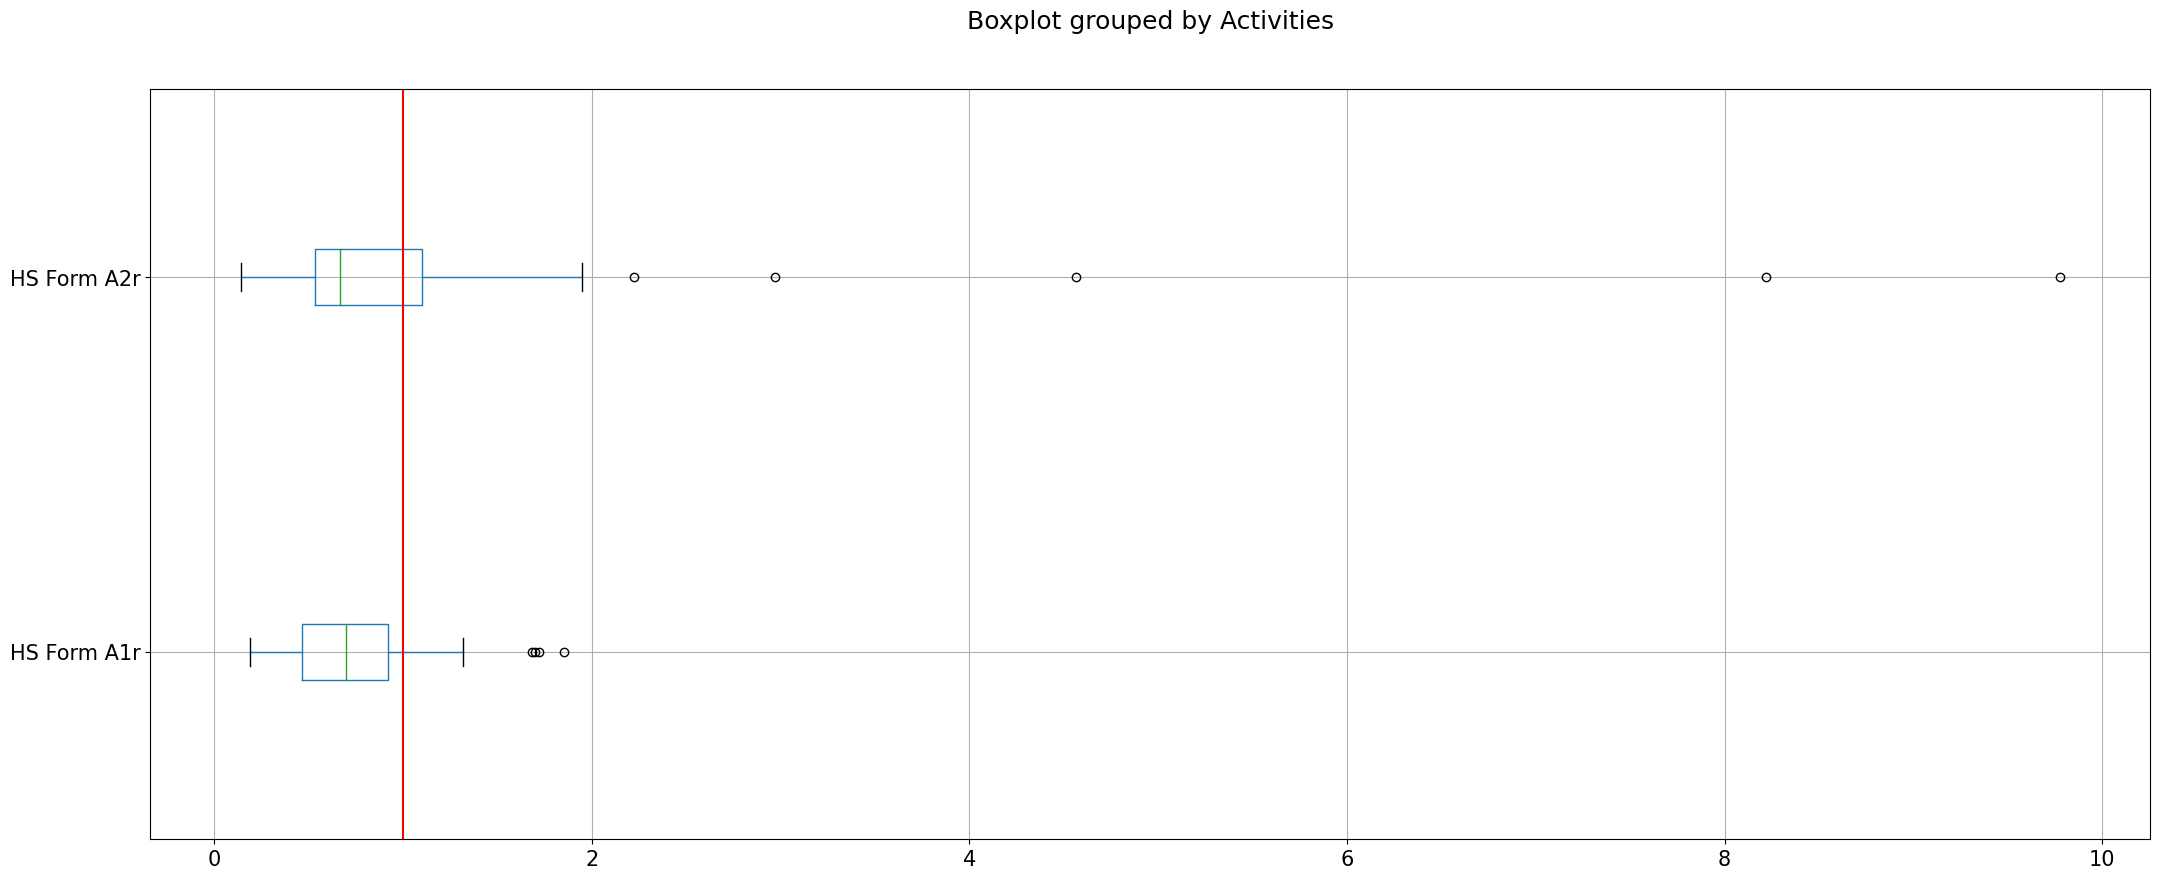

In [ ]:
A_forms.boxplot(column = 'Corrected_Completion_Time', by = 'Activities',figsize=(25,10), vert=False)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.axvline(1, color = 'r')
plt.rcParams.update({'font.size': 15})
plt.show()

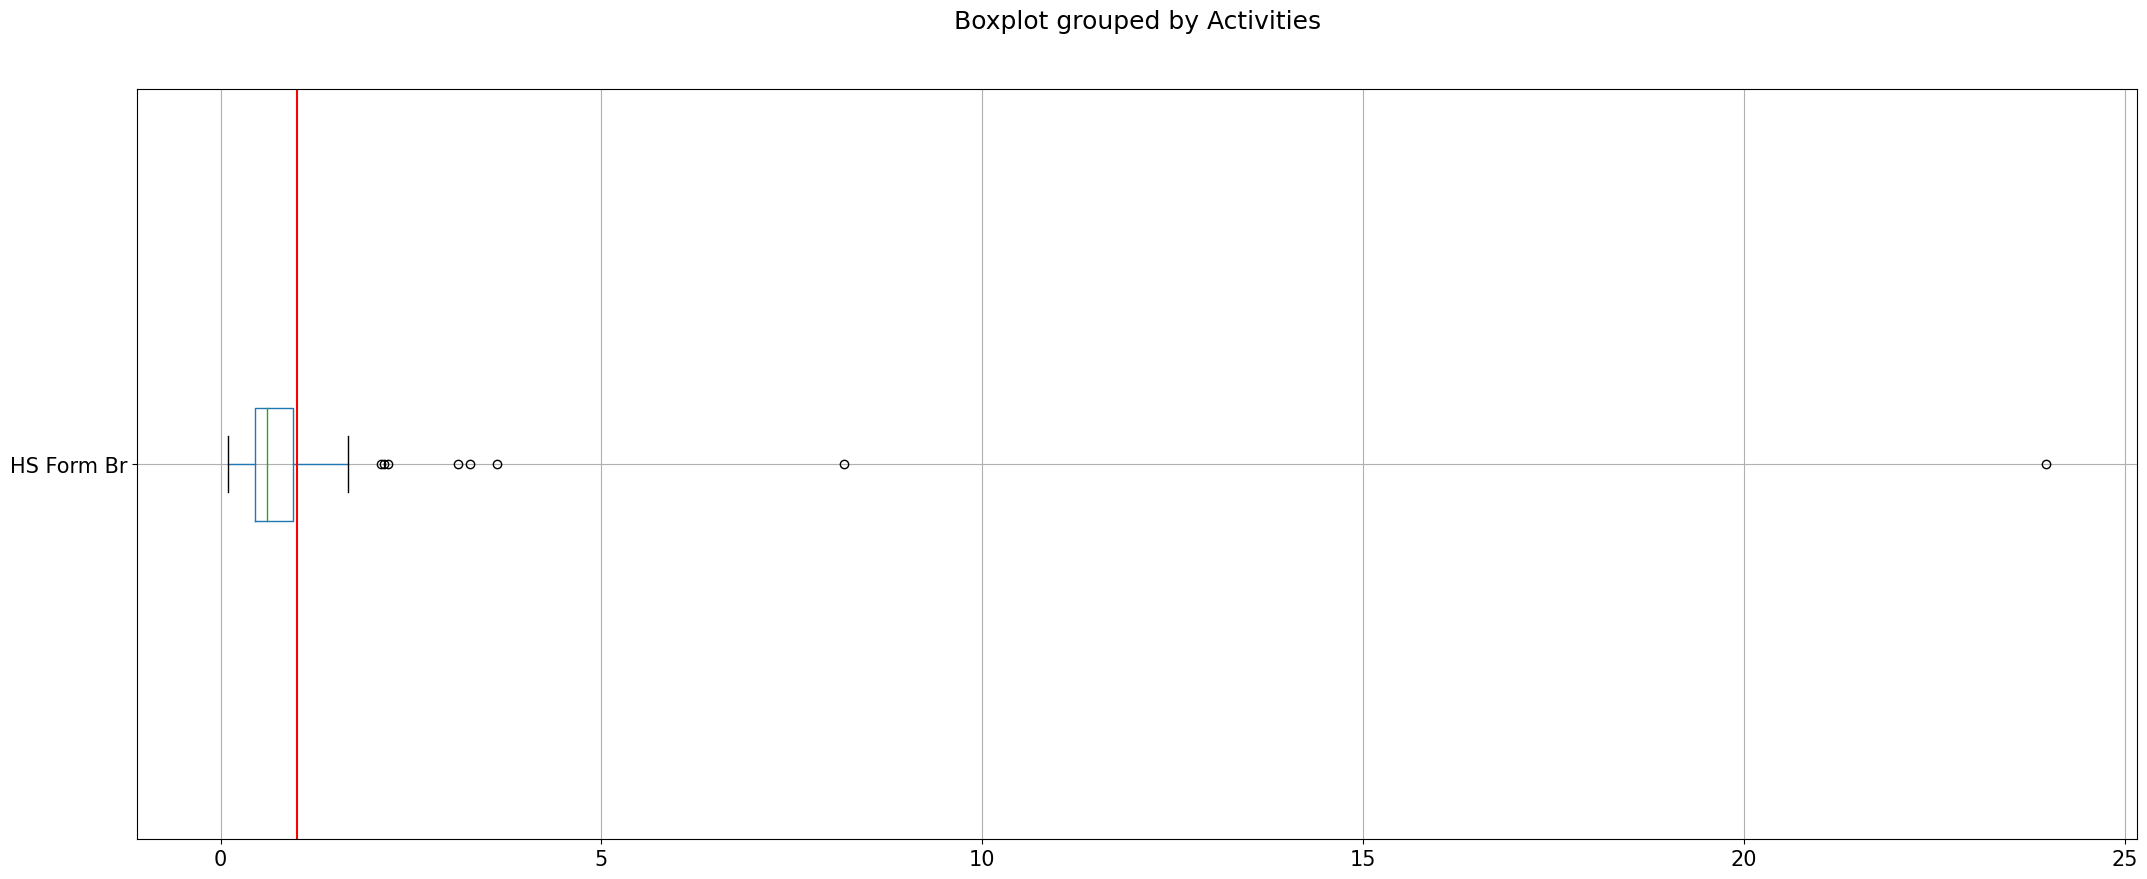

In [ ]:
B_forms.boxplot(column = 'Corrected_Completion_Time', by = 'Activities',figsize=(25,10), vert=False)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.axvline(1, color = 'r')
plt.rcParams.update({'font.size': 15})
plt.show()

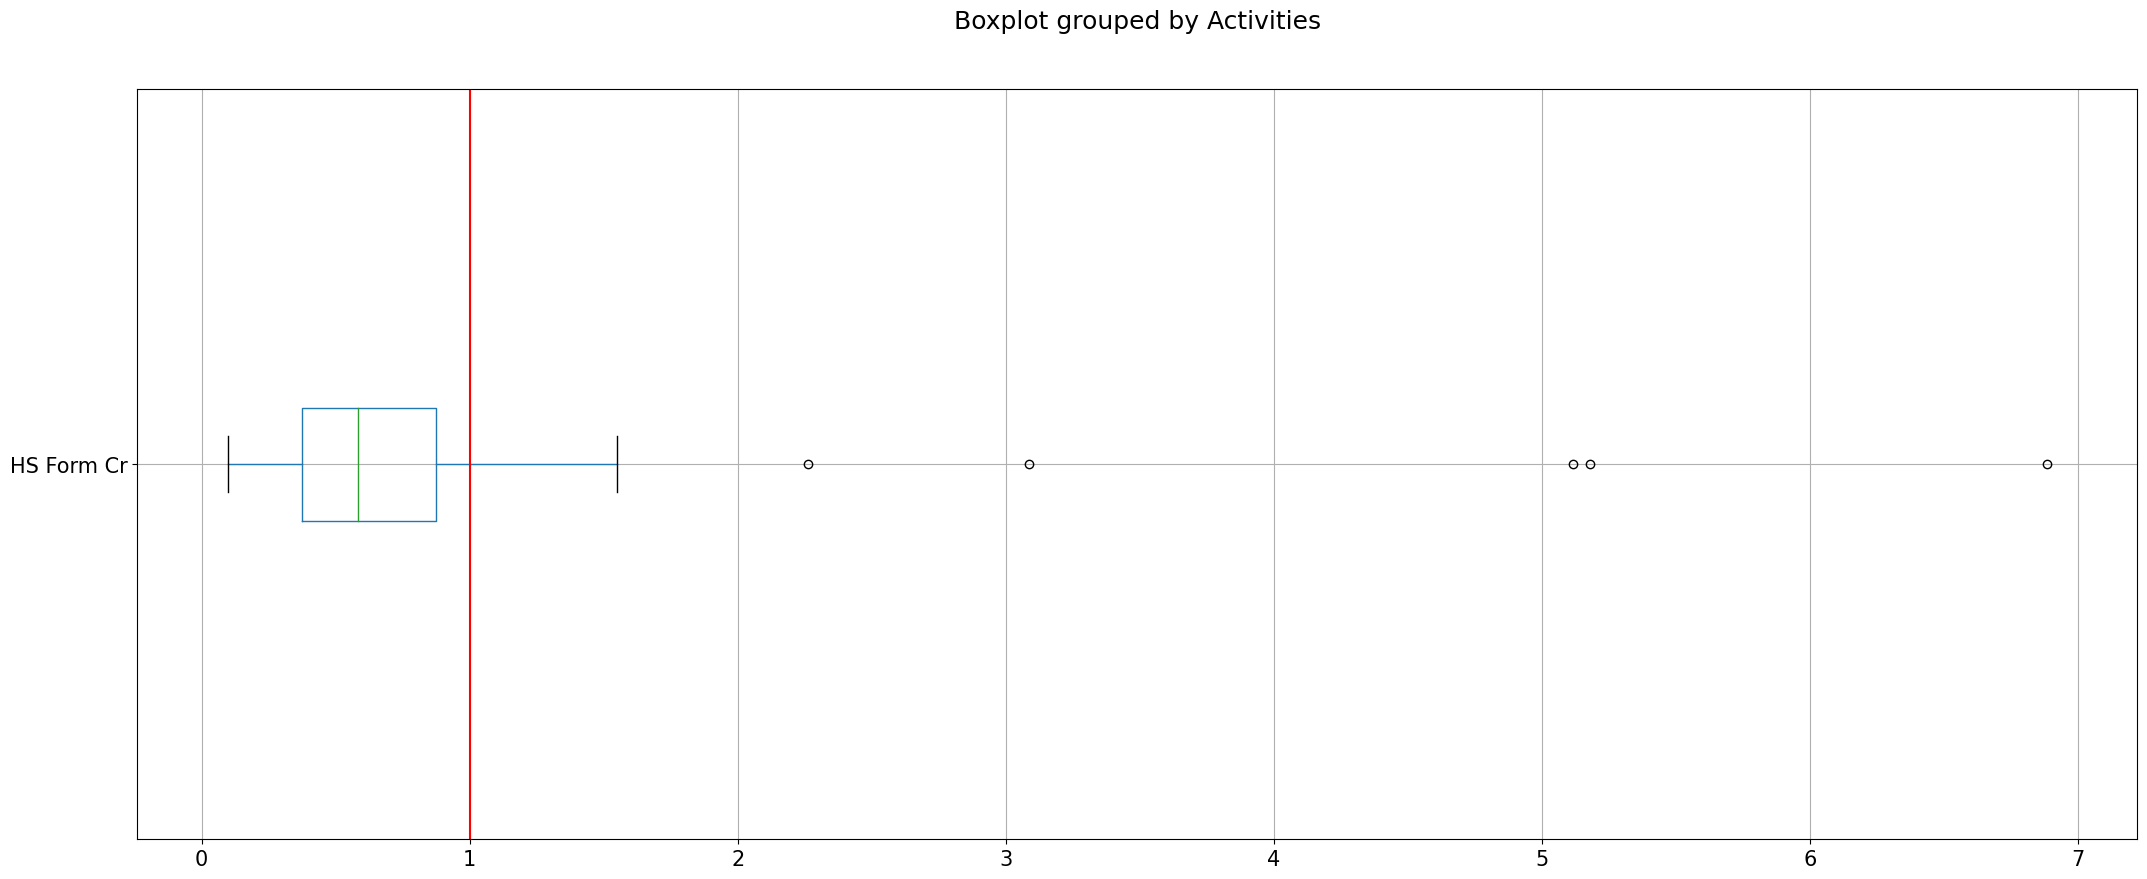

In [ ]:
C_forms.boxplot(column = 'Corrected_Completion_Time', by = 'Activities',figsize=(25,10), vert=False)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.axvline(1, color = 'r')
plt.rcParams.update({'font.size': 15})
plt.show()

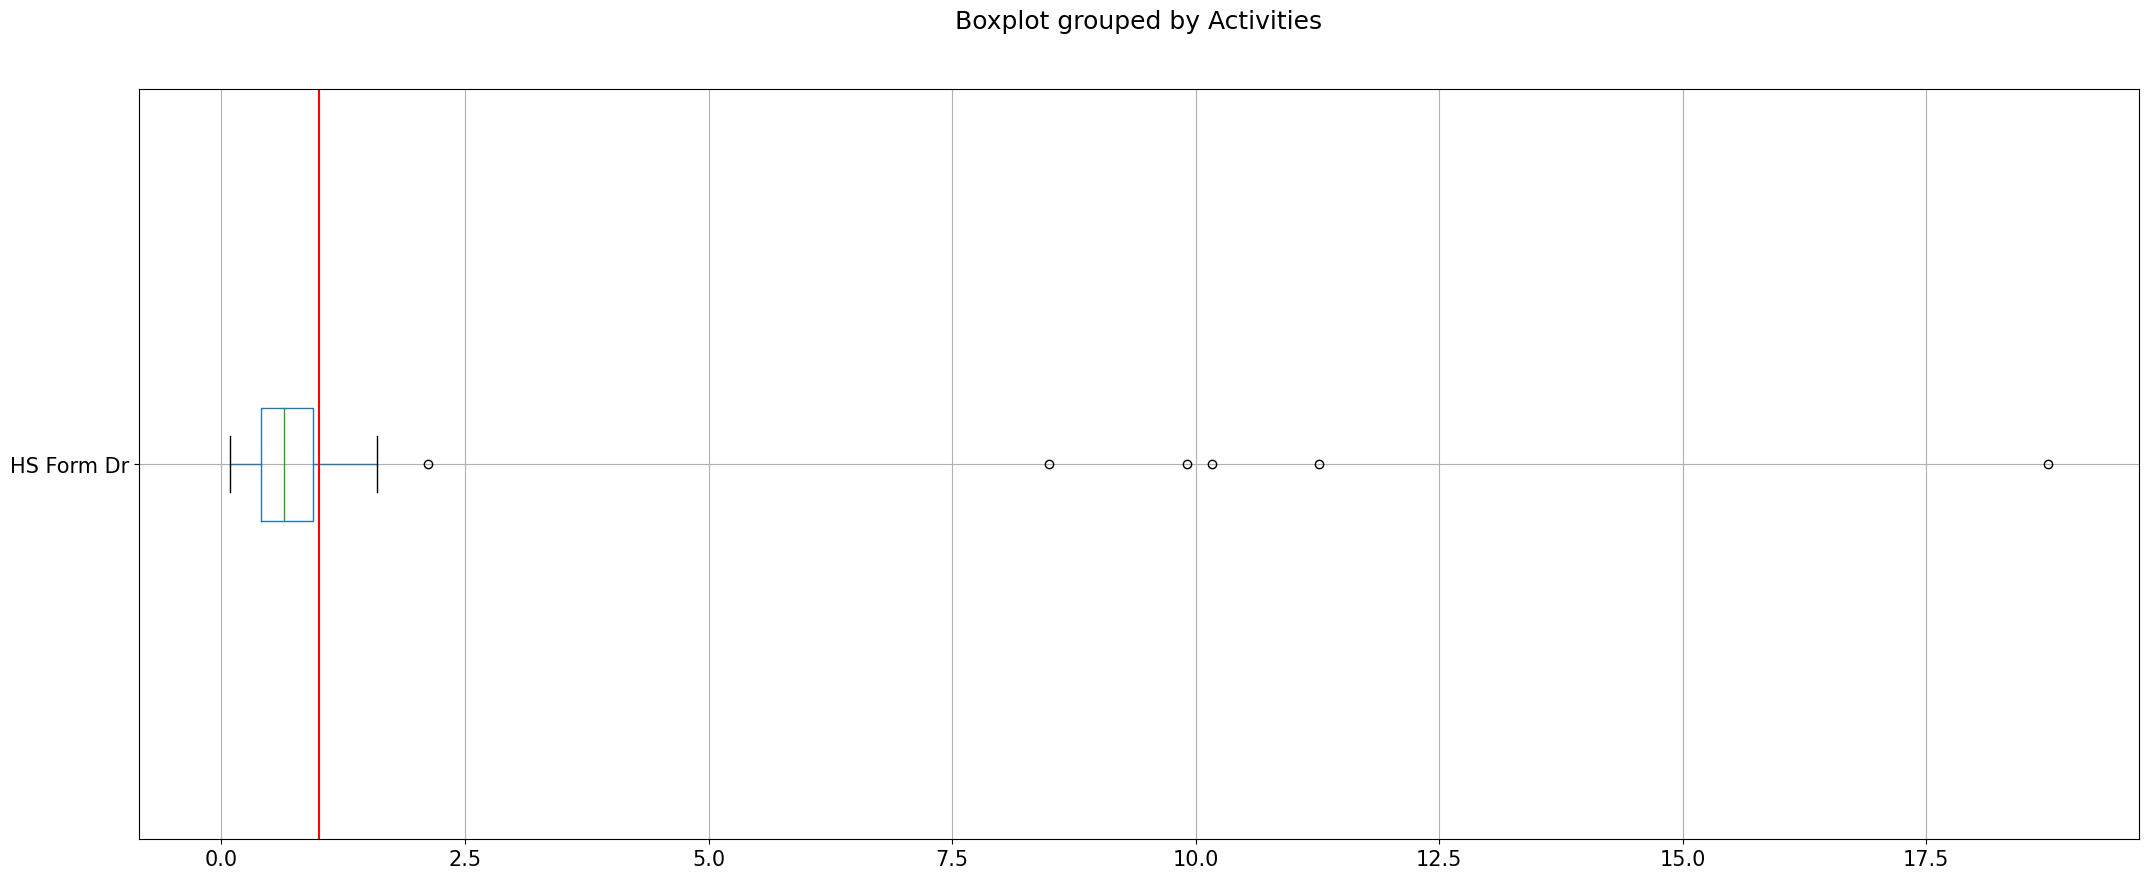

In [ ]:
D_forms.boxplot(column = 'Corrected_Completion_Time', by = 'Activities',figsize=(25,10), vert=False)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.axvline(1, color = 'r')
plt.rcParams.update({'font.size': 15})
plt.show()

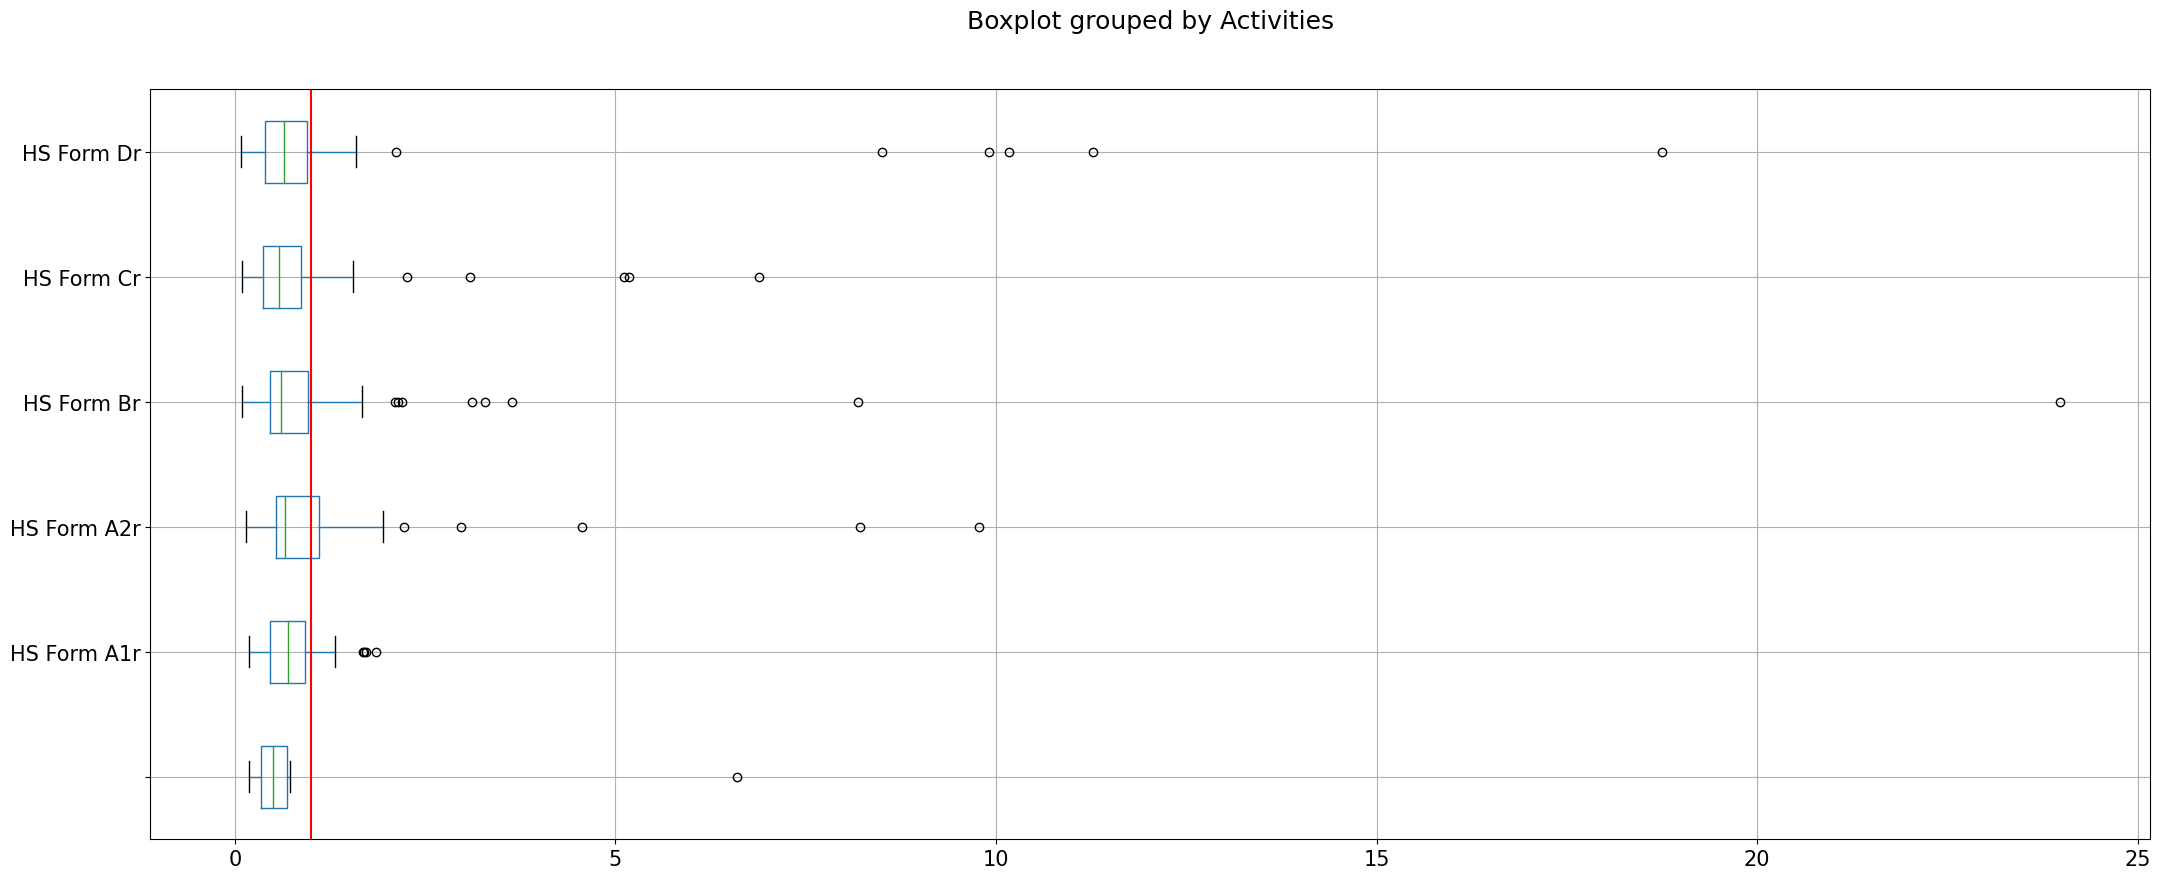

In [ ]:
just_act_and_ct.boxplot(column = 'Corrected_Completion_Time', by = 'Activities', figsize=(25,10), vert=False)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.axvline(1, color = 'r')
plt.rcParams.update({'font.size': 15})
plt.show()

In [ ]:
pause_ddm_df["Action"].unique()

array(['Begin activity Spring 2024 HS DDM Administration',
       'Page 1 Loaded', 'Page next clicked on page 1', 'Page 2 Loaded',
       'Pause activity Spring 2024 HS DDM Administration',
       'Page next clicked on page 2', 'Page 3 Loaded',
       'Page next clicked on page 3', 'Page 4 Loaded',
       'Page next clicked on page 4', 'Page 5 Loaded',
       'Page next clicked on page 5', 'Page 6 Loaded',
       'Page next clicked on page 6', 'Page 7 Loaded',
       'Page next clicked on page 7', 'Page 8 Loaded',
       'Page next clicked on page 8', 'Page 9 Loaded',
       'Page next clicked on page 9', 'Page 10 Loaded',
       'Page next clicked on page 10', 'Missing answers',
       'Page 11 Loaded', 'Page 12 Loaded', 'Page next clicked on page 12',
       'Page 13 Loaded', 'Page next clicked on page 13', 'Page 14 Loaded',
       'Page next clicked on page 14', 'Page 15 Loaded',
       'Page next clicked on page 15', 'Page 16 Loaded',
       'Page next clicked on page 16', 'Page 17

In [ ]:
merged_df = pd.merge(completed_subset, paused_students[['Assignment']], on='Assignment', how='left', indicator=True)
merged_df

,Assignment,Activities,Date,Time,Action,Datetime,_merge
0,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:21:49.642,Begin activity Spring 2024 HS DDM Administration,2024-05-09 16:21:49.642,left_only
1,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:21:50.014,Page 1 Loaded,2024-05-09 16:21:50.014,left_only
2,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:21:54.940,Page next clicked on page 1,2024-05-09 16:21:54.940,left_only
3,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:21:55.570,Page 2 Loaded,2024-05-09 16:21:55.570,left_only
4,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:22:03.887,Page next clicked on page 2,2024-05-09 16:22:03.887,left_only
...,...,...,...,...,...,...,...
319322,113718,Spr 24 DDM HS Form A1r,05/14/2024,11:34:49.190,Page 34 Loaded,2024-05-14 11:34:49.190,left_only
319323,113718,Spr 24 DDM HS Form A1r,05/14/2024,11:34:53.521,Page next clicked on page 34,2024-05-14 11:34:53.521,left_only
319324,113718,Spr 24 DDM HS Form A1r,05/14/2024,11:34:56.172,Page 35 Loaded,2024-05-14 11:34:56.172,left_only
319325,113718,Spr 24 DDM HS Form A1r,05/14/2024,11:35:01.128,Page next clicked on page 35,2024-05-14 11:35:01.128,left_only


In [ ]:
no_pause_activities = merged_df[merged_df['_merge'] == 'left_only']
# Drop the indicator column as it's no longer needed
no_pause_activities

,Assignment,Activities,Date,Time,Action,Datetime,_merge
0,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:21:49.642,Begin activity Spring 2024 HS DDM Administration,2024-05-09 16:21:49.642,left_only
1,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:21:50.014,Page 1 Loaded,2024-05-09 16:21:50.014,left_only
2,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:21:54.940,Page next clicked on page 1,2024-05-09 16:21:54.940,left_only
3,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:21:55.570,Page 2 Loaded,2024-05-09 16:21:55.570,left_only
4,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:22:03.887,Page next clicked on page 2,2024-05-09 16:22:03.887,left_only
...,...,...,...,...,...,...,...
319322,113718,Spr 24 DDM HS Form A1r,05/14/2024,11:34:49.190,Page 34 Loaded,2024-05-14 11:34:49.190,left_only
319323,113718,Spr 24 DDM HS Form A1r,05/14/2024,11:34:53.521,Page next clicked on page 34,2024-05-14 11:34:53.521,left_only
319324,113718,Spr 24 DDM HS Form A1r,05/14/2024,11:34:56.172,Page 35 Loaded,2024-05-14 11:34:56.172,left_only
319325,113718,Spr 24 DDM HS Form A1r,05/14/2024,11:35:01.128,Page next clicked on page 35,2024-05-14 11:35:01.128,left_only


In [ ]:
import pandas as pd

# Assuming no_pause_activities is already defined and loaded
# Convert 'Datetime' to datetime format for calculation
no_pause_activities['Datetime'] = pd.to_datetime(no_pause_activities['Datetime'])

# Filter rows for 'Begin activity' and 'End activity'
begin_activities = no_pause_activities[no_pause_activities['Action'].str.contains('Begin activity')]
end_activities = no_pause_activities[no_pause_activities['Action'].str.contains('End activity')]

# Merge the begin and end activities on 'Assignment'
activity_times = pd.merge(begin_activities, end_activities, on='Assignment', suffixes=('_begin', '_end'))

# Calculate the duration for each assignment
activity_times['Completion Time'] = activity_times['Datetime_end'] - activity_times['Datetime_begin']

# Select relevant columns to view the result
result = activity_times[['Assignment', 'Completion Time']]

# Show the DataFrame with the completion times
result

<ipython-input-93-04e766cd272a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_pause_activities['Datetime'] = pd.to_datetime(no_pause_activities['Datetime'])


,Assignment,Completion Time
0,110349,0 days 00:26:57.205000
1,114141,0 days 00:04:52.821000
2,101122,0 days 00:26:36.844000
3,100177,0 days 00:34:56.016000
4,100189,0 days 00:08:11.476000
...,...,...
3826,98240,4 days 07:17:04.166000
3827,97593,0 days 04:03:05.618000
3828,97043,0 days 00:29:03.006000
3829,97181,0 days 00:19:53.957000


In [ ]:
# Save the DataFrame to a CSV file
result.to_csv('ddm_hs_completion_times.csv', index=False)


In [ ]:
paused_subset['DateTime'] = pd.to_datetime(paused_subset['Date'] + ' ' + paused_subset['Time'])
total_completion_times = []
completion_times = []
paused_times = []

for assignment, group in paused_subset.groupby('Assignment'):
  begin_activity = group[group['Action'] == 'Begin activity Spring 2024 HS DDM Administration']['DateTime']
  end_activity = group[group['Action'] == 'End activity Spring 2024 HS DDM Administration']['DateTime']
  pause_activity = group[group['Action'] == 'Pause activity Spring 2024 HS DDM Administration']['DateTime']
  continue_activity = group[group['Action'] == 'Continue activity Spring 2024 HS DDM Administration']['DateTime']

  pause_time = 0

  if not begin_activity.empty and not end_activity.empty:
    start_time = begin_activity.iloc[0]
    end_time = end_activity.iloc[0]
    total_completion_time = end_time - start_time
    total_completion_times.append((assignment, total_completion_time))

  if not pause_activity.empty and not continue_activity.empty:
    pause_time = pause_activity.iloc[0]
    continue_time = continue_activity.iloc[0]
    paused_time = continue_time - pause_time
    paused_times.append((assignment, paused_time))
    total_completion_time = total_completion_time - paused_time

  completion_times.append((assignment, total_completion_time))

paused_times_df = pd.DataFrame(paused_times, columns=['Assignment', 'Paused Time'])
total_completion_times_df = pd.DataFrame(total_completion_times, columns=['Assignment','Completion Time'])
completion_times_df = pd.DataFrame(completion_times, columns = ['Assignment', 'Completion Time'])

In [ ]:
paused_times_df['Paused Time Minutes'] = [td.total_seconds()/3600 for td in paused_times_df['Paused Time']]
paused_times_df

,Assignment,Paused Time,Paused Time Minutes
0,96503,0 days 22:59:10.741000,22.986317
1,96504,0 days 15:42:54.531000,15.715148
2,96512,0 days 00:00:46.002000,0.012778
3,96576,0 days 00:21:59.511000,0.366531
4,96597,0 days 00:00:06.966000,0.001935
...,...,...,...
358,114275,0 days 00:00:08.050000,0.002236
359,114295,0 days 06:52:10.768000,6.869658
360,114334,0 days 00:00:03.712000,0.001031
361,114360,0 days 01:48:38.511000,1.810698


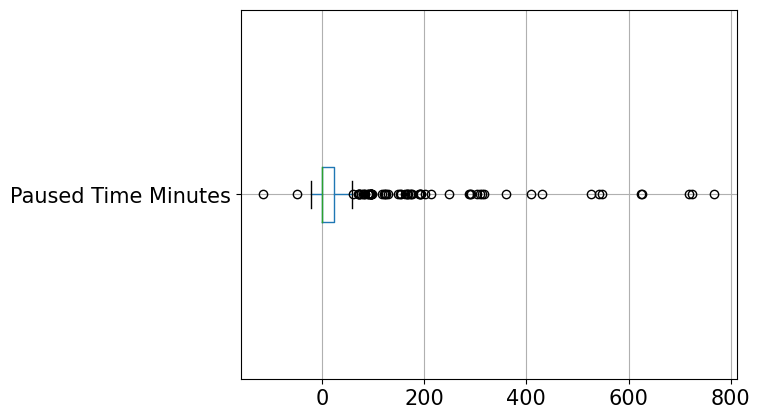

In [ ]:
paused_times_df.boxplot('Paused Time Minutes', vert = False)
plt.show()

The distribution of total completion times (with pause data removed) for all students who completed the activity.  ("NO PAUSE")

**NOTE THAT ANYTHING "MODIFIED"  IS REFERRING TO LESS THAN A DAY COMPLETION TIME**

## Filtering for Assignments that have completion times within the **same day (<= 1 day)**

In [ ]:
modified_day_limit = completion_times_df[completion_times_df['Completion Time'] <= pd.Timedelta(days=1)]
modified_day_limit

,Assignment,Completion Time
0,96486,0 days 00:20:02.169000
1,96502,0 days 00:10:27.344000
2,96503,0 days 00:27:19.320000
3,96504,0 days 00:33:05.767000
4,96505,0 days 00:18:57.241000
...,...,...
4214,114483,0 days 04:13:36.754000
4215,114486,0 days 00:22:32.269000
4216,114489,0 days 00:09:18.575000
4217,114512,0 days 00:16:11.454000


**Number of students who completed their activity in under a day: 3810**

## Merged DF with Completion Time

In order to see the rest of the data, we can merge the begin/end filtered cot dataframe with the day limit df of completion times to get the completion time per unique assignment.

The outcome is a dataframe of the assignments with begin/end pairs that were completed in a day.

In [ ]:
completion_times_df

,Assignment,Completion Time
0,96486,0 days 00:20:02.169000
1,96502,0 days 00:10:27.344000
2,96503,0 days 00:27:19.320000
3,96504,0 days 00:33:05.767000
4,96505,0 days 00:18:57.241000
...,...,...
4214,114483,0 days 04:13:36.754000
4215,114486,0 days 00:22:32.269000
4216,114489,0 days 00:09:18.575000
4217,114512,0 days 00:16:11.454000


In [ ]:
modified_CT_ddm_df = pd.merge(paused_subset[['Assignment','Activities']], modified_day_limit).drop_duplicates()
modified_CT_ddm_df

,Assignment,Activities,Completion Time
0,110349,Spr 24 DDM HS Form A2r,0 days 00:26:57.205000
2,114141,Spr 24 DDM HS Form Cr,0 days 00:04:52.821000
4,101122,Spr 24 DDM HS Form Dr,0 days 00:26:36.844000
6,100177,Spr 24 DDM HS Form A1r,0 days 00:34:56.016000
8,100189,Spr 24 DDM HS Form Cr,0 days 00:08:11.476000
...,...,...,...
8541,97593,Spr 24 DDM HS Form Cr,0 days 04:03:05.618000
8544,97043,Spr 24 DDM HS Form Cr,0 days 00:29:03.006000
8546,97181,Spr 24 DDM HS Form Br,0 days 00:19:53.957000
8548,97590,Spr 24 DDM HS Form Dr,0 days 01:00:10.834000


In [ ]:
modified_CT_ddm_df_sorted = modified_CT_ddm_df.sort_values("Completion Time", ascending = True)
modified_CT_ddm_df_sorted

,Assignment,Activities,Completion Time
3883,109711,NaN,0 days 00:03:00.166000
5502,97521,NaN,0 days 00:03:00.632000
5514,97496,NaN,0 days 00:03:15.975000
410,98816,Spr 24 DDM HS Form Dr,0 days 00:03:34.719000
2959,99210,NaN,0 days 00:03:36.533000
...,...,...,...
3805,100520,Spr 24 DDM HS Form A2r,0 days 23:56:18.544000
1906,98519,Spr 24 DDM HS Form Br,0 days 23:57:49.342000
1903,98529,Spr 24 DDM HS Form Dr,0 days 23:58:03.595000
7451,97459,Spr 24 DDM HS Form Br,0 days 23:59:24.502000


In [ ]:
modified_CT_ddm_df_sorted['Completion Time'] = modified_CT_ddm_df_sorted['Completion Time'].apply(lambda x: f"{x.components.hours:02}:{x.components.minutes:02}")
modified_CT_ddm_df_sorted

,Assignment,Activities,Completion Time
3883,109711,NaN,00:03
5502,97521,NaN,00:03
5514,97496,NaN,00:03
410,98816,Spr 24 DDM HS Form Dr,00:03
2959,99210,NaN,00:03
...,...,...,...
3805,100520,Spr 24 DDM HS Form A2r,23:56
1906,98519,Spr 24 DDM HS Form Br,23:57
1903,98529,Spr 24 DDM HS Form Dr,23:58
7451,97459,Spr 24 DDM HS Form Br,23:59


In [ ]:
modified_CT_ddm_df_sorted['Completion Time'] = pd.to_timedelta(modified_CT_ddm_df_sorted['Completion Time'].str[:2].astype(int), unit='h') + pd.to_timedelta(modified_CT_ddm_df_sorted['Completion Time'].str[2:].astype(int), unit='m')

ValueError: invalid literal for int() with base 10: ':03'

In [ ]:
modified_CT_ddm_df_sorted['Completion Time'].dtype

## NO PAUSE STATISTICS TABLE

In [ ]:
modified_ave_per_act = modified_CT_ddm_df_sorted.groupby('Activities')[['Completion Time']].describe()
modified_ave_per_act = modified_ave_per_act.astype(str)
modified_ave_per_act[('Completion Time','mean')] = [x[7:-7] for x in modified_ave_per_act[('Completion Time','mean')]]
modified_ave_per_act[('Completion Time','std')] = [x[7:-10] for x in modified_ave_per_act[('Completion Time','std')]]
modified_ave_per_act[('Completion Time','min')] = [x[7:-7] for x in modified_ave_per_act[('Completion Time','min')]]
modified_ave_per_act[('Completion Time','25%')] = [x[7:-7] for x in modified_ave_per_act[('Completion Time','25%')]]
modified_ave_per_act[('Completion Time','50%')] = [x[7:-7] for x in modified_ave_per_act[('Completion Time','50%')]]
modified_ave_per_act[('Completion Time','75%')] = [x[7:-7] for x in modified_ave_per_act[('Completion Time','75%')]]
modified_ave_per_act[('Completion Time','max')] = [x[7:-7] for x in modified_ave_per_act[('Completion Time','max')]]

modified_ave_per_act

In [ ]:
def format_timedelta(td_str):
    # Assuming input is like '00:58:18.10' or '02:47:01'
    if '.' in td_str:  # To handle strings with milliseconds
        td_str = td_str.split('.')[0]  # Remove milliseconds
    hh_mm = ':'.join(td_str.split(':')[:2])  # Keep only hours and minutes
    return hh_mm

# Apply the formatting function to each relevant column
for col in modified_ave_per_act.columns:
    modified_ave_per_act[col] = modified_ave_per_act[col].apply(format_timedelta)

modified_ave_per_act

In [ ]:
modified_ave_per_act = modified_day_limit.groupby('Activities')[['Corrected_Completion_Time']].describe()
modified_ave_per_act = modified_ave_per_act.astype(str)
modified_ave_per_act[('Corrected_Completion_Time','mean')] = [x[7:-7] for x in modified_ave_per_act[('Corrected_Completion_Time','mean')]]
modified_ave_per_act[('Corrected_Completion_Time','std')] = [x[7:-10] for x in modified_ave_per_act[('Corrected_Completion_Time','std')]]
modified_ave_per_act[('Corrected_Completion_Time','min')] = [x[7:-7] for x in modified_ave_per_act[('Corrected_Completion_Time','min')]]
modified_ave_per_act[('Corrected_Completion_Time','25%')] = [x[7:-7] for x in modified_ave_per_act[('Corrected_Completion_Time','25%')]]
modified_ave_per_act[('Corrected_Completion_Time','50%')] = [x[7:-7] for x in modified_ave_per_act[('Corrected_Completion_Time','50%')]]
modified_ave_per_act[('Corrected_Completion_Time','75%')] = [x[7:-7] for x in modified_ave_per_act[('Corrected_Completion_Time','75%')]]
modified_ave_per_act[('Corrected_Completion_Time','max')] = [x[7:-7] for x in modified_ave_per_act[('Corrected_Completion_Time','max')]]

modified_ave_per_act

In [ ]:
just_act_and_ct = modified_CT_ddm_df_sorted[['Assignment', 'Activities', 'Completion Time']].reset_index(drop=True)
just_act_and_ct['Completion Time'] = [td.total_seconds() / 3600 if isinstance(td, pd.Timedelta) else td for td in just_act_and_ct['Completion Time']]
just_act_and_ct['Activities'] = just_act_and_ct['Activities'].astype(str)
just_act_and_ct['Activities'] = [x[11:] for x in just_act_and_ct['Activities']]

just_act_and_ct

In [ ]:
hour_df = just_act_and_ct[just_act_and_ct['Completion Time'] <= 1]
hour_df['Completion Time'] = hour_df['Completion Time'] * 60
hour_df

In [ ]:
merged_df = pd.merge(hour_df, proficiencies_df, on='Assignment')
merged_df

In [ ]:
scatter_plot = merged_df.plot.scatter(x = "Completion Time", y = "WLE")
scatter_plot.set_xlabel("Completion Time (Minutes)")
scatter_plot.set_ylabel("proficiencies (WLE)")
scatter_plot.set_title("DDM MS Completion Time/WLE for 'No Pause' Students")

In [ ]:
#Bottom 5% of data
index = int(len(modified_CT_ddm_df_sorted) * 0.05)
index

In [ ]:
df_trimmed = modified_CT_ddm_df_sorted.iloc[index:]
df_trimmed

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
proficiencies_df = pd.read_csv(io.BytesIO(uploaded['Spring 2024 HS DDM Administration DDM proficiencies.csv']))
proficiencies_df

In [ ]:
proficiencies_df.rename(columns={'Assignment Id': 'Assignment'}, inplace=True)
proficiencies_df

In [ ]:
merged_df = pd.merge(hour_df, proficiencies_df, on='Assignment')
merged_df

In [ ]:
import numpy as np

merged_df['Log_Completion_Time'] = np.log(merged_df['Completion Time'])
merged_df

In [ ]:
correlation = merged_df['Log_Completion_Time'].corr(merged_df['WLE'])
print(f"Correlation between Log Completion Time and Proficiency: {correlation}")


In [ ]:
import matplotlib.pyplot as plt

plt.scatter(merged_df['Log_Completion_Time'], merged_df['WLE'])
plt.xlabel('Log Completion Time (minutes)')
plt.ylabel('Proficiency')
plt.title('Scatter Plot of Log Completion Time vs Proficiency')
plt.grid(True)
plt.show()

In [ ]:
scatter_plot = merged_df.plot.scatter(x = "Completion Time", y = "WLE")
scatter_plot.set_xlabel("Completion Time (Minutes)")
scatter_plot.set_ylabel("proficiencies (WLE)")
scatter_plot.set_title("DDM HS Completion Time/WLE for 'No Pause' Students")

# SUMMARY STATISTICS: Average time of completion per activity type

In [ ]:
modified_ave_per_act = df_trimmed.groupby('Activities')[['Completion Time']].describe()
modified_ave_per_act = modified_ave_per_act.astype(str)
modified_ave_per_act[('Completion Time','mean')] = [x[7:-7] for x in modified_ave_per_act[('Completion Time','mean')]]
modified_ave_per_act[('Completion Time','std')] = [x[7:-10] for x in modified_ave_per_act[('Completion Time','std')]]
modified_ave_per_act[('Completion Time','min')] = [x[7:-7] for x in modified_ave_per_act[('Completion Time','min')]]
modified_ave_per_act[('Completion Time','25%')] = [x[7:-7] for x in modified_ave_per_act[('Completion Time','25%')]]
modified_ave_per_act[('Completion Time','50%')] = [x[7:-7] for x in modified_ave_per_act[('Completion Time','50%')]]
modified_ave_per_act[('Completion Time','75%')] = [x[7:-7] for x in modified_ave_per_act[('Completion Time','75%')]]
modified_ave_per_act[('Completion Time','max')] = [x[7:-7] for x in modified_ave_per_act[('Completion Time','max')]]

modified_ave_per_act

The 90th percentile information:

In [ ]:
df_trimmed.groupby('Activities')['Completion Time'].quantile(.9)

The average completion time across forms:

In [ ]:
print('Average completion time for all activities', str(np.mean(df_trimmed['Completion Time']))[7:-10])

# BOX PLOTS

In [ ]:
#Converts the values in the 'Completion Time' column to hours
just_act_and_ct = df_trimmed[['Assignment','Activities', 'Completion Time']].reset_index(drop=True)
just_act_and_ct['Completion Time'] = [td.total_seconds() / 3600 if isinstance(td, pd.Timedelta) else td for td in just_act_and_ct['Completion Time']]
just_act_and_ct['Activities'] = just_act_and_ct['Activities'].astype(str)
just_act_and_ct['Activities'] = [x[11:] for x in just_act_and_ct['Activities']]

just_act_and_ct

In [ ]:
just_act_and_ct["Activities"].unique()

In [ ]:
A_forms = just_act_and_ct[just_act_and_ct['Activities'].isin(['HS Form A1r', 'HS Form A2r'])]
B_forms = just_act_and_ct[just_act_and_ct['Activities'].isin(['HS Form Br'])]
C_forms = just_act_and_ct[just_act_and_ct['Activities'].isin(['HS Form Cr'])]
D_forms = just_act_and_ct[just_act_and_ct['Activities'].isin(['HS Form Dr'])]

In [ ]:
empty_activities_rows = just_act_and_ct[just_act_and_ct["Activities"] == '']
empty_activities_rows

Boxplots for Completion Times 1 hour or Less

In [ ]:
hour_df = just_act_and_ct[just_act_and_ct['Completion Time'] <= 1]
hour_df['Completion Time'] = hour_df['Completion Time'] * 60
hour_df

In [ ]:
new_A_forms = hour_df[hour_df['Activities'].isin(['HS Form A1r', 'HS Form A2r'])]
new_B_forms = hour_df[hour_df['Activities'].isin(['HS Form Br'])]
new_C_forms = hour_df[hour_df['Activities'].isin(['HS Form Cr'])]
new_D_forms = hour_df[hour_df['Activities'].isin(['HS Form Dr'])]

In [ ]:
new_A_forms.boxplot(column = 'Completion Time', by = 'Activities',figsize=(25,10), vert=False)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.axvline(1, color = 'r')
plt.rcParams.update({'font.size': 15})
plt.show()

In [ ]:
new_B_forms.boxplot(column = 'Completion Time', by = 'Activities',figsize=(25,10), vert=False)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.axvline(1, color = 'r')
plt.rcParams.update({'font.size': 15})
plt.show()

In [ ]:
new_C_forms.boxplot(column = 'Completion Time', by = 'Activities',figsize=(25,10), vert=False)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.axvline(1, color = 'r')
plt.rcParams.update({'font.size': 15})
plt.show()

In [ ]:
new_D_forms.boxplot(column = 'Completion Time', by = 'Activities',figsize=(25,10), vert=False)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.axvline(1, color = 'r')
plt.rcParams.update({'font.size': 15})
plt.show()

In [ ]:
hour_df.boxplot(column = 'Completion Time', by = 'Activities', figsize=(25,10), vert=False)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.axvline(1, color = 'r')
plt.rcParams.update({'font.size': 15})
plt.show()

### Boxplots for Forms A

In [ ]:
A_forms.boxplot(column = 'Completion Time', by = 'Activities',figsize=(25,10), vert=False)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.axvline(1, color = 'r')
plt.rcParams.update({'font.size': 15})
plt.show()

### Boxplots for Forms B

In [ ]:
B_forms.boxplot(column = 'Completion Time', by = 'Activities', figsize=(25,10), vert=False)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.axvline(1, color = 'r')
plt.rcParams.update({'font.size': 15})
plt.show()

### Boxplots for Forms C

In [ ]:
C_forms.boxplot(column = 'Completion Time', by = 'Activities', figsize=(25,10), vert=False)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.axvline(1, color = 'r')
plt.rcParams.update({'font.size': 15})
plt.show()

### Boxplots for Forms D

In [ ]:
D_forms.boxplot(column = 'Completion Time', by = 'Activities', figsize=(25,10), vert=False)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.axvline(1, color = 'r')
plt.rcParams.update({'font.size': 15})
plt.show()

In [ ]:
just_act_and_ct.boxplot(column = 'Completion Time', by = 'Activities', figsize=(25,10), vert=False)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.axvline(1, color = 'r')
plt.rcParams.update({'font.size': 15})
plt.show()

# Median Response Time Calculation

## Spring MS Form A1r Median Time: Pages 7-35

In [ ]:
no_pause_ddm_df

,Assignment,Activities,Date,Time,Action,Datetime
123469,101765,NaN,04/10/2024,09:15:19.673,Begin activity Spring 2024 HS DDM Administration,2024-04-10 09:15:19.673
123470,101765,NaN,04/10/2024,09:15:21.094,Page 1 Loaded,2024-04-10 09:15:21.094
123471,101765,NaN,04/10/2024,09:16:52.853,Page next clicked on page 1,2024-04-10 09:16:52.853
123472,101765,NaN,04/10/2024,09:16:55.054,Missing answers,2024-04-10 09:16:55.054
123473,101765,NaN,04/10/2024,09:19:03.244,Page next clicked on page 1,2024-04-10 09:19:03.244
...,...,...,...,...,...,...
109806,99287,Spr 24 DDM HS Form Cr,05/23/2024,13:20:44.176,Page 9 Loaded,2024-05-23 13:20:44.176
109807,99287,Spr 24 DDM HS Form Cr,05/23/2024,13:20:45.934,Page next clicked on page 9,2024-05-23 13:20:45.934
109808,99287,Spr 24 DDM HS Form Cr,05/23/2024,13:20:47.073,Missing answers,2024-05-23 13:20:47.073
109809,99287,Spr 24 DDM HS Form Cr,05/23/2024,13:21:04.439,Page next clicked on page 9,2024-05-23 13:21:04.439


In [ ]:
Spr = no_pause_ddm_df[no_pause_ddm_df['Action'] == 'Page next clicked on page 35']
Spr

,Assignment,Activities,Date,Time,Action,Datetime
90750,99659,Spr 24 DDM HS Form A1r,04/12/2024,06:22:23.130,Page next clicked on page 35,2024-04-12 06:22:23.130
149914,99528,Spr 24 DDM HS Form A1r,04/12/2024,06:23:57.509,Page next clicked on page 35,2024-04-12 06:23:57.509
151483,99519,Spr 24 DDM HS Form A2r,04/12/2024,06:24:00.289,Page next clicked on page 35,2024-04-12 06:24:00.289
151485,99519,Spr 24 DDM HS Form A2r,04/12/2024,06:24:06.608,Page next clicked on page 35,2024-04-12 06:24:06.608
151487,99519,Spr 24 DDM HS Form A2r,04/12/2024,06:24:12.767,Page next clicked on page 35,2024-04-12 06:24:12.767
...,...,...,...,...,...,...
62076,110664,Spr 24 DDM HS Form A2r,05/23/2024,09:34:24.085,Page next clicked on page 35,2024-05-23 09:34:24.085
61998,110654,Spr 24 DDM HS Form A2r,05/23/2024,10:51:01.514,Page next clicked on page 35,2024-05-23 10:51:01.514
6365,114513,Spr 24 DDM HS Form A1r,05/23/2024,12:21:44.963,Page next clicked on page 35,2024-05-23 12:21:44.963
63676,110682,Spr 24 DDM HS Form A1r,05/23/2024,12:29:53.981,Page next clicked on page 35,2024-05-23 12:29:53.981


In [ ]:
Spr_a1r = Spr[Spr['Activities'] == 'Spr 24 DDM HS Form A1r']
Spr_a1r

,Assignment,Activities,Date,Time,Action,Datetime
90750,99659,Spr 24 DDM HS Form A1r,04/12/2024,06:22:23.130,Page next clicked on page 35,2024-04-12 06:22:23.130
149914,99528,Spr 24 DDM HS Form A1r,04/12/2024,06:23:57.509,Page next clicked on page 35,2024-04-12 06:23:57.509
151714,99532,Spr 24 DDM HS Form A1r,04/12/2024,06:35:36.121,Page next clicked on page 35,2024-04-12 06:35:36.121
132216,98413,Spr 24 DDM HS Form A1r,04/12/2024,07:01:04.350,Page next clicked on page 35,2024-04-12 07:01:04.350
151095,99523,Spr 24 DDM HS Form A1r,04/12/2024,07:22:29.179,Page next clicked on page 35,2024-04-12 07:22:29.179
...,...,...,...,...,...,...
278332,114461,Spr 24 DDM HS Form A1r,05/23/2024,08:37:12.196,Page next clicked on page 35,2024-05-23 08:37:12.196
288504,99379,Spr 24 DDM HS Form A1r,05/23/2024,08:43:45.473,Page next clicked on page 35,2024-05-23 08:43:45.473
6365,114513,Spr 24 DDM HS Form A1r,05/23/2024,12:21:44.963,Page next clicked on page 35,2024-05-23 12:21:44.963
63676,110682,Spr 24 DDM HS Form A1r,05/23/2024,12:29:53.981,Page next clicked on page 35,2024-05-23 12:29:53.981


In [ ]:
assignment_numbers_in_spr_ar = Spr_a1r['Assignment'].unique()

# Filter rows in ddm_ms_df where the assignment number is in the list from Spr_ar
matched_ddm_ms_df = no_pause_ddm_df[no_pause_ddm_df['Assignment'].isin(assignment_numbers_in_spr_ar)]
matched_ddm_ms_df

,Assignment,Activities,Date,Time,Action,Datetime
90674,99659,Spr 24 DDM HS Form A1r,04/12/2024,05:36:22.727,Begin activity Spring 2024 HS DDM Administration,2024-04-12 05:36:22.727
90675,99659,Spr 24 DDM HS Form A1r,04/12/2024,05:36:23.128,Page 1 Loaded,2024-04-12 05:36:23.128
90676,99659,Spr 24 DDM HS Form A1r,04/12/2024,05:37:16.376,Page next clicked on page 1,2024-04-12 05:37:16.376
90677,99659,Spr 24 DDM HS Form A1r,04/12/2024,05:37:16.913,Page 2 Loaded,2024-04-12 05:37:16.913
90678,99659,Spr 24 DDM HS Form A1r,04/12/2024,05:37:51.436,Page next clicked on page 2,2024-04-12 05:37:51.436
...,...,...,...,...,...,...
63580,110687,Spr 24 DDM HS Form A1r,05/23/2024,12:50:08.258,Page 34 Loaded,2024-05-23 12:50:08.258
63581,110687,Spr 24 DDM HS Form A1r,05/23/2024,12:50:12.028,Page next clicked on page 34,2024-05-23 12:50:12.028
63582,110687,Spr 24 DDM HS Form A1r,05/23/2024,12:50:13.813,Page 35 Loaded,2024-05-23 12:50:13.813
63583,110687,Spr 24 DDM HS Form A1r,05/23/2024,12:50:15.993,Page next clicked on page 35,2024-05-23 12:50:15.993


In [ ]:
filtered_pages_df = matched_ddm_ms_df[matched_ddm_ms_df['Action'].str.contains(r'Page (?:[7-9]|1[0-9]|2[0-9]|3[0-5]) Loaded|Page next clicked on page (?:[7-9]|1[0-9]|2[0-9]|3[0-5])', na=False)]
filtered_pages_df

,Assignment,Activities,Date,Time,Action,Datetime
90689,99659,Spr 24 DDM HS Form A1r,04/12/2024,05:40:19.755,Page 7 Loaded,2024-04-12 05:40:19.755
90690,99659,Spr 24 DDM HS Form A1r,04/12/2024,05:40:21.756,Page next clicked on page 7,2024-04-12 05:40:21.756
90691,99659,Spr 24 DDM HS Form A1r,04/12/2024,05:40:22.443,Page 8 Loaded,2024-04-12 05:40:22.443
90692,99659,Spr 24 DDM HS Form A1r,04/12/2024,05:41:54.036,Page next clicked on page 8,2024-04-12 05:41:54.036
90693,99659,Spr 24 DDM HS Form A1r,04/12/2024,05:41:55.334,Page 9 Loaded,2024-04-12 05:41:55.334
...,...,...,...,...,...,...
63579,110687,Spr 24 DDM HS Form A1r,05/23/2024,12:50:06.577,Page next clicked on page 33,2024-05-23 12:50:06.577
63580,110687,Spr 24 DDM HS Form A1r,05/23/2024,12:50:08.258,Page 34 Loaded,2024-05-23 12:50:08.258
63581,110687,Spr 24 DDM HS Form A1r,05/23/2024,12:50:12.028,Page next clicked on page 34,2024-05-23 12:50:12.028
63582,110687,Spr 24 DDM HS Form A1r,05/23/2024,12:50:13.813,Page 35 Loaded,2024-05-23 12:50:13.813


In [ ]:
sorted_filtered = filtered_pages_df.sort_values(by=['Assignment', 'Datetime'])
sorted_filtered

,Assignment,Activities,Date,Time,Action,Datetime
64474,96795,Spr 24 DDM HS Form A1r,05/14/2024,18:15:40.987,Page 7 Loaded,2024-05-14 18:15:40.987
64475,96795,Spr 24 DDM HS Form A1r,05/14/2024,18:15:43.316,Page next clicked on page 7,2024-05-14 18:15:43.316
64476,96795,Spr 24 DDM HS Form A1r,05/14/2024,18:15:44.840,Page 8 Loaded,2024-05-14 18:15:44.840
64477,96795,Spr 24 DDM HS Form A1r,05/14/2024,18:19:09.554,Page next clicked on page 8,2024-05-14 18:19:09.554
64478,96795,Spr 24 DDM HS Form A1r,05/14/2024,18:19:12.339,Page 9 Loaded,2024-05-14 18:19:12.339
...,...,...,...,...,...,...
6361,114513,Spr 24 DDM HS Form A1r,05/23/2024,12:20:54.170,Page next clicked on page 33,2024-05-23 12:20:54.170
6362,114513,Spr 24 DDM HS Form A1r,05/23/2024,12:20:55.689,Page 34 Loaded,2024-05-23 12:20:55.689
6363,114513,Spr 24 DDM HS Form A1r,05/23/2024,12:21:31.912,Page next clicked on page 34,2024-05-23 12:21:31.912
6364,114513,Spr 24 DDM HS Form A1r,05/23/2024,12:21:33.195,Page 35 Loaded,2024-05-23 12:21:33.195


In [ ]:
sorted_filtered['Loaded'] = sorted_filtered['Action'].str.contains('Loaded')
sorted_filtered['Next_Clicked'] = sorted_filtered['Action'].str.contains('next clicked')

# Shift to find the response times per page
sorted_filtered['Next_Click_Datetime'] = sorted_filtered.loc[sorted_filtered['Next_Clicked'], 'Datetime']
sorted_filtered['Loaded_Datetime'] = sorted_filtered.loc[sorted_filtered['Loaded'], 'Datetime']

# Forward fill the loaded times so that each 'next clicked' can find its corresponding load time
sorted_filtered['Loaded_Datetime'] = sorted_filtered['Loaded_Datetime'].ffill()

# Calculate response times where both loaded and next click are present
sorted_filtered['Response_Time'] = sorted_filtered['Next_Click_Datetime'] - sorted_filtered['Loaded_Datetime']

# Drop unnecessary rows and calculate the median per student
response_times = sorted_filtered.dropna(subset=['Response_Time'])
median_response_times = response_times.groupby('Assignment')['Response_Time'].median().reset_index()

median_response_times

,Assignment,Response_Time
0,96795,0 days 00:00:39.047000
1,96797,0 days 00:00:25.736000
2,97184,0 days 00:00:03.852000
3,97633,0 days 00:00:39.830000
4,97815,0 days 00:00:21.023000
...,...,...
459,114459,0 days 00:00:30.866000
460,114461,0 days 00:00:32.256000
461,114463,0 days 00:00:34.440500
462,114469,0 days 00:00:03.987000


In [ ]:
assignment_to_activity_map = filtered_pages_df.drop_duplicates(subset='Assignment').set_index('Assignment')['Activities'].to_dict()

# Map 'Activities' to 'median_response_times' using the created dictionary
median_response_times['Activities'] = median_response_times['Assignment'].map(assignment_to_activity_map)

# Now 'median_response_times' will have an 'Activities' column matching the 'Assignment' numbers
median_response_times

,Assignment,Response_Time,Activities
0,96795,0 days 00:00:39.047000,Spr 24 DDM HS Form A1r
1,96797,0 days 00:00:25.736000,Spr 24 DDM HS Form A1r
2,97184,0 days 00:00:03.852000,Spr 24 DDM HS Form A1r
3,97633,0 days 00:00:39.830000,Spr 24 DDM HS Form A1r
4,97815,0 days 00:00:21.023000,Spr 24 DDM HS Form A1r
...,...,...,...
459,114459,0 days 00:00:30.866000,Spr 24 DDM HS Form A1r
460,114461,0 days 00:00:32.256000,Spr 24 DDM HS Form A1r
461,114463,0 days 00:00:34.440500,Spr 24 DDM HS Form A1r
462,114469,0 days 00:00:03.987000,Spr 24 DDM HS Form A1r


In [ ]:
median_response_times['Response_Time_Seconds'] = median_response_times['Response_Time'].dt.total_seconds()

# Calculate the descriptive statistics for 'Response_Time_Seconds'
statistics_df = median_response_times.groupby('Activities')['Response_Time_Seconds'].describe(percentiles=[0.25, 0.5, 0.75])

# Add the 'count' of non-null 'Response_Time' entries per activity for completeness
statistics_df['count'] = 464

# Reorder the columns to match the desired output
statistics_df = statistics_df[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

# Convert seconds back to a timedelta for presentation
time_columns = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']
for col in time_columns:
    statistics_df[col] = pd.to_timedelta(statistics_df[col], unit='s').dt.components.apply(lambda x: f"{int(x['hours']):02d}:{int(x['minutes']):02d}:{int(x['seconds']):02d}", axis=1)

# Format the DataFrame for display
statistics_df.columns = ['Count', 'Mean', 'SD', 'Min', 'P25', 'P50', 'P75', 'Max']

statistics_df

,Count,Mean,SD,Min,P25,P50,P75,Max
Activities,,,,,,,,
Spr 24 DDM HS Form A1r,464,00:00:25,00:00:18,00:00:02,00:00:08,00:00:23,00:00:35,00:01:48


## Spring MS Form A2r Median Time: Pages 7-35

In [ ]:
Spr_a2r = Spr[Spr['Activities'] == 'Spr 24 DDM HS Form A2r']
Spr_a2r

,Assignment,Activities,Date,Time,Action,Datetime
151483,99519,Spr 24 DDM HS Form A2r,04/12/2024,06:24:00.289,Page next clicked on page 35,2024-04-12 06:24:00.289
151485,99519,Spr 24 DDM HS Form A2r,04/12/2024,06:24:06.608,Page next clicked on page 35,2024-04-12 06:24:06.608
151487,99519,Spr 24 DDM HS Form A2r,04/12/2024,06:24:12.767,Page next clicked on page 35,2024-04-12 06:24:12.767
151792,99530,Spr 24 DDM HS Form A2r,04/12/2024,06:30:57.365,Page next clicked on page 35,2024-04-12 06:30:57.365
142933,99656,Spr 24 DDM HS Form A2r,04/12/2024,06:31:13.665,Page next clicked on page 35,2024-04-12 06:31:13.665
...,...,...,...,...,...,...
76013,98827,Spr 24 DDM HS Form A2r,05/23/2024,07:53:29.266,Page next clicked on page 35,2024-05-23 07:53:29.266
63500,110686,Spr 24 DDM HS Form A2r,05/23/2024,07:58:22.418,Page next clicked on page 35,2024-05-23 07:58:22.418
61567,110659,Spr 24 DDM HS Form A2r,05/23/2024,08:31:15.995,Page next clicked on page 35,2024-05-23 08:31:15.995
62076,110664,Spr 24 DDM HS Form A2r,05/23/2024,09:34:24.085,Page next clicked on page 35,2024-05-23 09:34:24.085


In [ ]:
assignment_numbers_in_spr_br = Spr_a2r['Assignment'].unique()

matched_ddm_ms_df = no_pause_ddm_df[no_pause_ddm_df['Assignment'].isin(assignment_numbers_in_spr_br)]
matched_ddm_ms_df

,Assignment,Activities,Date,Time,Action,Datetime
142844,99656,Spr 24 DDM HS Form A2r,04/12/2024,05:37:19.888,Begin activity Spring 2024 HS DDM Administration,2024-04-12 05:37:19.888
142845,99656,Spr 24 DDM HS Form A2r,04/12/2024,05:37:20.263,Page 1 Loaded,2024-04-12 05:37:20.263
142846,99656,Spr 24 DDM HS Form A2r,04/12/2024,05:37:21.157,Wrong page,2024-04-12 05:37:21.157
142847,99656,Spr 24 DDM HS Form A2r,04/12/2024,05:37:48.701,Page next clicked on page 1,2024-04-12 05:37:48.701
142848,99656,Spr 24 DDM HS Form A2r,04/12/2024,05:37:49.394,Page 2 Loaded,2024-04-12 05:37:49.394
...,...,...,...,...,...,...
61995,110654,Spr 24 DDM HS Form A2r,05/23/2024,10:48:44.056,Page 34 Loaded,2024-05-23 10:48:44.056
61996,110654,Spr 24 DDM HS Form A2r,05/23/2024,10:50:13.257,Page next clicked on page 34,2024-05-23 10:50:13.257
61997,110654,Spr 24 DDM HS Form A2r,05/23/2024,10:50:15.796,Page 35 Loaded,2024-05-23 10:50:15.796
61998,110654,Spr 24 DDM HS Form A2r,05/23/2024,10:51:01.514,Page next clicked on page 35,2024-05-23 10:51:01.514


In [ ]:
filtered_pages_df = matched_ddm_ms_df[matched_ddm_ms_df['Action'].str.contains(r'Page (?:[7-9]|1[0-9]|2[0-9]|3[0-5]) Loaded|Page next clicked on page (?:[7-9]|1[0-9]|2[0-9]|3[0-5])', na=False)]
filtered_pages_df

,Assignment,Activities,Date,Time,Action,Datetime
142862,99656,Spr 24 DDM HS Form A2r,04/12/2024,05:40:00.286,Page 7 Loaded,2024-04-12 05:40:00.286
142863,99656,Spr 24 DDM HS Form A2r,04/12/2024,05:40:05.266,Page next clicked on page 7,2024-04-12 05:40:05.266
142864,99656,Spr 24 DDM HS Form A2r,04/12/2024,05:40:06.732,Page 8 Loaded,2024-04-12 05:40:06.732
142865,99656,Spr 24 DDM HS Form A2r,04/12/2024,05:40:50.227,Page next clicked on page 8,2024-04-12 05:40:50.227
142866,99656,Spr 24 DDM HS Form A2r,04/12/2024,05:40:51.728,Page 9 Loaded,2024-04-12 05:40:51.728
...,...,...,...,...,...,...
61994,110654,Spr 24 DDM HS Form A2r,05/23/2024,10:48:42.226,Page next clicked on page 33,2024-05-23 10:48:42.226
61995,110654,Spr 24 DDM HS Form A2r,05/23/2024,10:48:44.056,Page 34 Loaded,2024-05-23 10:48:44.056
61996,110654,Spr 24 DDM HS Form A2r,05/23/2024,10:50:13.257,Page next clicked on page 34,2024-05-23 10:50:13.257
61997,110654,Spr 24 DDM HS Form A2r,05/23/2024,10:50:15.796,Page 35 Loaded,2024-05-23 10:50:15.796


In [ ]:
sorted_filtered = filtered_pages_df.sort_values(by=['Assignment', 'Datetime'])
sorted_filtered

,Assignment,Activities,Date,Time,Action,Datetime
12785,96791,Spr 24 DDM HS Form A2r,04/22/2024,06:34:36.188,Page 7 Loaded,2024-04-22 06:34:36.188
12786,96791,Spr 24 DDM HS Form A2r,04/22/2024,06:34:38.314,Page next clicked on page 7,2024-04-22 06:34:38.314
12787,96791,Spr 24 DDM HS Form A2r,04/22/2024,06:34:39.885,Page 8 Loaded,2024-04-22 06:34:39.885
12788,96791,Spr 24 DDM HS Form A2r,04/22/2024,06:34:51.879,Page next clicked on page 8,2024-04-22 06:34:51.879
12789,96791,Spr 24 DDM HS Form A2r,04/22/2024,06:34:54.072,Page 9 Loaded,2024-04-22 06:34:54.072
...,...,...,...,...,...,...
313248,114486,Spr 24 DDM HS Form A2r,05/22/2024,23:06:10.636,Page next clicked on page 33,2024-05-22 23:06:10.636
313249,114486,Spr 24 DDM HS Form A2r,05/22/2024,23:06:13.391,Page 34 Loaded,2024-05-22 23:06:13.391
313250,114486,Spr 24 DDM HS Form A2r,05/22/2024,23:06:36.318,Page next clicked on page 34,2024-05-22 23:06:36.318
313251,114486,Spr 24 DDM HS Form A2r,05/22/2024,23:06:39.700,Page 35 Loaded,2024-05-22 23:06:39.700


In [ ]:
sorted_filtered['Loaded'] = sorted_filtered['Action'].str.contains('Loaded')
sorted_filtered['Next_Clicked'] = sorted_filtered['Action'].str.contains('next clicked')

# Shift to find the response times per page
sorted_filtered['Next_Click_Datetime'] = sorted_filtered.loc[sorted_filtered['Next_Clicked'], 'Datetime']
sorted_filtered['Loaded_Datetime'] = sorted_filtered.loc[sorted_filtered['Loaded'], 'Datetime']

# Forward fill the loaded times so that each 'next clicked' can find its corresponding load time
sorted_filtered['Loaded_Datetime'] = sorted_filtered['Loaded_Datetime'].ffill()

# Calculate response times where both loaded and next click are present
sorted_filtered['Response_Time'] = sorted_filtered['Next_Click_Datetime'] - sorted_filtered['Loaded_Datetime']

# Drop unnecessary rows and calculate the median per student
response_times_2 = sorted_filtered.dropna(subset=['Response_Time'])
median_response_times_2 = response_times_2.groupby('Assignment')['Response_Time'].median().reset_index()

median_response_times_2

,Assignment,Response_Time
0,96791,0 days 00:00:13.837000
1,96796,0 days 00:00:06.578500
2,96907,0 days 00:00:06.218500
3,97835,0 days 00:00:41.372000
4,97931,0 days 00:00:03.791000
...,...,...
433,114328,0 days 00:00:02.731500
434,114335,0 days 00:00:10.297000
435,114367,0 days 00:00:07.929000
436,114450,0 days 00:00:25.663000


In [ ]:
assignment_to_activity_map = filtered_pages_df.drop_duplicates(subset='Assignment').set_index('Assignment')['Activities'].to_dict()

# Map 'Activities' to 'median_response_times' using the created dictionary
median_response_times_2['Activities'] = median_response_times_2['Assignment'].map(assignment_to_activity_map)

# Now 'median_response_times' will have an 'Activities' column matching the 'Assignment' numbers
median_response_times_2

,Assignment,Response_Time,Activities
0,96791,0 days 00:00:13.837000,Spr 24 DDM HS Form A2r
1,96796,0 days 00:00:06.578500,Spr 24 DDM HS Form A2r
2,96907,0 days 00:00:06.218500,Spr 24 DDM HS Form A2r
3,97835,0 days 00:00:41.372000,Spr 24 DDM HS Form A2r
4,97931,0 days 00:00:03.791000,Spr 24 DDM HS Form A2r
...,...,...,...
433,114328,0 days 00:00:02.731500,Spr 24 DDM HS Form A2r
434,114335,0 days 00:00:10.297000,Spr 24 DDM HS Form A2r
435,114367,0 days 00:00:07.929000,Spr 24 DDM HS Form A2r
436,114450,0 days 00:00:25.663000,Spr 24 DDM HS Form A2r


In [ ]:
median_response_times_2['Response_Time_Seconds'] = median_response_times_2['Response_Time'].dt.total_seconds()

# Calculate the descriptive statistics for 'Response_Time_Seconds'
statistics_df_1 = median_response_times_2.groupby('Activities')['Response_Time_Seconds'].describe(percentiles=[0.25, 0.5, 0.75])

# Add the 'count' of non-null 'Response_Time' entries per activity for completeness
statistics_df_1['count'] = 438

# Reorder the columns to match the desired output
statistics_df_2 = statistics_df_1[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

# Convert seconds back to a timedelta for presentation
time_columns = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']
for col in time_columns:
    statistics_df_2[col] = pd.to_timedelta(statistics_df_1[col], unit='s').dt.components.apply(lambda x: f"{int(x['hours']):02d}:{int(x['minutes']):02d}:{int(x['seconds']):02d}", axis=1)

# Format the DataFrame for display
statistics_df_2.columns = ['Count', 'Mean', 'SD', 'Min', 'P25', 'P50', 'P75', 'Max']

statistics_df_2

,Count,Mean,SD,Min,P25,P50,P75,Max
Activities,,,,,,,,
Spr 24 DDM HS Form A2r,438,00:00:25,00:00:22,00:00:02,00:00:07,00:00:21,00:00:34,00:03:08


## Spring MS Form Br Median Time: Pages 7-33

In [ ]:
Spr = no_pause_ddm_df[no_pause_ddm_df['Action'] == 'Page next clicked on page 33']
Spr

,Assignment,Activities,Date,Time,Action,Datetime
26101,109745,Spr 24 DDM HS Form Dr,04/12/2024,05:56:50.840,Page next clicked on page 33,2024-04-12 05:56:50.840
27373,109751,Spr 24 DDM HS Form Br,04/12/2024,06:11:19.517,Page next clicked on page 33,2024-04-12 06:11:19.517
147658,99664,Spr 24 DDM HS Form Cr,04/12/2024,06:15:17.978,Page next clicked on page 33,2024-04-12 06:15:17.978
151167,99522,Spr 24 DDM HS Form Br,04/12/2024,06:19:00.862,Page next clicked on page 33,2024-04-12 06:19:00.862
27202,99661,Spr 24 DDM HS Form Dr,04/12/2024,06:19:12.951,Page next clicked on page 33,2024-04-12 06:19:12.951
...,...,...,...,...,...,...
6361,114513,Spr 24 DDM HS Form A1r,05/23/2024,12:20:54.170,Page next clicked on page 33,2024-05-23 12:20:54.170
63750,110684,Spr 24 DDM HS Form Cr,05/23/2024,12:26:23.051,Page next clicked on page 33,2024-05-23 12:26:23.051
63672,110682,Spr 24 DDM HS Form A1r,05/23/2024,12:29:43.988,Page next clicked on page 33,2024-05-23 12:29:43.988
63579,110687,Spr 24 DDM HS Form A1r,05/23/2024,12:50:06.577,Page next clicked on page 33,2024-05-23 12:50:06.577


In [ ]:
Spr_br = Spr[Spr['Activities'] == 'Spr 24 DDM HS Form Br']
Spr_br

,Assignment,Activities,Date,Time,Action,Datetime
27373,109751,Spr 24 DDM HS Form Br,04/12/2024,06:11:19.517,Page next clicked on page 33,2024-04-12 06:11:19.517
151167,99522,Spr 24 DDM HS Form Br,04/12/2024,06:19:00.862,Page next clicked on page 33,2024-04-12 06:19:00.862
132540,99518,Spr 24 DDM HS Form Br,04/12/2024,06:29:04.047,Page next clicked on page 33,2024-04-12 06:29:04.047
27443,99511,Spr 24 DDM HS Form Br,04/12/2024,06:30:51.203,Page next clicked on page 33,2024-04-12 06:30:51.203
147588,99662,Spr 24 DDM HS Form Br,04/12/2024,06:42:23.897,Page next clicked on page 33,2024-04-12 06:42:23.897
...,...,...,...,...,...,...
316566,110663,Spr 24 DDM HS Form Br,05/23/2024,08:19:23.150,Page next clicked on page 33,2024-05-23 08:19:23.150
208719,98815,Spr 24 DDM HS Form Br,05/23/2024,09:08:49.129,Page next clicked on page 33,2024-05-23 09:08:49.129
77538,96683,Spr 24 DDM HS Form Br,05/23/2024,10:18:04.958,Page next clicked on page 33,2024-05-23 10:18:04.958
202104,100721,Spr 24 DDM HS Form Br,05/23/2024,11:14:10.375,Page next clicked on page 33,2024-05-23 11:14:10.375


In [ ]:
assignment_numbers_in_spr_br = Spr_br['Assignment'].unique()

matched_ddm_ms_df = no_pause_ddm_df[no_pause_ddm_df['Assignment'].isin(assignment_numbers_in_spr_br)]
matched_ddm_ms_df

,Assignment,Activities,Date,Time,Action,Datetime
147518,99662,Spr 24 DDM HS Form Br,04/12/2024,05:34:58.589,Begin activity Spring 2024 HS DDM Administration,2024-04-12 05:34:58.589
147519,99662,Spr 24 DDM HS Form Br,04/12/2024,05:34:59.043,Page 1 Loaded,2024-04-12 05:34:59.043
147520,99662,Spr 24 DDM HS Form Br,04/12/2024,05:35:11.636,Page next clicked on page 1,2024-04-12 05:35:11.636
147521,99662,Spr 24 DDM HS Form Br,04/12/2024,05:35:12.358,Page 2 Loaded,2024-04-12 05:35:12.358
147522,99662,Spr 24 DDM HS Form Br,04/12/2024,05:35:18.485,Page next clicked on page 2,2024-04-12 05:35:18.485
...,...,...,...,...,...,...
202105,100721,Spr 24 DDM HS Form Br,05/23/2024,11:14:13.648,End activity Spring 2024 HS DDM Administration,2024-05-23 11:14:13.648
201891,97694,Spr 24 DDM HS Form Br,05/23/2024,11:14:45.562,Page next clicked on page 32,2024-05-23 11:14:45.562
201892,97694,Spr 24 DDM HS Form Br,05/23/2024,11:14:47.596,Page 33 Loaded,2024-05-23 11:14:47.596
201893,97694,Spr 24 DDM HS Form Br,05/23/2024,11:14:53.878,Page next clicked on page 33,2024-05-23 11:14:53.878


In [ ]:
filtered_pages_df = matched_ddm_ms_df[matched_ddm_ms_df['Action'].str.contains(r'Page (?:[7-9]|1[0-9]|2[0-9]|3[0-5]) Loaded|Page next clicked on page (?:[7-9]|1[0-9]|2[0-9]|3[0-5])', na=False)]
filtered_pages_df

,Assignment,Activities,Date,Time,Action,Datetime
147533,99662,Spr 24 DDM HS Form Br,04/12/2024,05:37:39.130,Page 7 Loaded,2024-04-12 05:37:39.130
147534,99662,Spr 24 DDM HS Form Br,04/12/2024,05:37:40.917,Page next clicked on page 7,2024-04-12 05:37:40.917
147535,99662,Spr 24 DDM HS Form Br,04/12/2024,05:37:41.600,Page 8 Loaded,2024-04-12 05:37:41.600
147536,99662,Spr 24 DDM HS Form Br,04/12/2024,05:48:24.612,Page next clicked on page 8,2024-04-12 05:48:24.612
147537,99662,Spr 24 DDM HS Form Br,04/12/2024,05:48:30.951,Page 9 Loaded,2024-04-12 05:48:30.951
...,...,...,...,...,...,...
201890,97694,Spr 24 DDM HS Form Br,05/23/2024,11:13:37.772,Page 32 Loaded,2024-05-23 11:13:37.772
202104,100721,Spr 24 DDM HS Form Br,05/23/2024,11:14:10.375,Page next clicked on page 33,2024-05-23 11:14:10.375
201891,97694,Spr 24 DDM HS Form Br,05/23/2024,11:14:45.562,Page next clicked on page 32,2024-05-23 11:14:45.562
201892,97694,Spr 24 DDM HS Form Br,05/23/2024,11:14:47.596,Page 33 Loaded,2024-05-23 11:14:47.596


In [ ]:
sorted_filtered = filtered_pages_df.sort_values(by=['Assignment', 'Datetime'])
sorted_filtered

,Assignment,Activities,Date,Time,Action,Datetime
8599,96506,Spr 24 DDM HS Form Br,04/19/2024,09:30:16.712,Page 7 Loaded,2024-04-19 09:30:16.712
8600,96506,Spr 24 DDM HS Form Br,04/19/2024,09:30:18.500,Page next clicked on page 7,2024-04-19 09:30:18.500
8601,96506,Spr 24 DDM HS Form Br,04/19/2024,09:30:20.345,Page 8 Loaded,2024-04-19 09:30:20.345
8602,96506,Spr 24 DDM HS Form Br,04/19/2024,09:32:22.503,Page next clicked on page 8,2024-04-19 09:32:22.503
8603,96506,Spr 24 DDM HS Form Br,04/19/2024,09:32:27.309,Page 9 Loaded,2024-04-19 09:32:27.309
...,...,...,...,...,...,...
306509,114483,Spr 24 DDM HS Form Br,05/22/2024,20:43:52.848,Page next clicked on page 31,2024-05-22 20:43:52.848
306510,114483,Spr 24 DDM HS Form Br,05/22/2024,20:43:55.091,Page 32 Loaded,2024-05-22 20:43:55.091
306511,114483,Spr 24 DDM HS Form Br,05/22/2024,20:45:12.840,Page next clicked on page 32,2024-05-22 20:45:12.840
306512,114483,Spr 24 DDM HS Form Br,05/22/2024,20:45:15.598,Page 33 Loaded,2024-05-22 20:45:15.598


In [ ]:
sorted_filtered['Loaded'] = sorted_filtered['Action'].str.contains('Loaded')
sorted_filtered['Next_Clicked'] = sorted_filtered['Action'].str.contains('next clicked')

# Shift to find the response times per page
sorted_filtered['Next_Click_Datetime'] = sorted_filtered.loc[sorted_filtered['Next_Clicked'], 'Datetime']
sorted_filtered['Loaded_Datetime'] = sorted_filtered.loc[sorted_filtered['Loaded'], 'Datetime']

# Forward fill the loaded times so that each 'next clicked' can find its corresponding load time
sorted_filtered['Loaded_Datetime'] = sorted_filtered['Loaded_Datetime'].ffill()

# Calculate response times where both loaded and next click are present
sorted_filtered['Response_Time'] = sorted_filtered['Next_Click_Datetime'] - sorted_filtered['Loaded_Datetime']

# Drop unnecessary rows and calculate the median per student
response_times_2 = sorted_filtered.dropna(subset=['Response_Time'])
median_response_times_3 = response_times_2.groupby('Assignment')['Response_Time'].median().reset_index()

median_response_times_3

,Assignment,Response_Time
0,96506,0 days 00:00:10.116000
1,96509,0 days 00:00:07.886000
2,96514,0 days 00:00:33.703000
3,96519,0 days 00:00:23.844000
4,96526,0 days 00:00:08.509000
...,...,...
923,114428,0 days 00:00:13.965000
924,114432,0 days 00:00:05.195500
925,114449,0 days 00:00:12.876500
926,114453,0 days 00:00:38.024000


In [ ]:
assignment_to_activity_map = filtered_pages_df.drop_duplicates(subset='Assignment').set_index('Assignment')['Activities'].to_dict()

# Map 'Activities' to 'median_response_times' using the created dictionary
median_response_times_3['Activities'] = median_response_times_3['Assignment'].map(assignment_to_activity_map)

# Now 'median_response_times' will have an 'Activities' column matching the 'Assignment' numbers
median_response_times_3

,Assignment,Response_Time,Activities
0,96506,0 days 00:00:10.116000,Spr 24 DDM HS Form Br
1,96509,0 days 00:00:07.886000,Spr 24 DDM HS Form Br
2,96514,0 days 00:00:33.703000,Spr 24 DDM HS Form Br
3,96519,0 days 00:00:23.844000,Spr 24 DDM HS Form Br
4,96526,0 days 00:00:08.509000,Spr 24 DDM HS Form Br
...,...,...,...
923,114428,0 days 00:00:13.965000,Spr 24 DDM HS Form Br
924,114432,0 days 00:00:05.195500,Spr 24 DDM HS Form Br
925,114449,0 days 00:00:12.876500,Spr 24 DDM HS Form Br
926,114453,0 days 00:00:38.024000,Spr 24 DDM HS Form Br


In [ ]:
median_response_times_3['Response_Time_Seconds'] = median_response_times_3['Response_Time'].dt.total_seconds()

# Calculate the descriptive statistics for 'Response_Time_Seconds'
statistics_df_1 = median_response_times_3.groupby('Activities')['Response_Time_Seconds'].describe(percentiles=[0.25, 0.5, 0.75])

# Add the 'count' of non-null 'Response_Time' entries per activity for completeness
statistics_df_1['count'] = 928

# Reorder the columns to match the desired output
statistics_df_3 = statistics_df_1[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

# Convert seconds back to a timedelta for presentation
time_columns = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']
for col in time_columns:
    statistics_df_3[col] = pd.to_timedelta(statistics_df_3[col], unit='s').dt.components.apply(lambda x: f"{int(x['hours']):02d}:{int(x['minutes']):02d}:{int(x['seconds']):02d}", axis=1)

# Format the DataFrame for display
statistics_df_3.columns = ['Count', 'Mean', 'SD', 'Min', 'P25', 'P50', 'P75', 'Max']

statistics_df_3

,Count,Mean,SD,Min,P25,P50,P75,Max
Activities,,,,,,,,
Spr 24 DDM HS Form Br,928,00:00:28,00:00:24,00:00:02,00:00:09,00:00:24,00:00:39,00:05:31


## Spring MS Form Cr Median Time: Pages 7-34

In [ ]:
Spr = no_pause_ddm_df[no_pause_ddm_df['Action'] == 'Page next clicked on page 34']
Spr

,Assignment,Activities,Date,Time,Action,Datetime
26103,109745,Spr 24 DDM HS Form Dr,04/12/2024,05:57:35.934,Page next clicked on page 34,2024-04-12 05:57:35.934
147660,99664,Spr 24 DDM HS Form Cr,04/12/2024,06:16:47.481,Page next clicked on page 34,2024-04-12 06:16:47.481
27204,99661,Spr 24 DDM HS Form Dr,04/12/2024,06:19:16.948,Page next clicked on page 34,2024-04-12 06:19:16.948
151395,99520,Spr 24 DDM HS Form Cr,04/12/2024,06:22:05.979,Page next clicked on page 34,2024-04-12 06:22:05.979
90748,99659,Spr 24 DDM HS Form A1r,04/12/2024,06:22:06.811,Page next clicked on page 34,2024-04-12 06:22:06.811
...,...,...,...,...,...,...
63752,110684,Spr 24 DDM HS Form Cr,05/23/2024,12:27:10.652,Page next clicked on page 34,2024-05-23 12:27:10.652
63674,110682,Spr 24 DDM HS Form A1r,05/23/2024,12:29:50.154,Page next clicked on page 34,2024-05-23 12:29:50.154
63581,110687,Spr 24 DDM HS Form A1r,05/23/2024,12:50:12.028,Page next clicked on page 34,2024-05-23 12:50:12.028
300103,97918,Spr 24 DDM HS Form Cr,05/23/2024,13:11:38.413,Page next clicked on page 34,2024-05-23 13:11:38.413


In [ ]:
Spr_cr = Spr[Spr['Activities'] == 'Spr 24 DDM HS Form Cr']
Spr_cr

,Assignment,Activities,Date,Time,Action,Datetime
147660,99664,Spr 24 DDM HS Form Cr,04/12/2024,06:16:47.481,Page next clicked on page 34,2024-04-12 06:16:47.481
151395,99520,Spr 24 DDM HS Form Cr,04/12/2024,06:22:05.979,Page next clicked on page 34,2024-04-12 06:22:05.979
151864,99529,Spr 24 DDM HS Form Cr,04/12/2024,06:22:38.895,Page next clicked on page 34,2024-04-12 06:22:38.895
26395,109748,Spr 24 DDM HS Form Cr,04/12/2024,06:24:42.562,Page next clicked on page 34,2024-04-12 06:24:42.562
27813,99514,Spr 24 DDM HS Form Cr,04/12/2024,06:27:54.387,Page next clicked on page 34,2024-04-12 06:27:54.387
...,...,...,...,...,...,...
202246,97688,Spr 24 DDM HS Form Cr,05/23/2024,11:22:22.083,Page next clicked on page 34,2024-05-23 11:22:22.083
4041,114512,Spr 24 DDM HS Form Cr,05/23/2024,11:33:24.142,Page next clicked on page 34,2024-05-23 11:33:24.142
63752,110684,Spr 24 DDM HS Form Cr,05/23/2024,12:27:10.652,Page next clicked on page 34,2024-05-23 12:27:10.652
300103,97918,Spr 24 DDM HS Form Cr,05/23/2024,13:11:38.413,Page next clicked on page 34,2024-05-23 13:11:38.413


In [ ]:
assignment_numbers_in_spr_br = Spr_cr['Assignment'].unique()

matched_ddm_ms_df = no_pause_ddm_df[no_pause_ddm_df['Assignment'].isin(assignment_numbers_in_spr_br)]
matched_ddm_ms_df

,Assignment,Activities,Date,Time,Action,Datetime
147590,99664,Spr 24 DDM HS Form Cr,04/12/2024,05:36:06.157,Begin activity Spring 2024 HS DDM Administration,2024-04-12 05:36:06.157
147591,99664,Spr 24 DDM HS Form Cr,04/12/2024,05:36:06.666,Page 1 Loaded,2024-04-12 05:36:06.666
147592,99664,Spr 24 DDM HS Form Cr,04/12/2024,05:38:15.764,Page next clicked on page 1,2024-04-12 05:38:15.764
147593,99664,Spr 24 DDM HS Form Cr,04/12/2024,05:38:17.141,Page 2 Loaded,2024-04-12 05:38:17.141
147594,99664,Spr 24 DDM HS Form Cr,04/12/2024,05:39:55.945,Page next clicked on page 2,2024-04-12 05:39:55.945
...,...,...,...,...,...,...
300102,97918,Spr 24 DDM HS Form Cr,05/23/2024,13:10:53.853,Page 34 Loaded,2024-05-23 13:10:53.853
300103,97918,Spr 24 DDM HS Form Cr,05/23/2024,13:11:38.413,Page next clicked on page 34,2024-05-23 13:11:38.413
300104,97918,Spr 24 DDM HS Form Cr,05/23/2024,13:11:44.092,Missing answers,2024-05-23 13:11:44.092
300105,97918,Spr 24 DDM HS Form Cr,05/23/2024,13:11:58.425,Page next clicked on page 34,2024-05-23 13:11:58.425


In [ ]:
filtered_pages_df = matched_ddm_ms_df[matched_ddm_ms_df['Action'].str.contains(r'Page (?:[7-9]|1[0-9]|2[0-9]|3[0-4]) Loaded|Page next clicked on page (?:[7-9]|1[0-9]|2[0-9]|3[0-4])', na=False)]
filtered_pages_df

,Assignment,Activities,Date,Time,Action,Datetime
147602,99664,Spr 24 DDM HS Form Cr,04/12/2024,05:42:29.340,Page 7 Loaded,2024-04-12 05:42:29.340
147603,99664,Spr 24 DDM HS Form Cr,04/12/2024,05:42:31.845,Page next clicked on page 7,2024-04-12 05:42:31.845
147604,99664,Spr 24 DDM HS Form Cr,04/12/2024,05:42:32.551,Page 8 Loaded,2024-04-12 05:42:32.551
147605,99664,Spr 24 DDM HS Form Cr,04/12/2024,05:44:21.545,Page next clicked on page 8,2024-04-12 05:44:21.545
147606,99664,Spr 24 DDM HS Form Cr,04/12/2024,05:44:23.185,Page 9 Loaded,2024-04-12 05:44:23.185
...,...,...,...,...,...,...
300100,97918,Spr 24 DDM HS Form Cr,05/23/2024,13:10:27.275,Page 33 Loaded,2024-05-23 13:10:27.275
300101,97918,Spr 24 DDM HS Form Cr,05/23/2024,13:10:52.534,Page next clicked on page 33,2024-05-23 13:10:52.534
300102,97918,Spr 24 DDM HS Form Cr,05/23/2024,13:10:53.853,Page 34 Loaded,2024-05-23 13:10:53.853
300103,97918,Spr 24 DDM HS Form Cr,05/23/2024,13:11:38.413,Page next clicked on page 34,2024-05-23 13:11:38.413


In [ ]:
sorted_filtered = filtered_pages_df.sort_values(by=['Assignment', 'Datetime'])
sorted_filtered

,Assignment,Activities,Date,Time,Action,Datetime
197385,96486,Spr 24 DDM HS Form Cr,05/15/2024,07:29:31.620,Page 7 Loaded,2024-05-15 07:29:31.620
197386,96486,Spr 24 DDM HS Form Cr,05/15/2024,07:29:34.786,Page next clicked on page 7,2024-05-15 07:29:34.786
197387,96486,Spr 24 DDM HS Form Cr,05/15/2024,07:29:35.378,Page 8 Loaded,2024-05-15 07:29:35.378
197388,96486,Spr 24 DDM HS Form Cr,05/15/2024,07:31:51.951,Page next clicked on page 8,2024-05-15 07:31:51.951
197389,96486,Spr 24 DDM HS Form Cr,05/15/2024,07:31:53.472,Page 9 Loaded,2024-05-15 07:31:53.472
...,...,...,...,...,...,...
4037,114512,Spr 24 DDM HS Form Cr,05/23/2024,11:32:07.087,Page next clicked on page 32,2024-05-23 11:32:07.087
4038,114512,Spr 24 DDM HS Form Cr,05/23/2024,11:32:09.024,Page 33 Loaded,2024-05-23 11:32:09.024
4039,114512,Spr 24 DDM HS Form Cr,05/23/2024,11:32:22.660,Page next clicked on page 33,2024-05-23 11:32:22.660
4040,114512,Spr 24 DDM HS Form Cr,05/23/2024,11:32:25.079,Page 34 Loaded,2024-05-23 11:32:25.079


In [ ]:
sorted_filtered['Loaded'] = sorted_filtered['Action'].str.contains('Loaded')
sorted_filtered['Next_Clicked'] = sorted_filtered['Action'].str.contains('next clicked')

# Shift to find the response times per page
sorted_filtered['Next_Click_Datetime'] = sorted_filtered.loc[sorted_filtered['Next_Clicked'], 'Datetime']
sorted_filtered['Loaded_Datetime'] = sorted_filtered.loc[sorted_filtered['Loaded'], 'Datetime']

# Forward fill the loaded times so that each 'next clicked' can find its corresponding load time
sorted_filtered['Loaded_Datetime'] = sorted_filtered['Loaded_Datetime'].ffill()

# Calculate response times where both loaded and next click are present
sorted_filtered['Response_Time'] = sorted_filtered['Next_Click_Datetime'] - sorted_filtered['Loaded_Datetime']

# Drop unnecessary rows and calculate the median per student
response_times_2 = sorted_filtered.dropna(subset=['Response_Time'])
median_response_times_4 = response_times_2.groupby('Assignment')['Response_Time'].median().reset_index()

median_response_times_4

,Assignment,Response_Time
0,96486,0 days 00:00:27.990000
1,96507,0 days 00:00:04.915500
2,96510,0 days 00:00:09.600000
3,96513,0 days 00:00:27.575500
4,96517,0 days 00:00:44.501000
...,...,...
913,114431,0 days 00:00:03.831000
914,114439,0 days 00:00:06.084000
915,114444,0 days 00:00:06.189000
916,114489,0 days 00:00:10.782500


In [ ]:
assignment_to_activity_map = filtered_pages_df.drop_duplicates(subset='Assignment').set_index('Assignment')['Activities'].to_dict()

# Map 'Activities' to 'median_response_times' using the created dictionary
median_response_times_4['Activities'] = median_response_times_4['Assignment'].map(assignment_to_activity_map)

# Now 'median_response_times' will have an 'Activities' column matching the 'Assignment' numbers
median_response_times_4

,Assignment,Response_Time,Activities
0,96486,0 days 00:00:27.990000,Spr 24 DDM HS Form Cr
1,96507,0 days 00:00:04.915500,Spr 24 DDM HS Form Cr
2,96510,0 days 00:00:09.600000,Spr 24 DDM HS Form Cr
3,96513,0 days 00:00:27.575500,Spr 24 DDM HS Form Cr
4,96517,0 days 00:00:44.501000,Spr 24 DDM HS Form Cr
...,...,...,...
913,114431,0 days 00:00:03.831000,Spr 24 DDM HS Form Cr
914,114439,0 days 00:00:06.084000,Spr 24 DDM HS Form Cr
915,114444,0 days 00:00:06.189000,Spr 24 DDM HS Form Cr
916,114489,0 days 00:00:10.782500,Spr 24 DDM HS Form Cr


In [ ]:
median_response_times_4['Response_Time_Seconds'] = median_response_times_4['Response_Time'].dt.total_seconds()

# Calculate the descriptive statistics for 'Response_Time_Seconds'
statistics_df_1 = median_response_times_4.groupby('Activities')['Response_Time_Seconds'].describe(percentiles=[0.25, 0.5, 0.75])

# Add the 'count' of non-null 'Response_Time' entries per activity for completeness
statistics_df_1['count'] = 918

# Reorder the columns to match the desired output
statistics_df_4 = statistics_df_1[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

# Convert seconds back to a timedelta for presentation
time_columns = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']
for col in time_columns:
    statistics_df_4[col] = pd.to_timedelta(statistics_df_1[col], unit='s').dt.components.apply(lambda x: f"{int(x['hours']):02d}:{int(x['minutes']):02d}:{int(x['seconds']):02d}", axis=1)

# Format the DataFrame for display
statistics_df_4.columns = ['Count', 'Mean', 'SD', 'Min', 'P25', 'P50', 'P75', 'Max']

statistics_df_4

,Count,Mean,SD,Min,P25,P50,P75,Max
Activities,,,,,,,,
Spr 24 DDM HS Form Cr,918,00:00:27,00:00:20,00:00:01,00:00:08,00:00:24,00:00:40,00:02:37


## Spring MS Form Dr Median Time: Pages 7-34

In [ ]:
Spr = no_pause_ddm_df[no_pause_ddm_df['Action'] == 'Page next clicked on page 34']
Spr

,Assignment,Activities,Date,Time,Action,Datetime
26103,109745,Spr 24 DDM HS Form Dr,04/12/2024,05:57:35.934,Page next clicked on page 34,2024-04-12 05:57:35.934
147660,99664,Spr 24 DDM HS Form Cr,04/12/2024,06:16:47.481,Page next clicked on page 34,2024-04-12 06:16:47.481
27204,99661,Spr 24 DDM HS Form Dr,04/12/2024,06:19:16.948,Page next clicked on page 34,2024-04-12 06:19:16.948
151395,99520,Spr 24 DDM HS Form Cr,04/12/2024,06:22:05.979,Page next clicked on page 34,2024-04-12 06:22:05.979
90748,99659,Spr 24 DDM HS Form A1r,04/12/2024,06:22:06.811,Page next clicked on page 34,2024-04-12 06:22:06.811
...,...,...,...,...,...,...
63752,110684,Spr 24 DDM HS Form Cr,05/23/2024,12:27:10.652,Page next clicked on page 34,2024-05-23 12:27:10.652
63674,110682,Spr 24 DDM HS Form A1r,05/23/2024,12:29:50.154,Page next clicked on page 34,2024-05-23 12:29:50.154
63581,110687,Spr 24 DDM HS Form A1r,05/23/2024,12:50:12.028,Page next clicked on page 34,2024-05-23 12:50:12.028
300103,97918,Spr 24 DDM HS Form Cr,05/23/2024,13:11:38.413,Page next clicked on page 34,2024-05-23 13:11:38.413


In [ ]:
Spr_dr = Spr[Spr['Activities'] == 'Spr 24 DDM HS Form Dr']
Spr_dr

,Assignment,Activities,Date,Time,Action,Datetime
26103,109745,Spr 24 DDM HS Form Dr,04/12/2024,05:57:35.934,Page next clicked on page 34,2024-04-12 05:57:35.934
27204,99661,Spr 24 DDM HS Form Dr,04/12/2024,06:19:16.948,Page next clicked on page 34,2024-04-12 06:19:16.948
26683,99658,Spr 24 DDM HS Form Dr,04/12/2024,06:25:50.311,Page next clicked on page 34,2024-04-12 06:25:50.311
27883,99531,Spr 24 DDM HS Form Dr,04/12/2024,06:26:23.267,Page next clicked on page 34,2024-04-12 06:26:23.267
151241,99521,Spr 24 DDM HS Form Dr,04/12/2024,06:29:45.981,Page next clicked on page 34,2024-04-12 06:29:45.981
...,...,...,...,...,...,...
99226,98830,Spr 24 DDM HS Form Dr,05/23/2024,07:30:27.119,Page next clicked on page 34,2024-05-23 07:30:27.119
61315,110669,Spr 24 DDM HS Form Dr,05/23/2024,07:45:53.847,Page next clicked on page 34,2024-05-23 07:45:53.847
49396,98840,Spr 24 DDM HS Form Dr,05/23/2024,08:16:38.166,Page next clicked on page 34,2024-05-23 08:16:38.166
16026,98816,Spr 24 DDM HS Form Dr,05/23/2024,08:16:48.452,Page next clicked on page 34,2024-05-23 08:16:48.452


In [ ]:
assignment_numbers_in_spr_br = Spr_dr['Assignment'].unique()

matched_ddm_ms_df = no_pause_ddm_df[no_pause_ddm_df['Assignment'].isin(assignment_numbers_in_spr_br)]
matched_ddm_ms_df

,Assignment,Activities,Date,Time,Action,Datetime
26035,109745,Spr 24 DDM HS Form Dr,04/12/2024,05:33:06.129,Begin activity Spring 2024 HS DDM Administration,2024-04-12 05:33:06.129
26036,109745,Spr 24 DDM HS Form Dr,04/12/2024,05:33:06.469,Page 1 Loaded,2024-04-12 05:33:06.469
26037,109745,Spr 24 DDM HS Form Dr,04/12/2024,05:33:29.543,Page next clicked on page 1,2024-04-12 05:33:29.543
26038,109745,Spr 24 DDM HS Form Dr,04/12/2024,05:33:30.095,Page 2 Loaded,2024-04-12 05:33:30.095
26039,109745,Spr 24 DDM HS Form Dr,04/12/2024,05:34:15.362,Page next clicked on page 2,2024-04-12 05:34:15.362
...,...,...,...,...,...,...
202627,114097,Spr 24 DDM HS Form Dr,05/23/2024,08:30:46.122,Page 33 Loaded,2024-05-23 08:30:46.122
202628,114097,Spr 24 DDM HS Form Dr,05/23/2024,08:30:51.608,Page next clicked on page 33,2024-05-23 08:30:51.608
202629,114097,Spr 24 DDM HS Form Dr,05/23/2024,08:30:54.395,Page 34 Loaded,2024-05-23 08:30:54.395
202630,114097,Spr 24 DDM HS Form Dr,05/23/2024,08:30:57.380,Page next clicked on page 34,2024-05-23 08:30:57.380


In [ ]:
filtered_pages_df = matched_ddm_ms_df[matched_ddm_ms_df['Action'].str.contains(r'Page (?:[7-9]|1[0-9]|2[0-9]|3[0-4]) Loaded|Page next clicked on page (?:[7-9]|1[0-9]|2[0-9]|3[0-4])', na=False)]
filtered_pages_df

,Assignment,Activities,Date,Time,Action,Datetime
26048,109745,Spr 24 DDM HS Form Dr,04/12/2024,05:35:56.083,Page 7 Loaded,2024-04-12 05:35:56.083
26049,109745,Spr 24 DDM HS Form Dr,04/12/2024,05:35:58.199,Page next clicked on page 7,2024-04-12 05:35:58.199
26050,109745,Spr 24 DDM HS Form Dr,04/12/2024,05:35:58.753,Page 8 Loaded,2024-04-12 05:35:58.753
26554,109746,Spr 24 DDM HS Form Dr,04/12/2024,05:37:29.171,Page 7 Loaded,2024-04-12 05:37:29.171
26555,109746,Spr 24 DDM HS Form Dr,04/12/2024,05:37:37.724,Page next clicked on page 7,2024-04-12 05:37:37.724
...,...,...,...,...,...,...
202626,114097,Spr 24 DDM HS Form Dr,05/23/2024,08:30:43.345,Page next clicked on page 32,2024-05-23 08:30:43.345
202627,114097,Spr 24 DDM HS Form Dr,05/23/2024,08:30:46.122,Page 33 Loaded,2024-05-23 08:30:46.122
202628,114097,Spr 24 DDM HS Form Dr,05/23/2024,08:30:51.608,Page next clicked on page 33,2024-05-23 08:30:51.608
202629,114097,Spr 24 DDM HS Form Dr,05/23/2024,08:30:54.395,Page 34 Loaded,2024-05-23 08:30:54.395


In [ ]:
sorted_filtered = filtered_pages_df.sort_values(by=['Assignment', 'Datetime'])
sorted_filtered

,Assignment,Activities,Date,Time,Action,Datetime
116961,96505,Spr 24 DDM HS Form Dr,04/12/2024,10:05:19.681,Page 7 Loaded,2024-04-12 10:05:19.681
116962,96505,Spr 24 DDM HS Form Dr,04/12/2024,10:05:26.021,Page next clicked on page 7,2024-04-12 10:05:26.021
116963,96505,Spr 24 DDM HS Form Dr,04/12/2024,10:05:27.763,Page 8 Loaded,2024-04-12 10:05:27.763
116964,96505,Spr 24 DDM HS Form Dr,04/12/2024,10:06:00.595,Page next clicked on page 8,2024-04-12 10:06:00.595
116965,96505,Spr 24 DDM HS Form Dr,04/12/2024,10:06:07.981,Page 9 Loaded,2024-04-12 10:06:07.981
...,...,...,...,...,...,...
266857,114455,Spr 24 DDM HS Form Dr,05/22/2024,08:56:07.771,Page next clicked on page 32,2024-05-22 08:56:07.771
266858,114455,Spr 24 DDM HS Form Dr,05/22/2024,08:56:09.356,Page 33 Loaded,2024-05-22 08:56:09.356
266859,114455,Spr 24 DDM HS Form Dr,05/22/2024,08:56:11.844,Page next clicked on page 33,2024-05-22 08:56:11.844
266860,114455,Spr 24 DDM HS Form Dr,05/22/2024,08:56:12.607,Page 34 Loaded,2024-05-22 08:56:12.607


In [ ]:
sorted_filtered['Loaded'] = sorted_filtered['Action'].str.contains('Loaded')
sorted_filtered['Next_Clicked'] = sorted_filtered['Action'].str.contains('next clicked')

# Shift to find the response times per page
sorted_filtered['Next_Click_Datetime'] = sorted_filtered.loc[sorted_filtered['Next_Clicked'], 'Datetime']
sorted_filtered['Loaded_Datetime'] = sorted_filtered.loc[sorted_filtered['Loaded'], 'Datetime']

# Forward fill the loaded times so that each 'next clicked' can find its corresponding load time
sorted_filtered['Loaded_Datetime'] = sorted_filtered['Loaded_Datetime'].ffill()

# Calculate response times where both loaded and next click are present
sorted_filtered['Response_Time'] = sorted_filtered['Next_Click_Datetime'] - sorted_filtered['Loaded_Datetime']

# Drop unnecessary rows and calculate the median per student
response_times_2 = sorted_filtered.dropna(subset=['Response_Time'])
median_response_times_5 = response_times_2.groupby('Assignment')['Response_Time'].median().reset_index()

median_response_times_5

,Assignment,Response_Time
0,96505,0 days 00:00:07.626000
1,96508,0 days 00:00:09.141500
2,96511,0 days 00:00:30.645000
3,96515,0 days 00:01:06.134000
4,96516,0 days 00:00:12.075000
...,...,...
906,114419,0 days 00:00:18.979000
907,114430,0 days 00:00:08.772500
908,114443,0 days 00:00:02.836000
909,114451,0 days 00:01:00.808000


In [ ]:
assignment_to_activity_map = filtered_pages_df.drop_duplicates(subset='Assignment').set_index('Assignment')['Activities'].to_dict()

# Map 'Activities' to 'median_response_times' using the created dictionary
median_response_times_5['Activities'] = median_response_times_5['Assignment'].map(assignment_to_activity_map)

# Now 'median_response_times' will have an 'Activities' column matching the 'Assignment' numbers
median_response_times_5

,Assignment,Response_Time,Activities
0,96505,0 days 00:00:07.626000,Spr 24 DDM HS Form Dr
1,96508,0 days 00:00:09.141500,Spr 24 DDM HS Form Dr
2,96511,0 days 00:00:30.645000,Spr 24 DDM HS Form Dr
3,96515,0 days 00:01:06.134000,Spr 24 DDM HS Form Dr
4,96516,0 days 00:00:12.075000,Spr 24 DDM HS Form Dr
...,...,...,...
906,114419,0 days 00:00:18.979000,Spr 24 DDM HS Form Dr
907,114430,0 days 00:00:08.772500,Spr 24 DDM HS Form Dr
908,114443,0 days 00:00:02.836000,Spr 24 DDM HS Form Dr
909,114451,0 days 00:01:00.808000,Spr 24 DDM HS Form Dr


In [ ]:
median_response_times_5['Response_Time_Seconds'] = median_response_times_5['Response_Time'].dt.total_seconds()

# Calculate the descriptive statistics for 'Response_Time_Seconds'
statistics_df_1 = median_response_times_5.groupby('Activities')['Response_Time_Seconds'].describe(percentiles=[0.25, 0.5, 0.75])

# Add the 'count' of non-null 'Response_Time' entries per activity for completeness
statistics_df_1['count'] = 911

# Reorder the columns to match the desired output
statistics_df_5 = statistics_df_1[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

# Convert seconds back to a timedelta for presentation
time_columns = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']
for col in time_columns:
    statistics_df_5[col] = pd.to_timedelta(statistics_df_1[col], unit='s').dt.components.apply(lambda x: f"{int(x['hours']):02d}:{int(x['minutes']):02d}:{int(x['seconds']):02d}", axis=1)

# Format the DataFrame for display
statistics_df_5.columns = ['Count', 'Mean', 'SD', 'Min', 'P25', 'P50', 'P75', 'Max']

statistics_df_5

,Count,Mean,SD,Min,P25,P50,P75,Max
Activities,,,,,,,,
Spr 24 DDM HS Form Dr,911,00:00:25,00:00:21,00:00:01,00:00:07,00:00:20,00:00:35,00:03:32


## Distribution Table of A1r, A2r, Br, Cr, Dr
- table with M, SD, Min, Max, P25, P50, P75, n

In [ ]:
combined_statistics_df = pd.concat([statistics_df, statistics_df_2, statistics_df_3, statistics_df_4, statistics_df_5])

# The result 'combined_statistics_df' will now display statistics for both 'Spr 24 DDM MS Form Ar' and 'Spr 24 DDM MS Form Br'
combined_statistics_df

,Count,Mean,SD,Min,P25,P50,P75,Max
Activities,,,,,,,,
Spr 24 DDM HS Form A1r,464,00:00:25,00:00:18,00:00:02,00:00:08,00:00:23,00:00:35,00:01:48
Spr 24 DDM HS Form A2r,438,00:00:25,00:00:22,00:00:02,00:00:07,00:00:21,00:00:34,00:03:08
Spr 24 DDM HS Form Br,928,00:00:28,00:00:24,00:00:02,00:00:09,00:00:24,00:00:39,00:05:31
Spr 24 DDM HS Form Cr,918,00:00:27,00:00:20,00:00:01,00:00:08,00:00:24,00:00:40,00:02:37
Spr 24 DDM HS Form Dr,911,00:00:25,00:00:21,00:00:01,00:00:07,00:00:20,00:00:35,00:03:32


In [ ]:
Spr = ddm_df[ddm_df['Action'] == 'Page next clicked on page 35']
Spr

,Assignment,Activities,Date,Time,Action,Datetime
70,110349,Spr 24 DDM HS Form A2r,05/09/2024,16:48:43.628,Page next clicked on page 35,2024-05-09 16:48:43.628
294,100177,Spr 24 DDM HS Form A1r,04/17/2024,11:42:47.339,Page next clicked on page 35,2024-04-17 11:42:47.339
663,112160,Spr 24 DDM HS Form A2r,04/17/2024,12:39:10.344,Page next clicked on page 35,2024-04-17 12:39:10.344
665,112160,Spr 24 DDM HS Form A2r,04/17/2024,12:39:51.585,Page next clicked on page 35,2024-04-17 12:39:51.585
962,112163,Spr 24 DDM HS Form A1r,04/17/2024,12:31:26.537,Page next clicked on page 35,2024-04-17 12:31:26.537
...,...,...,...,...,...,...
324610,110407,Spr 24 DDM HS Form A1r,05/01/2024,08:16:07.075,Page next clicked on page 35,2024-05-01 08:16:07.075
324989,110338,Spr 24 DDM HS Form A1r,05/08/2024,08:16:01.476,Page next clicked on page 35,2024-05-08 08:16:01.476
326360,101927,Spr 24 DDM HS Form A2r,05/02/2024,09:41:29.579,Page next clicked on page 35,2024-05-02 09:41:29.579
326439,101911,Spr 24 DDM HS Form A1r,05/03/2024,09:59:43.540,Page next clicked on page 35,2024-05-03 09:59:43.540


## Boxplot of Median Completion Times: Forms A1r, A2r, Br, Cr, and Dr

In [ ]:
combined_median_df = pd.concat([median_response_times, median_response_times_2, median_response_times_3, median_response_times_4, median_response_times_5])

# The result 'combined_statistics_df' will now display statistics for both 'Spr 24 DDM MS Form Ar' and 'Spr 24 DDM MS Form Br'
combined_median_df

,Assignment,Response_Time,Activities,Response_Time_Seconds
0,96795,0 days 00:00:39.047000,Spr 24 DDM HS Form A1r,39.0470
1,96797,0 days 00:00:25.736000,Spr 24 DDM HS Form A1r,25.7360
2,97184,0 days 00:00:03.852000,Spr 24 DDM HS Form A1r,3.8520
3,97633,0 days 00:00:39.830000,Spr 24 DDM HS Form A1r,39.8300
4,97815,0 days 00:00:21.023000,Spr 24 DDM HS Form A1r,21.0230
...,...,...,...,...
906,114419,0 days 00:00:18.979000,Spr 24 DDM HS Form Dr,18.9790
907,114430,0 days 00:00:08.772500,Spr 24 DDM HS Form Dr,8.7725
908,114443,0 days 00:00:02.836000,Spr 24 DDM HS Form Dr,2.8360
909,114451,0 days 00:01:00.808000,Spr 24 DDM HS Form Dr,60.8080


In [ ]:
combined_median_df['Response_Time_Seconds'] = combined_median_df['Response_Time_Seconds'].astype(int)
combined_median_df

,Assignment,Response_Time,Activities,Response_Time_Seconds
0,96795,0 days 00:00:39.047000,Spr 24 DDM HS Form A1r,39
1,96797,0 days 00:00:25.736000,Spr 24 DDM HS Form A1r,25
2,97184,0 days 00:00:03.852000,Spr 24 DDM HS Form A1r,3
3,97633,0 days 00:00:39.830000,Spr 24 DDM HS Form A1r,39
4,97815,0 days 00:00:21.023000,Spr 24 DDM HS Form A1r,21
...,...,...,...,...
906,114419,0 days 00:00:18.979000,Spr 24 DDM HS Form Dr,18
907,114430,0 days 00:00:08.772500,Spr 24 DDM HS Form Dr,8
908,114443,0 days 00:00:02.836000,Spr 24 DDM HS Form Dr,2
909,114451,0 days 00:01:00.808000,Spr 24 DDM HS Form Dr,60


In [ ]:
new_table = combined_median_df[['Assignment', 'Response_Time_Seconds','Activities']]
new_table

,Assignment,Response_Time_Seconds,Activities
0,96795,39,Spr 24 DDM HS Form A1r
1,96797,25,Spr 24 DDM HS Form A1r
2,97184,3,Spr 24 DDM HS Form A1r
3,97633,39,Spr 24 DDM HS Form A1r
4,97815,21,Spr 24 DDM HS Form A1r
...,...,...,...
906,114419,18,Spr 24 DDM HS Form Dr
907,114430,8,Spr 24 DDM HS Form Dr
908,114443,2,Spr 24 DDM HS Form Dr
909,114451,60,Spr 24 DDM HS Form Dr


In [ ]:
new_table.to_csv('DDM_HS_medianrt_assignment.csv', index=False)

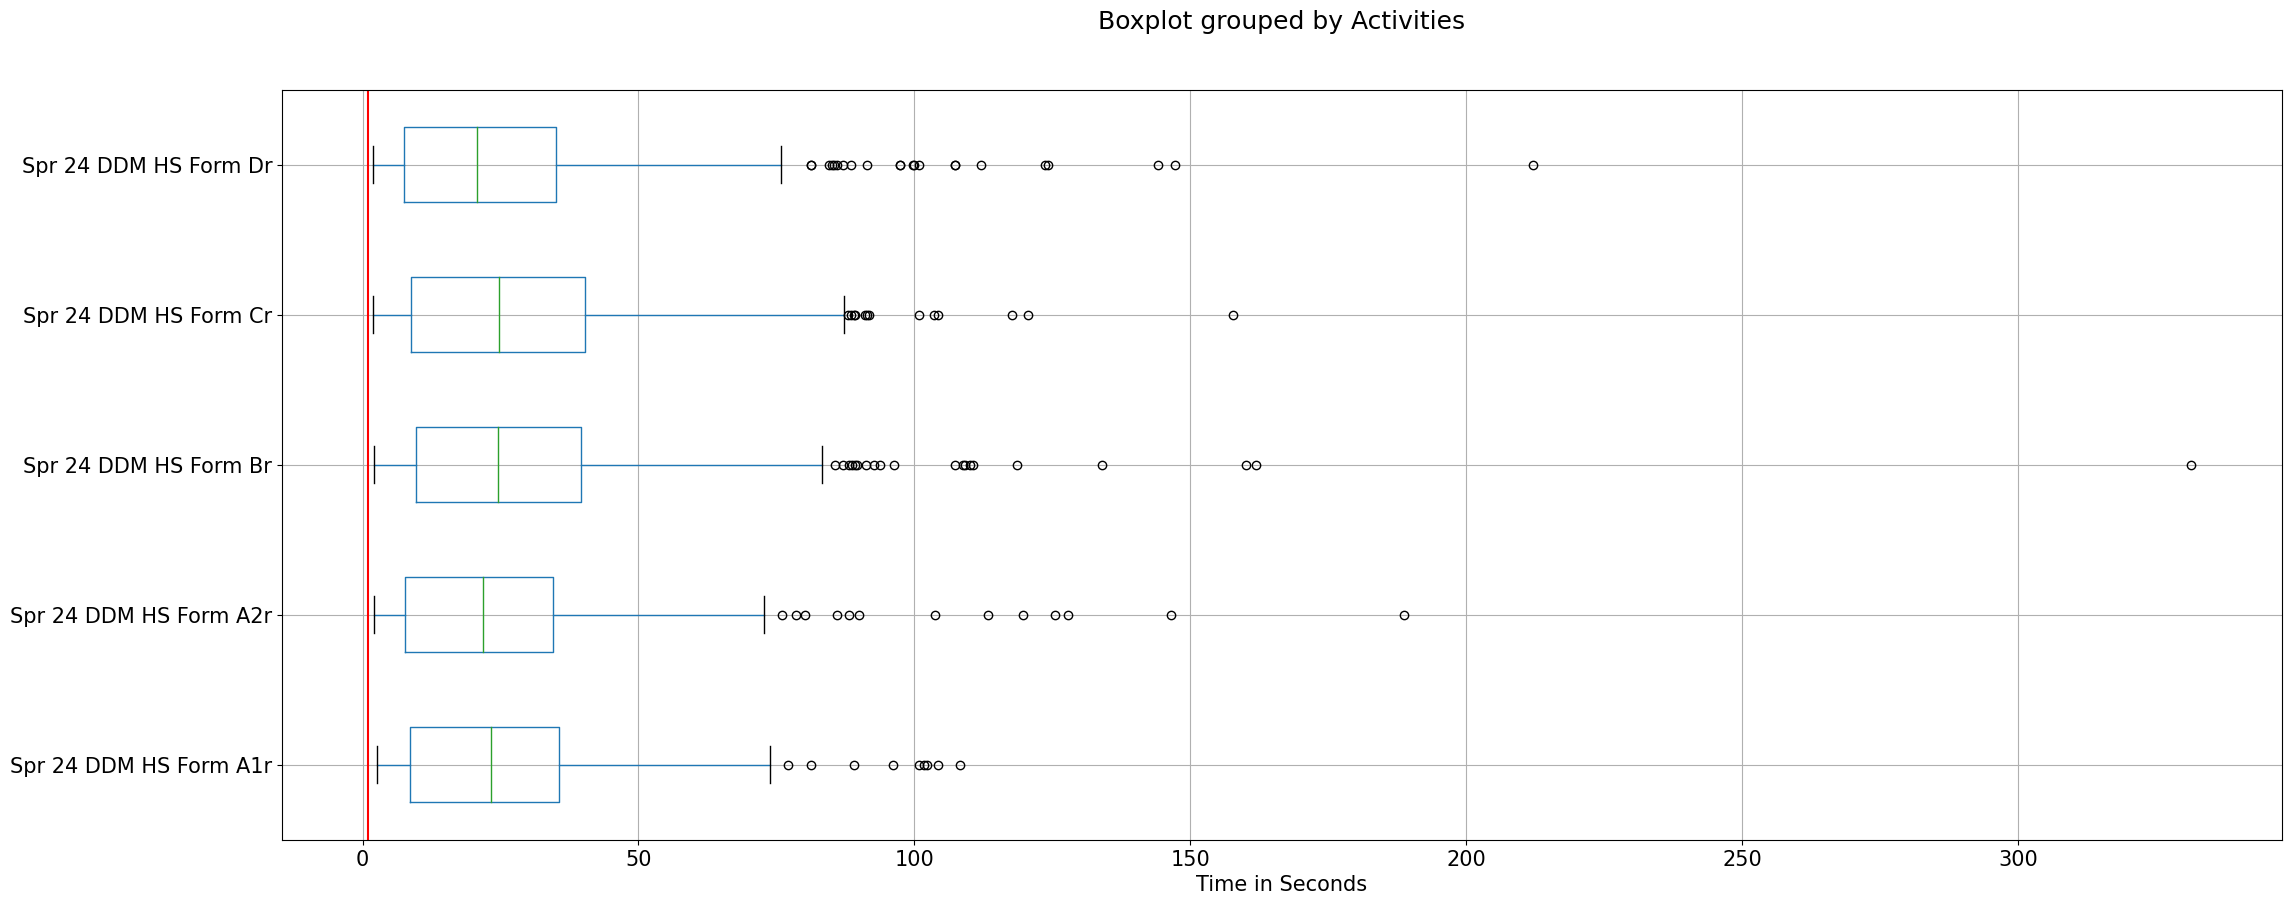

In [ ]:

# Set the aesthetic style of the plots
combined_median_df.boxplot(column = 'Response_Time_Seconds', by = 'Activities',figsize=(25,10), vert=False)
plt.title('')
plt.xlabel('Time in Seconds')
plt.ylabel('')
plt.axvline(1, color = 'r')
plt.rcParams.update({'font.size': 20})
plt.show()

# Proficiencies Scatter Plot

In [ ]:
proficiencies_df

,Assignment Id,Student Id,Activities,School,Class,Teacher,Case,P Weight,Score,Max,EAP,EAP Error,WLE,WLE Error
0,98146,28988,NaN,NIMITZ H S_482442002734,AP_Environmental_Science-2324,Mark Anthony,NaN,NaN,11,22,NaN,NaN,-0.423341,0.420978
1,98134,19305,NaN,NIMITZ H S_482442002734,AP_Environmental_Science-2324,Mark Anthony,NaN,NaN,12,29,NaN,NaN,-0.715922,0.395911
2,98492,29221,NaN,ODESSA H S_481800001587,AP_Environmental_Science-2324,Gigi De Guzman,NaN,NaN,10,27,NaN,NaN,-0.772884,0.405109
3,98491,29222,NaN,ODESSA H S_481800001587,AP_Environmental_Science-2324,Gigi De Guzman,NaN,NaN,14,29,NaN,NaN,-0.634889,0.380029
4,98483,29231,NaN,ODESSA H S_481800001587,AP_Environmental_Science-2324,Gigi De Guzman,NaN,NaN,10,27,NaN,NaN,-0.772884,0.405109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4269,101009,21813,Spr 24 DDM HS Form Br,MACARTHUR H S_482442002733,AP_Biology-2324,Kassandra Reyes,NaN,NaN,11,29,NaN,NaN,-1.045880,0.381950
4270,101011,25567,Spr 24 DDM HS Form A2r,MACARTHUR H S_482442002733,AP_Biology-2324,Kassandra Reyes,NaN,NaN,6,24,NaN,NaN,-1.426077,0.488697
4271,100997,28130,Spr 24 DDM HS Form Br,MACARTHUR H S_482442002733,AP_Biology-2324,Kassandra Reyes,NaN,NaN,10,29,NaN,NaN,-1.186427,0.387709
4272,114549,11834,Spr 24 DDM HS Form Cr,HARLAN H S_483312012985,AP_Environmental_Science-2324,Danielle Dylinski,NaN,NaN,4,27,NaN,NaN,-2.070612,0.578912


In [ ]:
proficiencies_df.rename(columns={'Assignment Id': 'Assignment'}, inplace=True)
proficiencies_df

,Assignment,Student Id,Activities,School,Class,Teacher,Case,P Weight,Score,Max,EAP,EAP Error,WLE,WLE Error
0,98146,28988,NaN,NIMITZ H S_482442002734,AP_Environmental_Science-2324,Mark Anthony,NaN,NaN,11,22,NaN,NaN,-0.423341,0.420978
1,98134,19305,NaN,NIMITZ H S_482442002734,AP_Environmental_Science-2324,Mark Anthony,NaN,NaN,12,29,NaN,NaN,-0.715922,0.395911
2,98492,29221,NaN,ODESSA H S_481800001587,AP_Environmental_Science-2324,Gigi De Guzman,NaN,NaN,10,27,NaN,NaN,-0.772884,0.405109
3,98491,29222,NaN,ODESSA H S_481800001587,AP_Environmental_Science-2324,Gigi De Guzman,NaN,NaN,14,29,NaN,NaN,-0.634889,0.380029
4,98483,29231,NaN,ODESSA H S_481800001587,AP_Environmental_Science-2324,Gigi De Guzman,NaN,NaN,10,27,NaN,NaN,-0.772884,0.405109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4269,101009,21813,Spr 24 DDM HS Form Br,MACARTHUR H S_482442002733,AP_Biology-2324,Kassandra Reyes,NaN,NaN,11,29,NaN,NaN,-1.045880,0.381950
4270,101011,25567,Spr 24 DDM HS Form A2r,MACARTHUR H S_482442002733,AP_Biology-2324,Kassandra Reyes,NaN,NaN,6,24,NaN,NaN,-1.426077,0.488697
4271,100997,28130,Spr 24 DDM HS Form Br,MACARTHUR H S_482442002733,AP_Biology-2324,Kassandra Reyes,NaN,NaN,10,29,NaN,NaN,-1.186427,0.387709
4272,114549,11834,Spr 24 DDM HS Form Cr,HARLAN H S_483312012985,AP_Environmental_Science-2324,Danielle Dylinski,NaN,NaN,4,27,NaN,NaN,-2.070612,0.578912


In [ ]:
merged_df_2 = pd.merge(combined_median_df, proficiencies_df, on='Assignment')
merged_df_2

,Assignment,Response_Time,Activities_x,Response_Time_Seconds,Student Id,Activities_y,School,Class,Teacher,Case,P Weight,Score,Max,EAP,EAP Error,WLE,WLE Error
0,96795,0 days 00:00:39.047000,Spr 24 DDM HS Form A1r,39.0470,15472,Spr 24 DDM HS Form A1r,BETHEL PARK HS_420351000062,AP_Statistics-2324,Michelle Opsasnick,NaN,NaN,12,24,NaN,NaN,-0.386477,0.404854
1,96797,0 days 00:00:25.736000,Spr 24 DDM HS Form A1r,25.7360,30311,Spr 24 DDM HS Form A1r,SHERMAN H S_484008004550,AP_Statistics-2324,Melody Young,NaN,NaN,16,24,NaN,NaN,0.292985,0.439660
2,97184,0 days 00:00:03.852000,Spr 24 DDM HS Form A1r,3.8520,31122,Spr 24 DDM HS Form A1r,JACK E SINGLEY ACADEMY_482442008525,AP_Statistics-2324,Shieh-ting Ho,NaN,NaN,3,24,NaN,NaN,-2.376158,0.656978
3,97633,0 days 00:00:39.830000,Spr 24 DDM HS Form A1r,39.8300,21625,Spr 24 DDM HS Form A1r,SATELLITE SENIOR HIGH SCHOOL_120015000131,AP_Environmental_Science-2324,Carlia Vaughn,NaN,NaN,15,24,NaN,NaN,0.108316,0.427025
4,97815,0 days 00:00:21.023000,Spr 24 DDM HS Form A1r,21.0230,19996,Spr 24 DDM HS Form A1r,JACK E SINGLEY ACADEMY_482442008525,AP_Environmental_Science-2324,Rachel Perry,NaN,NaN,8,24,NaN,NaN,-1.017921,0.434097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3625,114419,0 days 00:00:18.979000,Spr 24 DDM HS Form Dr,18.9790,41822,Spr 24 DDM HS Form Dr,NaN,CR4CR,Ana Maria Albornoz Reitze,NaN,NaN,12,29,NaN,NaN,-0.715922,0.395911
3626,114430,0 days 00:00:08.772500,Spr 24 DDM HS Form Dr,8.7725,45854,Spr 24 DDM HS Form Dr,JACK E SINGLEY ACADEMY_482442008525,AP_Biology-2324,Maria Segovia,NaN,NaN,8,29,NaN,NaN,-1.392343,0.453958
3627,114443,0 days 00:00:02.836000,Spr 24 DDM HS Form Dr,2.8360,45866,Spr 24 DDM HS Form Dr,NIMITZ H S_482442002734,AP_Biology-2324,Bibiana Mendez,NaN,NaN,8,29,NaN,NaN,-1.392343,0.453958
3628,114451,0 days 00:01:00.808000,Spr 24 DDM HS Form Dr,60.8080,45873,Spr 24 DDM HS Form Dr,LANCASTER H S_482667003003,AP_Statistics-2324,Ryan Rutledge,NaN,NaN,15,29,NaN,NaN,-0.278816,0.395164


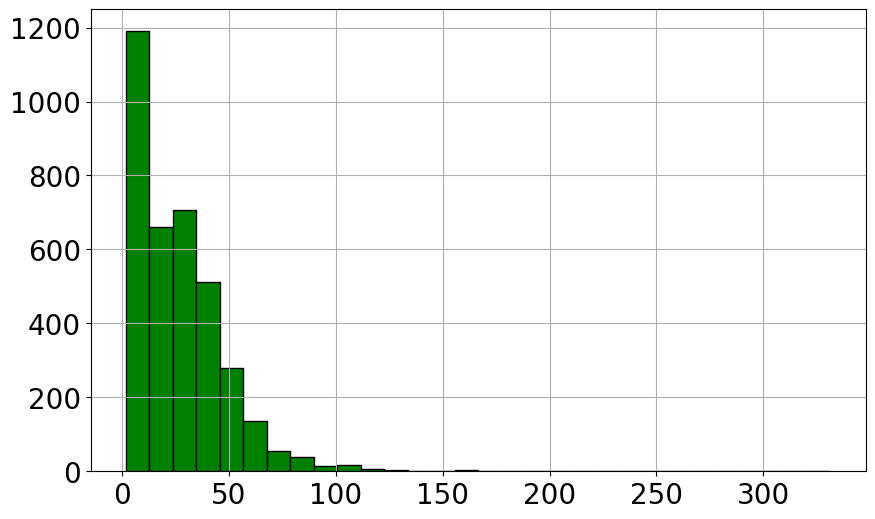

In [ ]:
merged_df_2 = merged_df_2.dropna(subset=['Response_Time_Seconds'])

# Creating the histogram
plt.figure(figsize=(10, 6))
plt.hist(merged_df_2['Response_Time_Seconds'], bins=30, color='green', edgecolor='black')
#plt.title('Histogram of Response Time Seconds')
#plt.xlabel('Response Time Seconds')
#plt.ylabel('Frequency')
plt.grid(True)
plt.show()

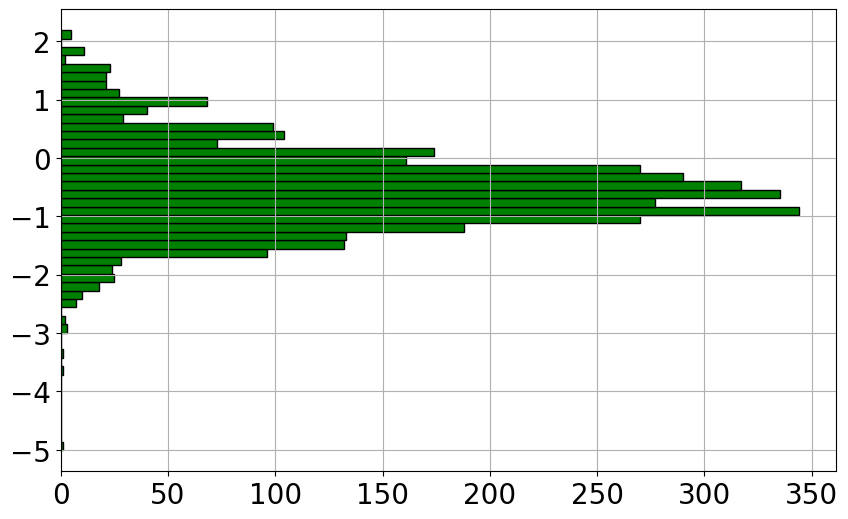

In [ ]:
merged_df_2 = merged_df_2.dropna(subset=['WLE'])

# Creating the histogram
plt.figure(figsize=(10, 6))
plt.hist(merged_df_2['WLE'], bins=50, color='green', edgecolor='black', orientation='horizontal')
#plt.title('Histogram of Response Time Seconds')
#plt.xlabel('Response Time Seconds')
#plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
import plotly.express as px
import pandas as pd

# Assuming merged_df_2 is already loaded and prepared

# Factorize the 'Class' column to get colors
merged_df_2['Class_codes'] = pd.factorize(merged_df_2['Class'])[0]

# Create the scatter plot using Plotly Express
fig = px.scatter(merged_df_2, x='Response_Time_Seconds', y='WLE',
                 color='Class',  # Use the class as color
                 labels={'Class': 'Class Categories'},  # Renaming legend title
                 hover_data=['Class', 'Response_Time_Seconds', 'WLE'],  # Data to show on hover
                 title='DDM HS Median Response Times/WLE')

# Update layout if necessary
fig.update_layout(
    xaxis_title='Median Response Time (Seconds)',
    yaxis_title='Proficiencies (WLE)',
    coloraxis_colorbar=dict(title='Class'),
    autosize=True,
    margin=dict(t=40, b=0, l=0, r=0)
)

# Show the plot
fig.show()


In [ ]:
merged_df_2['Class'].unique()

array(['AP_Statistics-2324', 'AP_Environmental_Science-2324',
       'AP_Chemistry-2324', 'AP_Biology-2324', 'CR4CR'], dtype=object)